In [ ]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [ ]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
# h5py_file.visititems(printattr)

In [ ]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
bins_dense = np.linspace(100, 300, 1000)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
JSF_arr = [0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03]
JSF_dense = np.linspace(0.97, 1.03, 100)
state_labels = ['Unmatched', 'Incorrect', 'Correct']
lan_gau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
two_gau_fit_labels = ['Mean of  first Gaussian', 'Variance of first Gaussian', 'Mean of  second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']

In [ ]:
def get_reco_top_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)*JSF

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)*JSF

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)*JSF
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS)
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, cuts, h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

In [ ]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File('ttbar_testing/ttbar_testing_{}_gev.h5'.format(m), "r")
        reco_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], assignment_spanet_dic[(m, JSF)], detection_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)] = get_reco_top_mass(h5py_file, 'spanet', JSF)
        h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
        reco_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]  = get_reco_top_mass(h5py_file, 'klfitter', JSF)

In [ ]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

def linear_parabola(x, a, b, c, d, e):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2)

#mt1 is the observation, n2 is the height of the bins from pdf.
def chi2_pdf(observed, pdf):
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*2*len(observed)
    return np.sum((n1-n2)**2/n2)

def loglikeli_two_gauss(popt, fit_target): return -2*np.sum(np.log(two_gau_norm(fit_target, *popt)))
def loglikeli_langau(popt, fit_target): return -2*np.sum(np.log(langau_norm(fit_target, *popt)))

In [ ]:
ratio_klf_dic = {i:{} for i in [0, 1, 2]}
for m in mass:
    for JSF in JSF_arr:
        for state_i in [2, 1, 0]:
            ratio = np.count_nonzero(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)]==state_i)/len(state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)])
            ratio_klf_dic[state_i][(m, JSF)] = ratio

fpdf_klf_popt = {}
fpdf_klf_perr = {}
for state_i in [0, 1, 2]:
    popt, pcov = optimize.curve_fit(pdf_ratio,  np.transpose(list(ratio_klf_dic[state_i].keys())), [ratio_klf_dic[state_i][key] for key in ratio_klf_dic[state_i]], p0 = (0.33, 0, 1, 0, 0), bounds=((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10)))
    perr = np.sqrt(np.diag(pcov))
    print('klf {} popt = '.format(state_labels[state_i]), popt)
    print('klf {} perr = '.format(state_labels[state_i]), perr)
    fpdf_klf_popt[state_i] = popt
    fpdf_klf_perr[state_i] = perr

In [ ]:
plt.figure(figsize=(30,20))
for state_i in [0, 1, 2]:
    plt.subplot(2, 3, state_i+1)

    for JSF in JSF_arr:
        plt.scatter(mass, [ratio_klf_dic[state_i][(m, JSF)] for m in mass], label='JSF = {}'.format(JSF))
        plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_klf_popt[state_i]), '--')
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')

for state_i in [0, 1, 2]:
    plt.subplot(2, 3, state_i+4)

    for m in mass:
        plt.scatter(JSF_arr, [ratio_klf_dic[state_i][(m, JSF)] for JSF in JSF_arr], label='top mass = {}'.format(m))
        plt.plot(JSF_dense, linear_parabola([np.array([m]*100), JSF_dense], *fpdf_klf_popt[state_i]), '--')
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('JSF')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
ratio_spanet_dic = {i:{} for i in [0, 1, 2]}
for m in mass:
    for JSF in JSF_arr:
        for state_i in [2, 1, 0]:
            ratio = np.count_nonzero(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)]==state_i)/len(state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>-70)])
            ratio_spanet_dic[state_i][(m, JSF)] = ratio

fpdf_spanet_popt = {}
fpdf_spanet_perr = {}
for state_i in [0, 1, 2]:
    popt, pcov = optimize.curve_fit(pdf_ratio,  np.transpose(list(ratio_spanet_dic[state_i].keys())), [ratio_spanet_dic[state_i][key] for key in ratio_spanet_dic[state_i]], p0 = (0.33, 0, 1, 0, 0), bounds=((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10)))
    perr = np.sqrt(np.diag(pcov))
    print('spanet {} popt = '.format(state_labels[state_i]), popt)
    print('spanet {} perr = '.format(state_labels[state_i]), perr)
    fpdf_spanet_popt[state_i] = popt
    fpdf_spanet_perr[state_i] = perr

In [ ]:
plt.figure(figsize=(30,20))
for state_i in [0, 1, 2]:
    plt.subplot(2, 3, state_i+1)

    for JSF in JSF_arr:
        plt.scatter(mass, [ratio_spanet_dic[state_i][(m, JSF)] for m in mass], label='JSF = {}'.format(JSF))
        plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_spanet_popt[state_i]), '--')
    plt.title('spanet ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')

for state_i in [0, 1, 2]:
    plt.subplot(2, 3, state_i+4)

    for m in mass:
        plt.scatter(JSF_arr, [ratio_spanet_dic[state_i][(m, JSF)] for JSF in JSF_arr], label='top mass = {}'.format(m))
        plt.plot(JSF_dense, linear_parabola([np.array([m]*100), JSF_dense], *fpdf_spanet_popt[state_i]), '--')
    plt.title('spanet ' + state_labels[state_i])
    plt.xlabel('JSF')
    plt.ylabel(state_labels[state_i] + ' ratio')
    plt.legend(loc='upper right')
plt.show()

In [ ]:
# Fit every class to landau gaussian
fit_popt_dic = {i:{} for i in [0, 1, 2]}
fit_perr_dic = {i:{} for i in [0, 1, 2]}

for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 30))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(3, 3, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>-70))]
            hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
            # 2Gaussian for correct
            if state_i == 2:
                popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 170, 20, 0.9), bounds=((140, 10, 140, 10, 0), (200, 30, 200, 30, 1)))
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+1, *popt))
            
            # Landau + Gaussian for incorrect and unmatch
            else:
                popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (160, 30, 250, 30, 1)))
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+1, *popt))

            fit_popt_dic[state_i][(m, JSF)] = popt
            fit_perr_dic[state_i][(m, JSF)] = np.sqrt(np.diag(pcov))
            plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=2, color='None', label = state_labels[state_i] + 'histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.xlim(100, 300)
            plt.title('klf {}, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend()
        plt.show()

In [ ]:
pdf_klf_dic = defaultdict(list)
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_parabola, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_dic[(state_i, i)] = popt
        
        for JSF in JSF_arr: plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label='JSF = {}'.format(JSF))
        plt.legend(loc='upper right')
        plt.title('KLF PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(lan_gau_fit_labels[i])
    plt.show()

In [ ]:
# Fit every class to landau gaussian
fit_popt_dic = {i:{} for i in [0, 1, 2]}
fit_perr_dic = {i:{} for i in [0, 1, 2]}

for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 30))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(3, 3, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>-70))]
            hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
            # 2Gaussian for correct
            if state_i == 2:
                popt, pcov = optimize.curve_fit(two_gau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 170, 20, 0.9), bounds=((140, 10, 140, 10, 0), (200, 30, 200, 30, 1)))
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+1, *popt))
            
            # Landau + Gaussian for incorrect and unmatch
            else:
                popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist, p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (160, 30, 250, 30, 1)))
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+1, *popt))

            fit_popt_dic[state_i][(m, JSF)] = popt
            fit_perr_dic[state_i][(m, JSF)] = np.sqrt(np.diag(pcov))
            plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=2, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.xlim(100, 300)
            plt.title('spanet {}, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend()
        plt.show()

In [ ]:
pdf_spanet_dic = defaultdict(list)
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_parabola, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_dic[(state_i, i)] = popt
        
        for JSF in JSF_arr: plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label='JSF = {}'.format(JSF))
        plt.legend(loc='upper right')
        plt.title('SPANET PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        if state_i == 2: plt.ylabel(two_gau_fit_labels[i])
        else: plt.ylabel(lan_gau_fit_labels[i])
    plt.show()

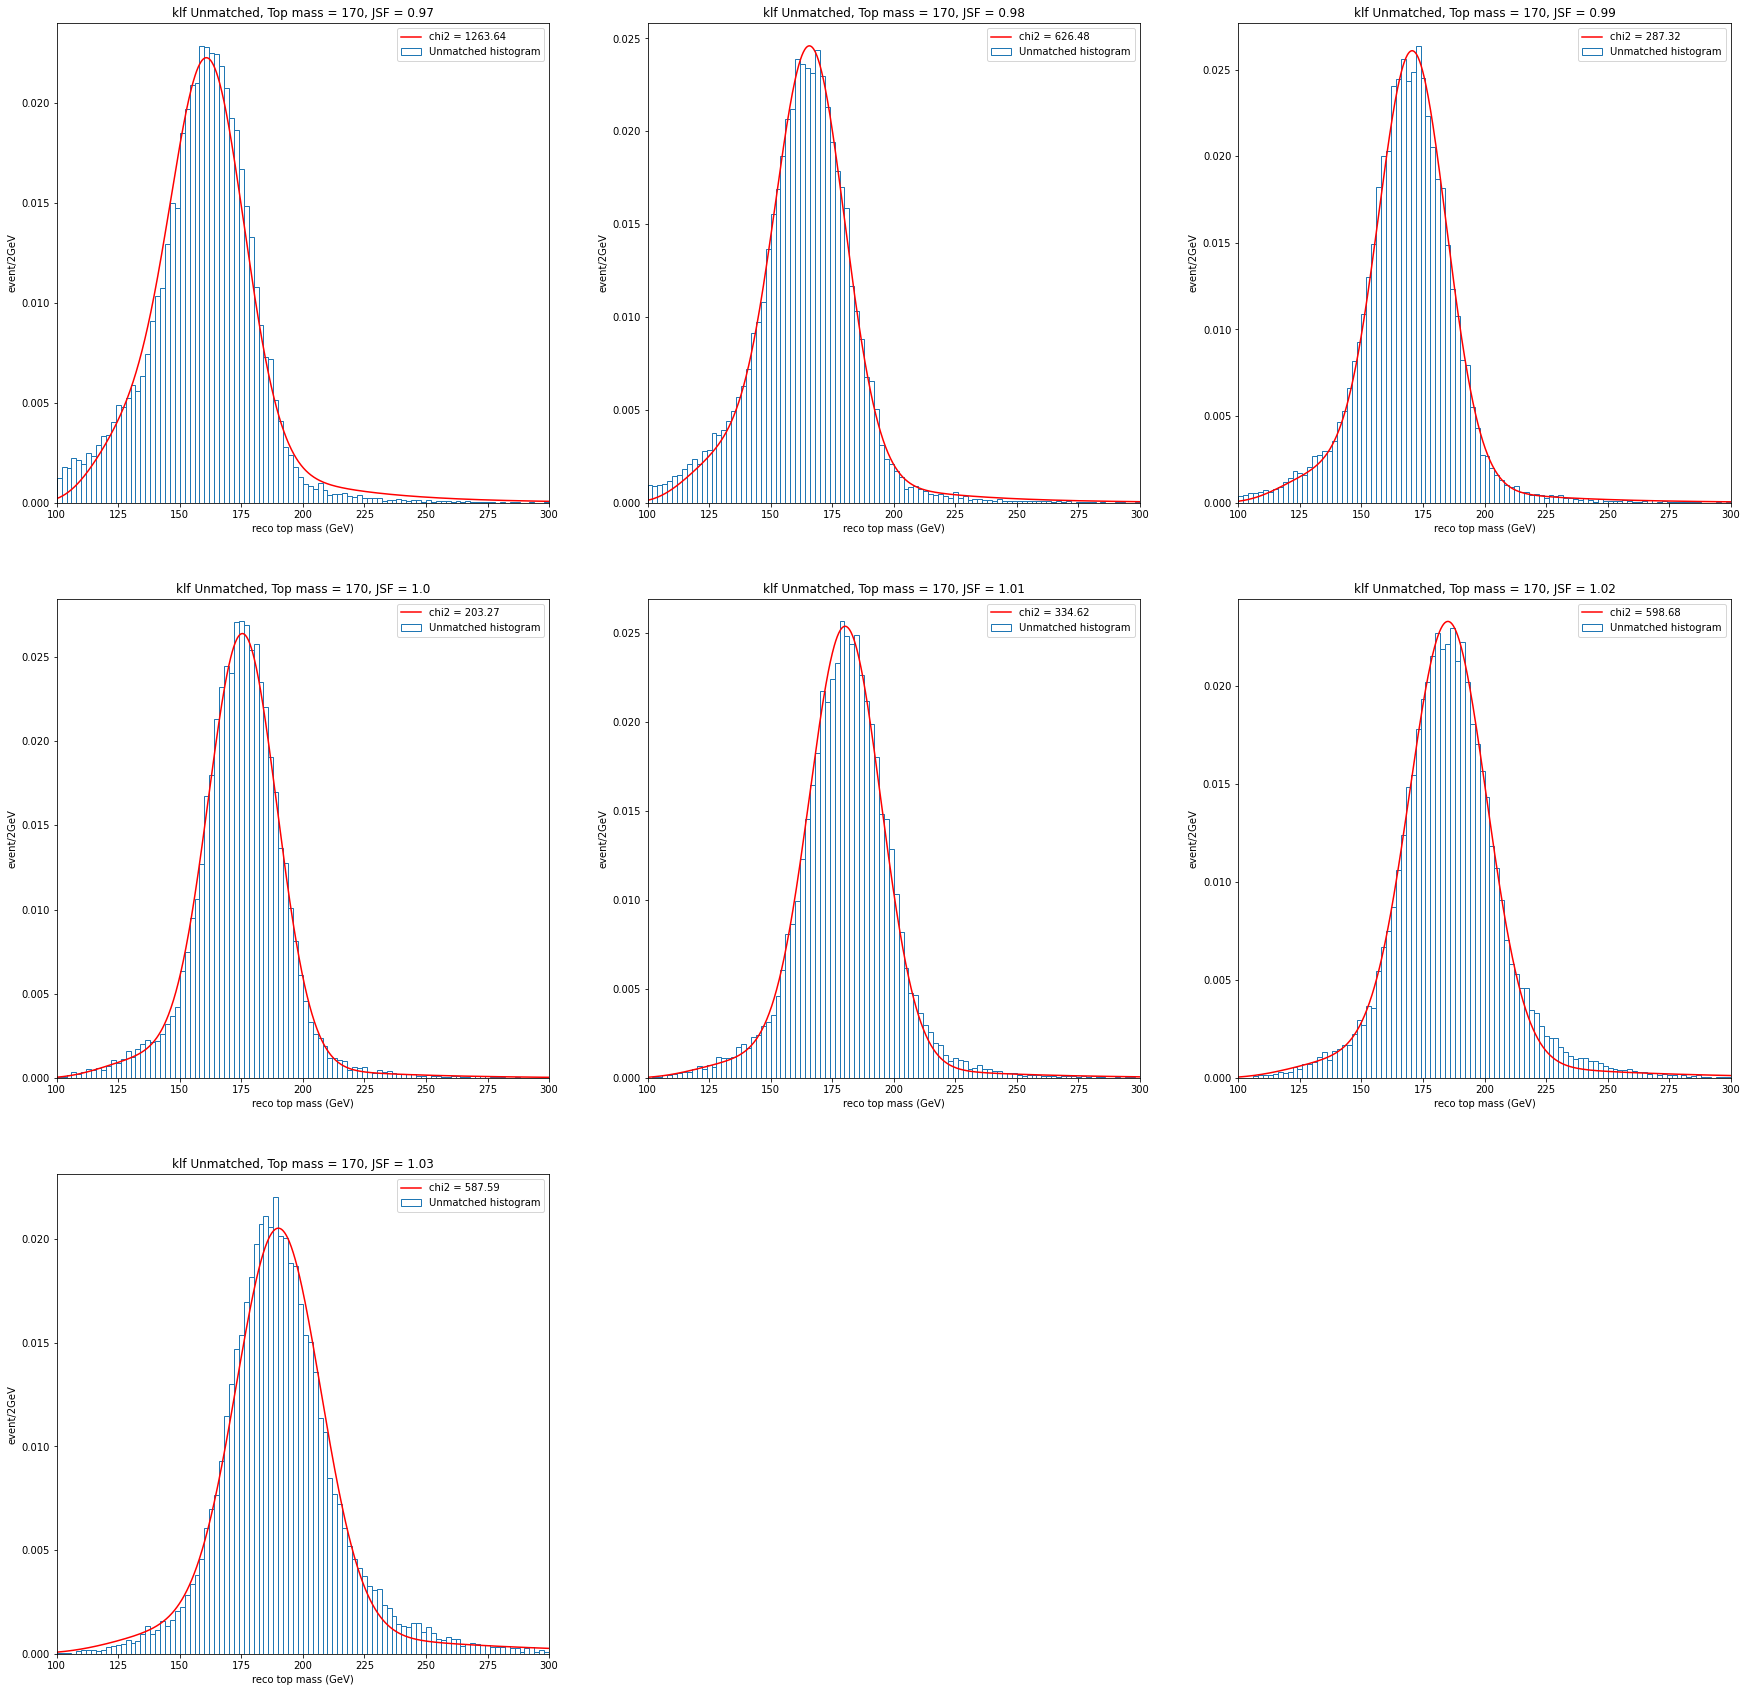

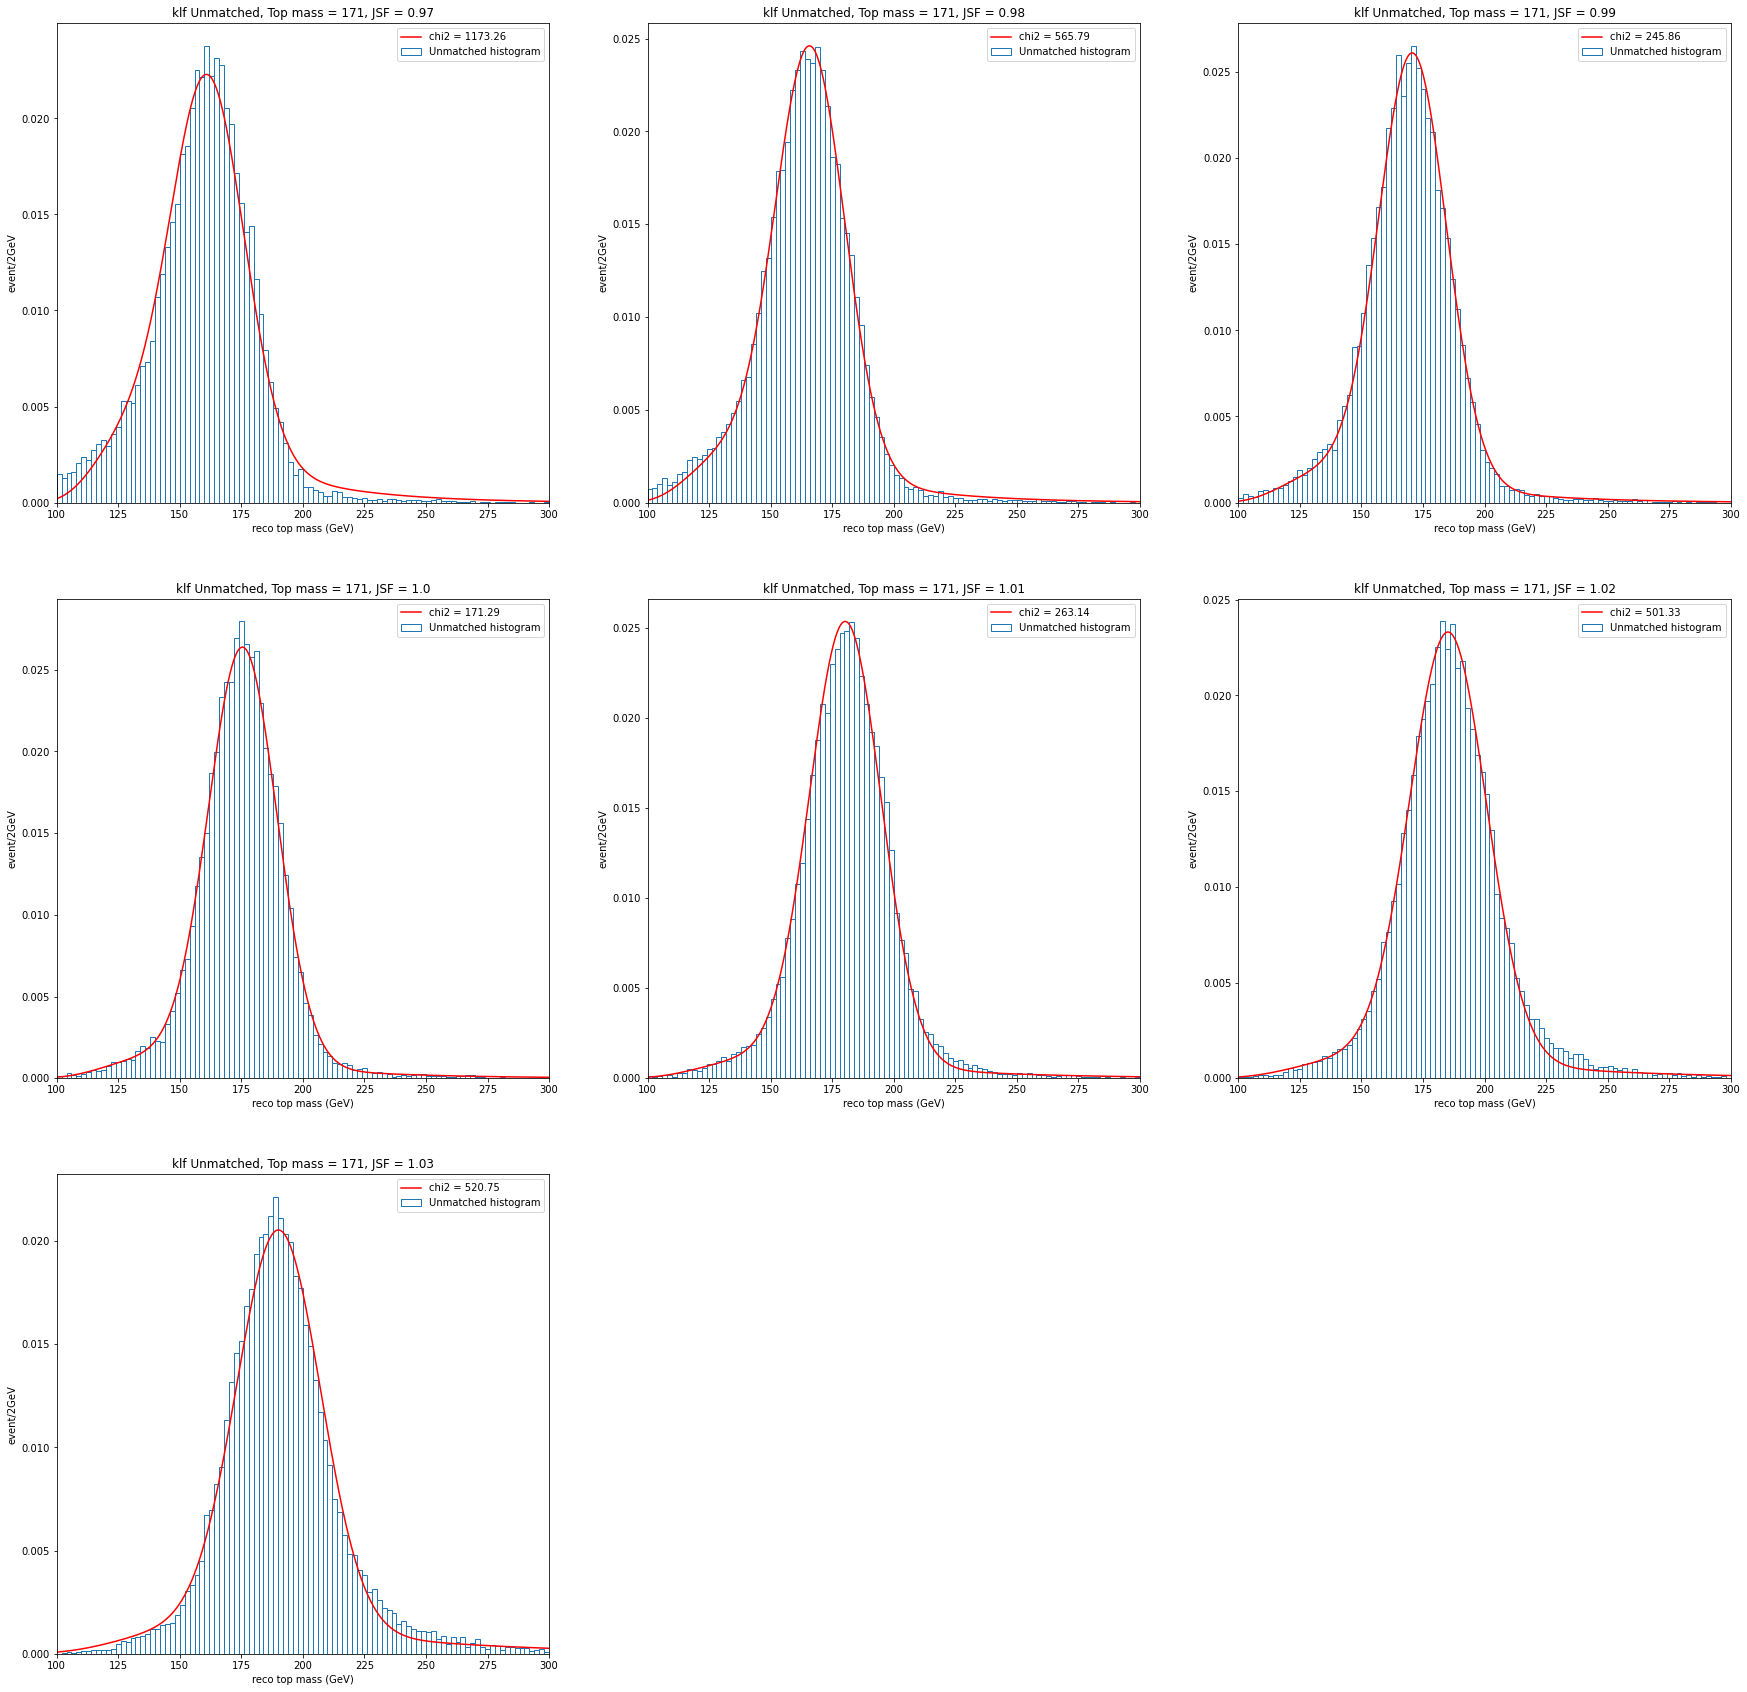

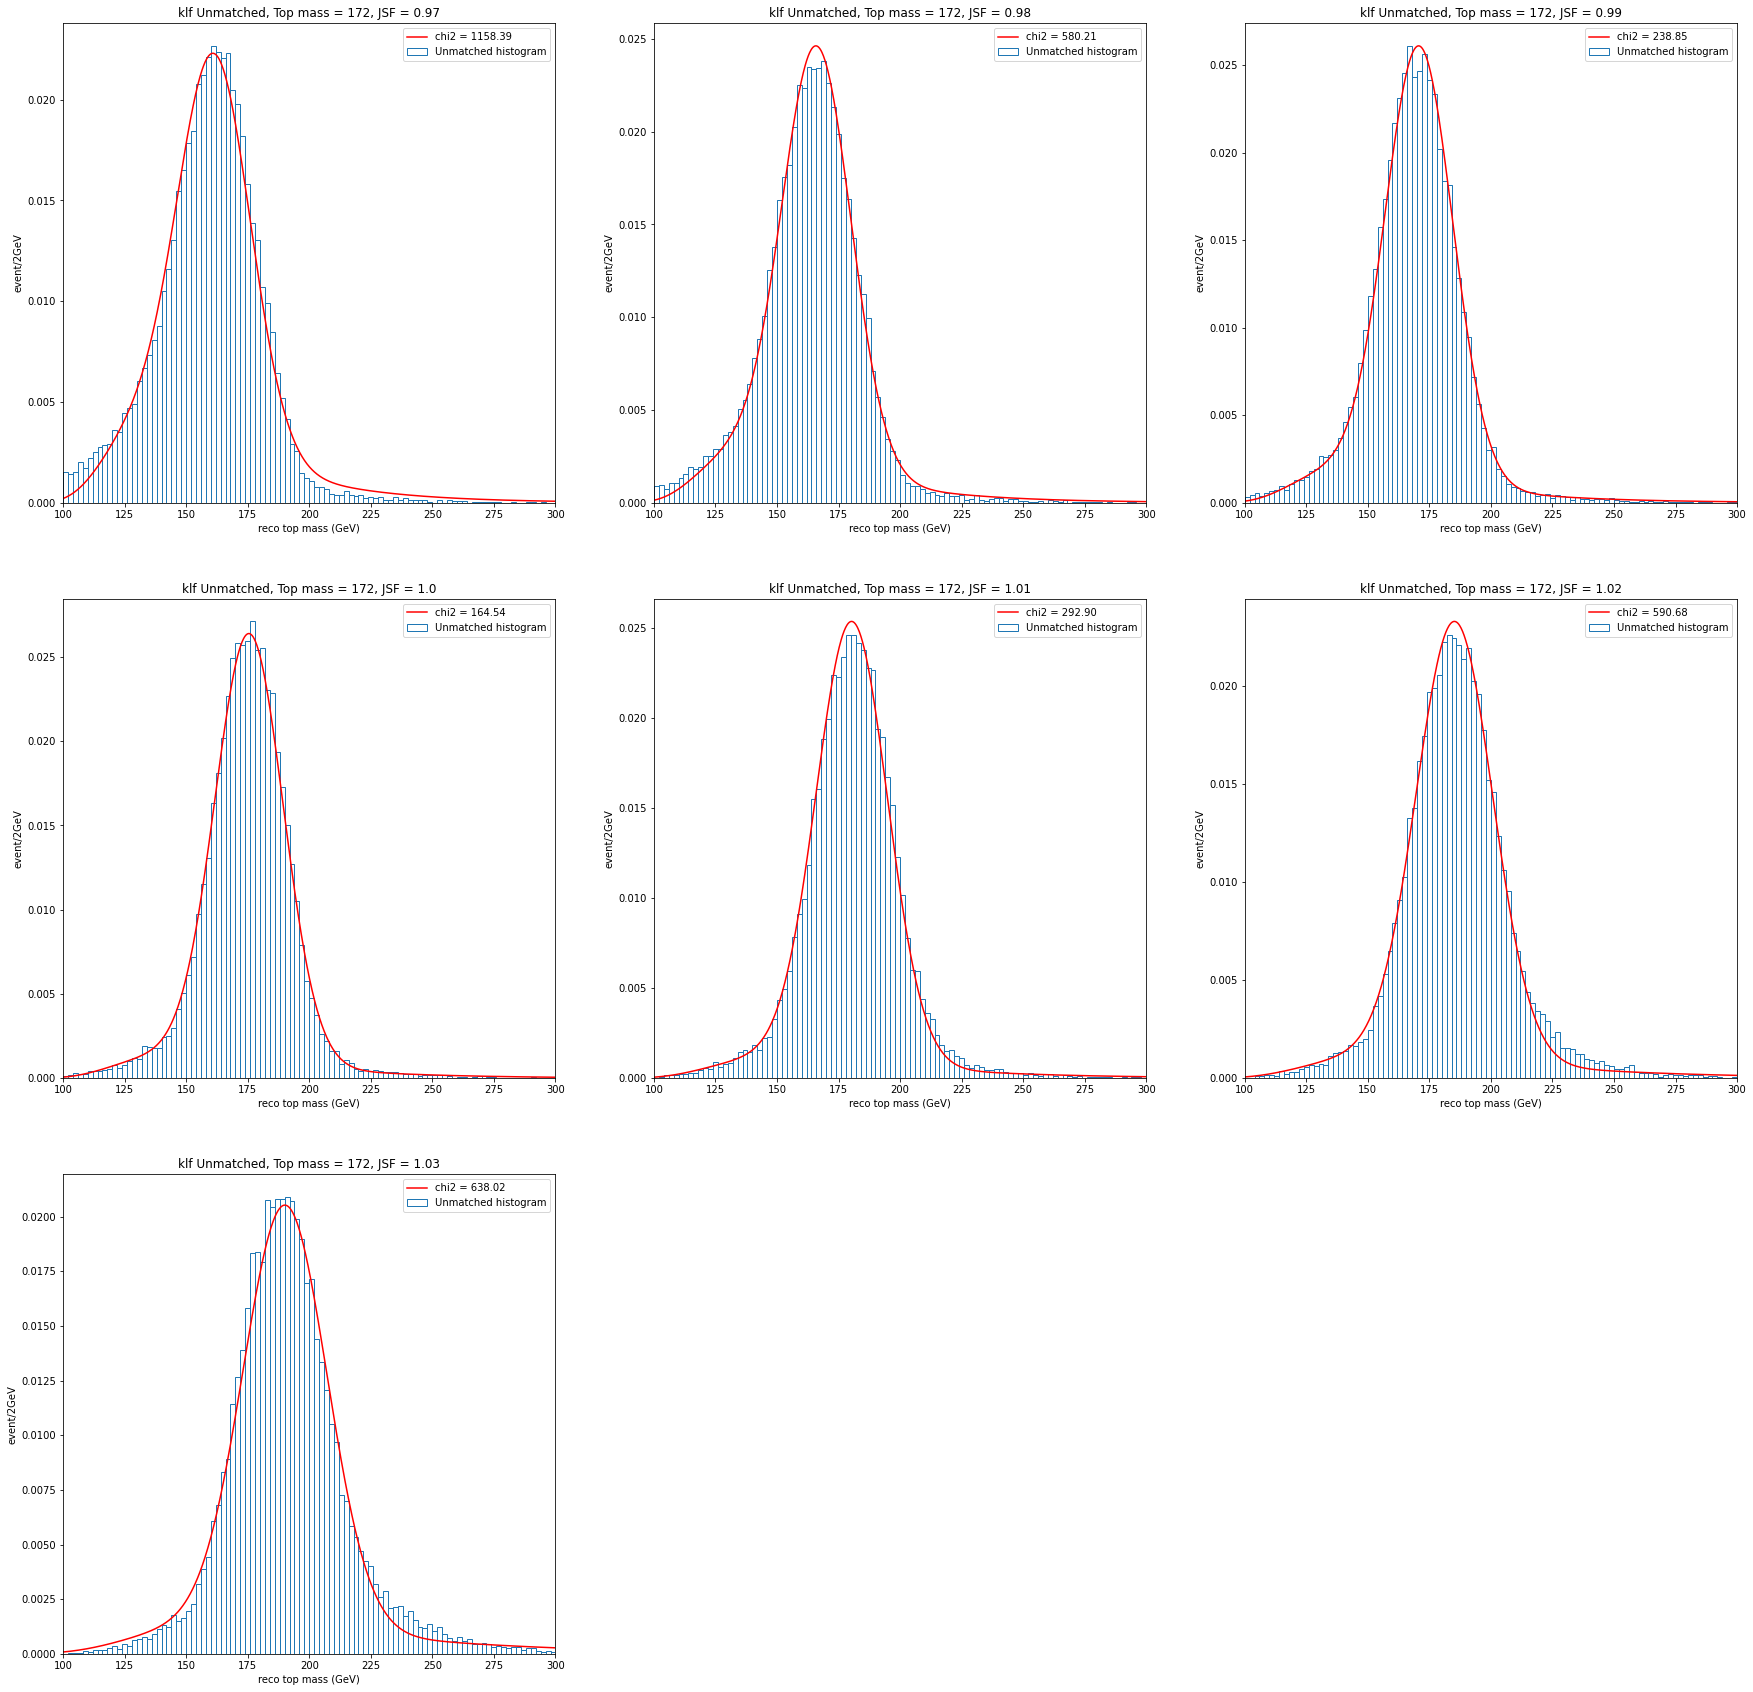

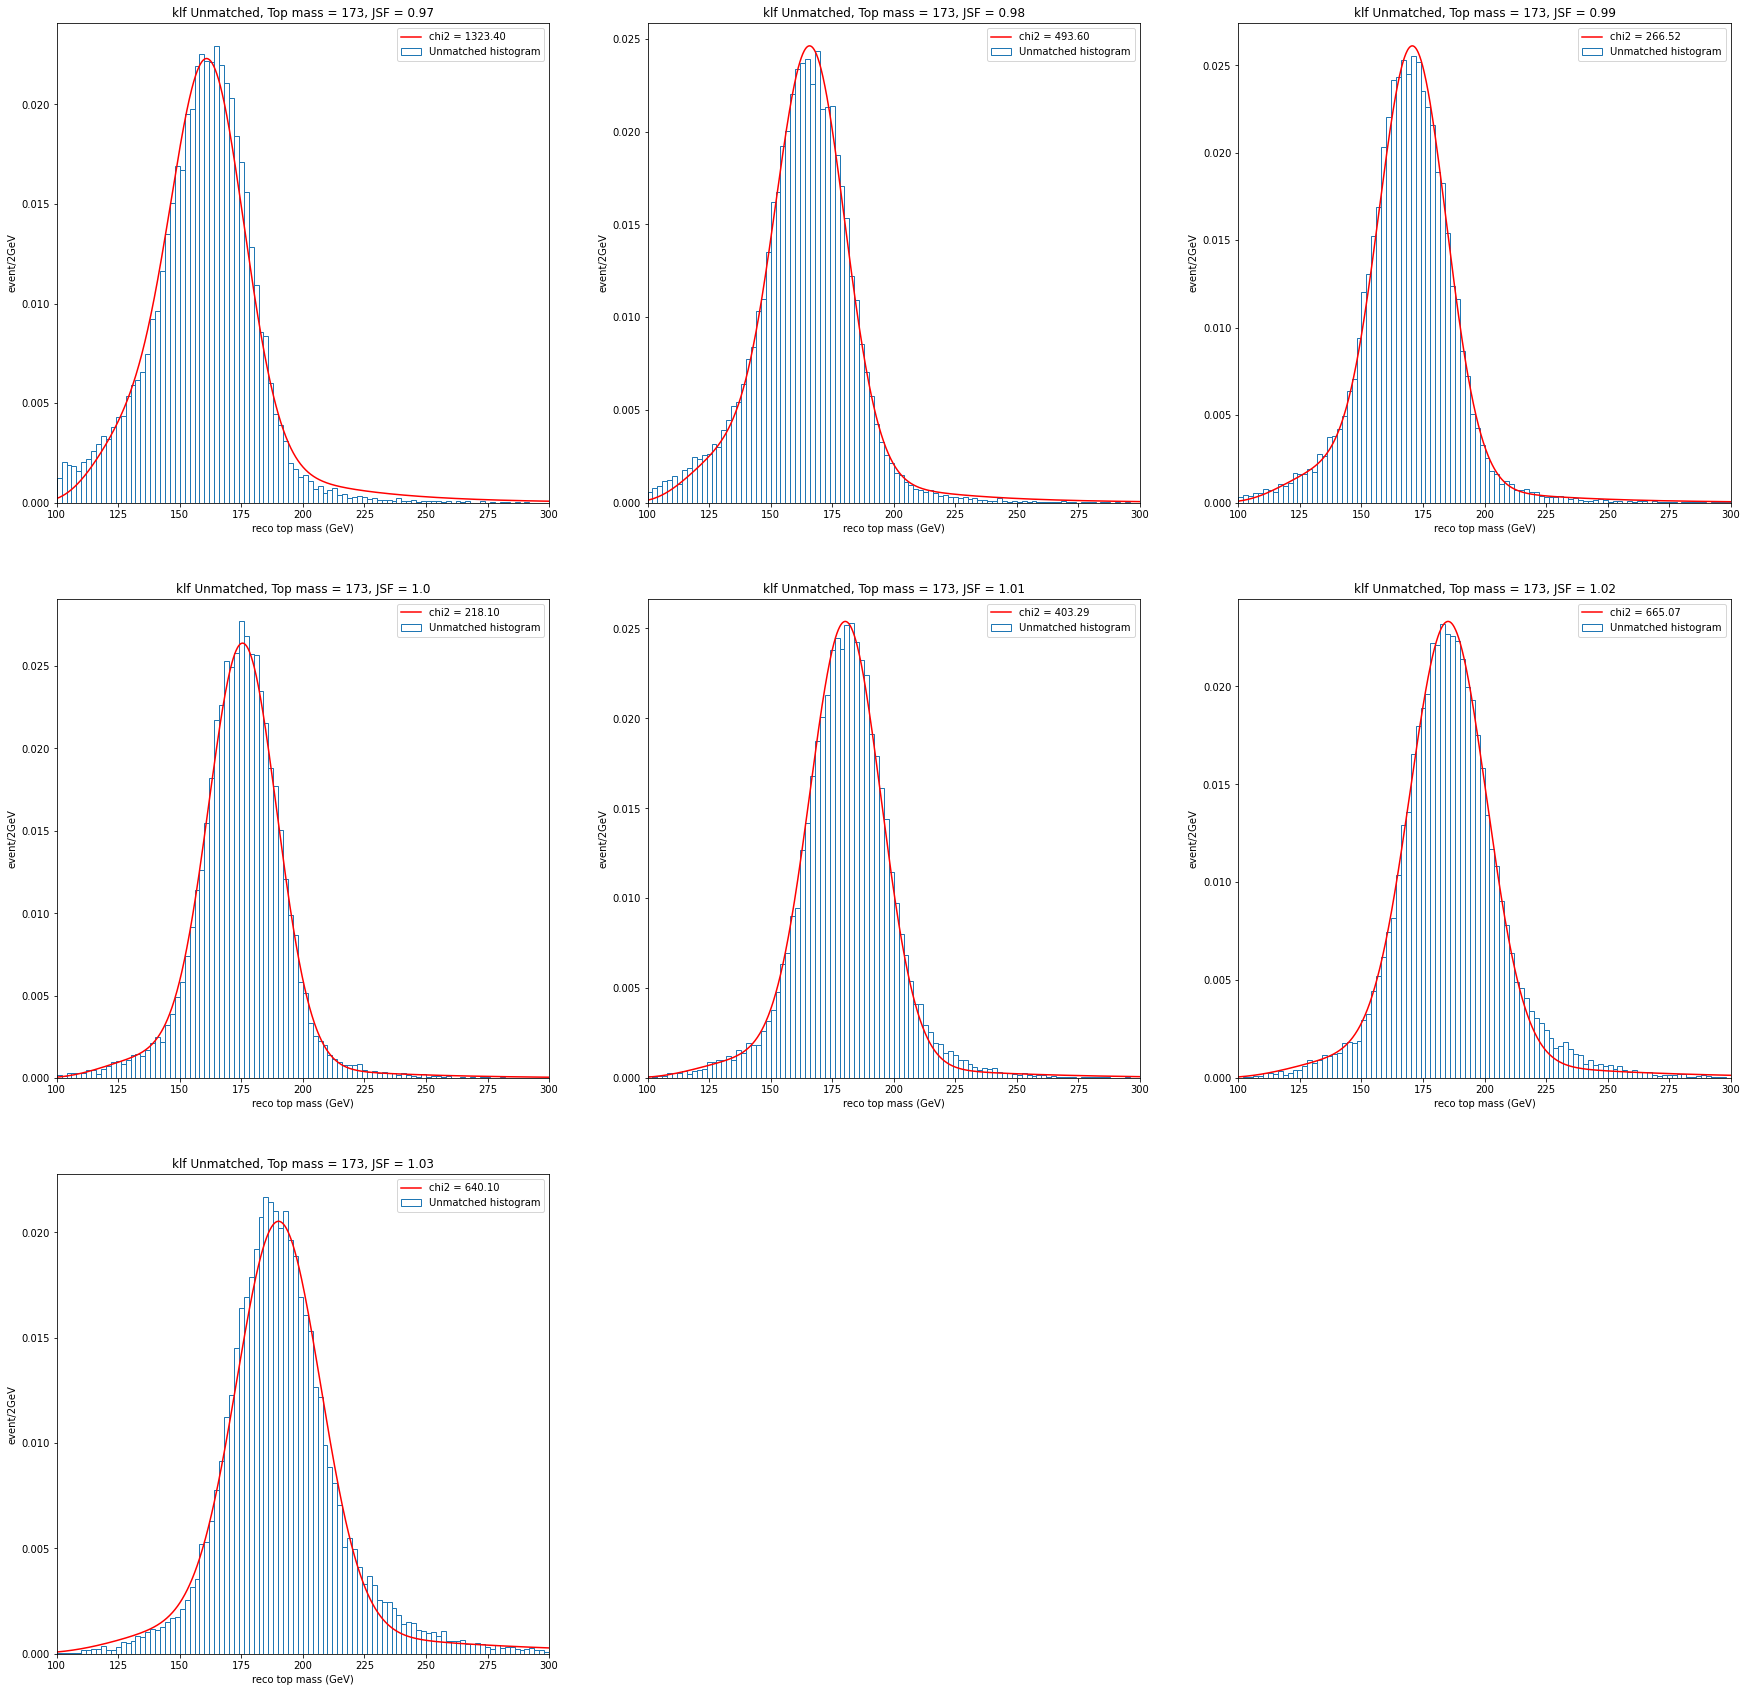

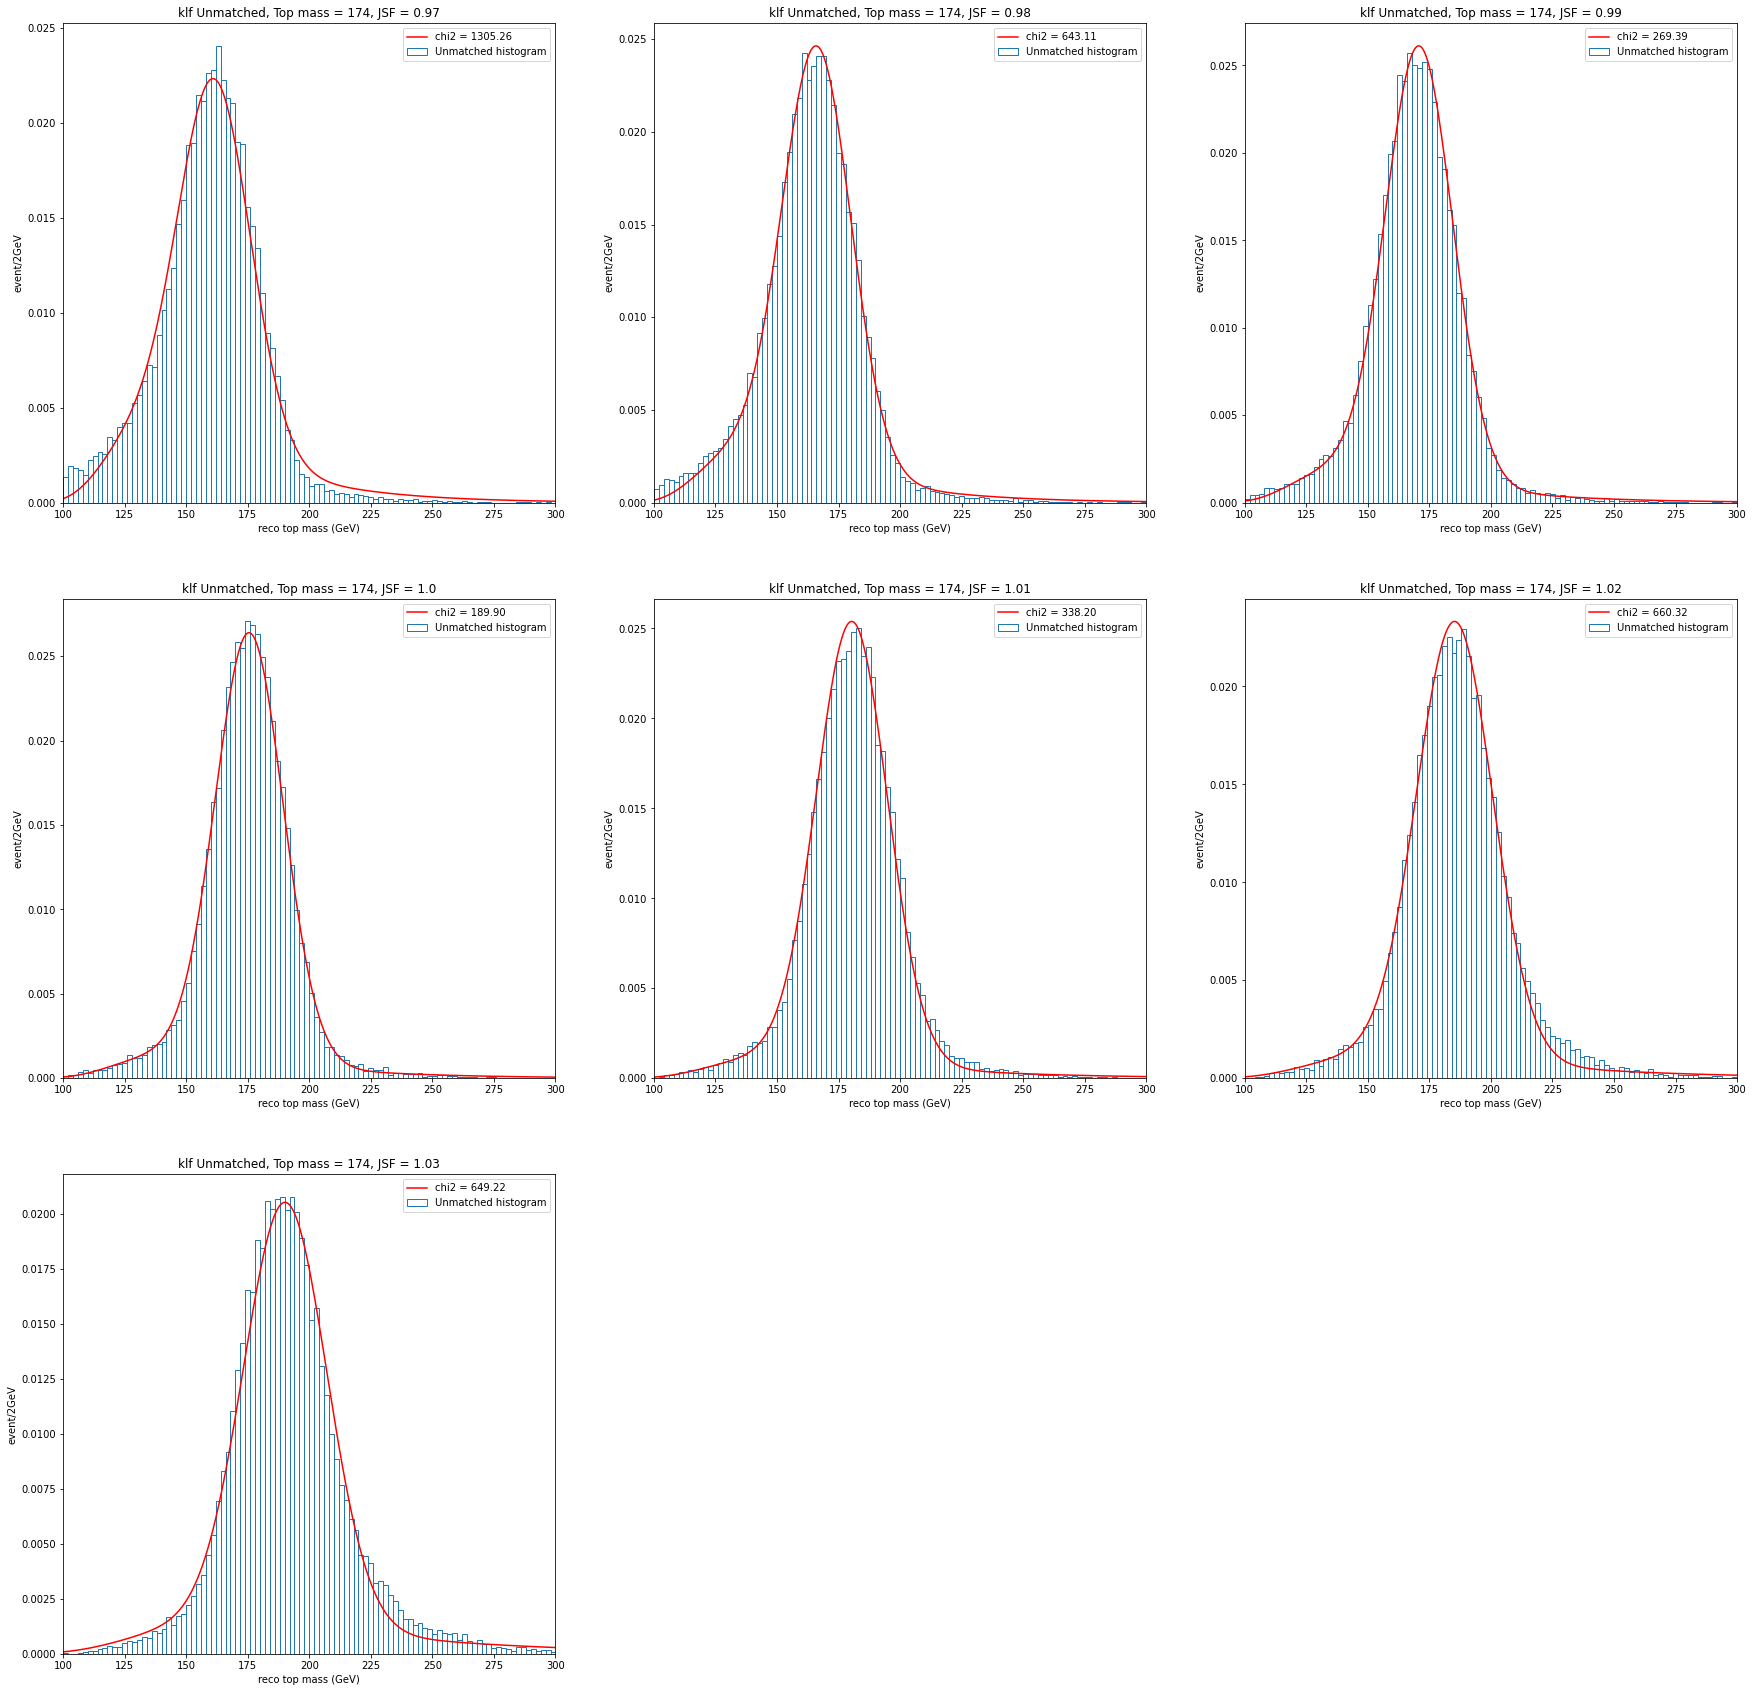

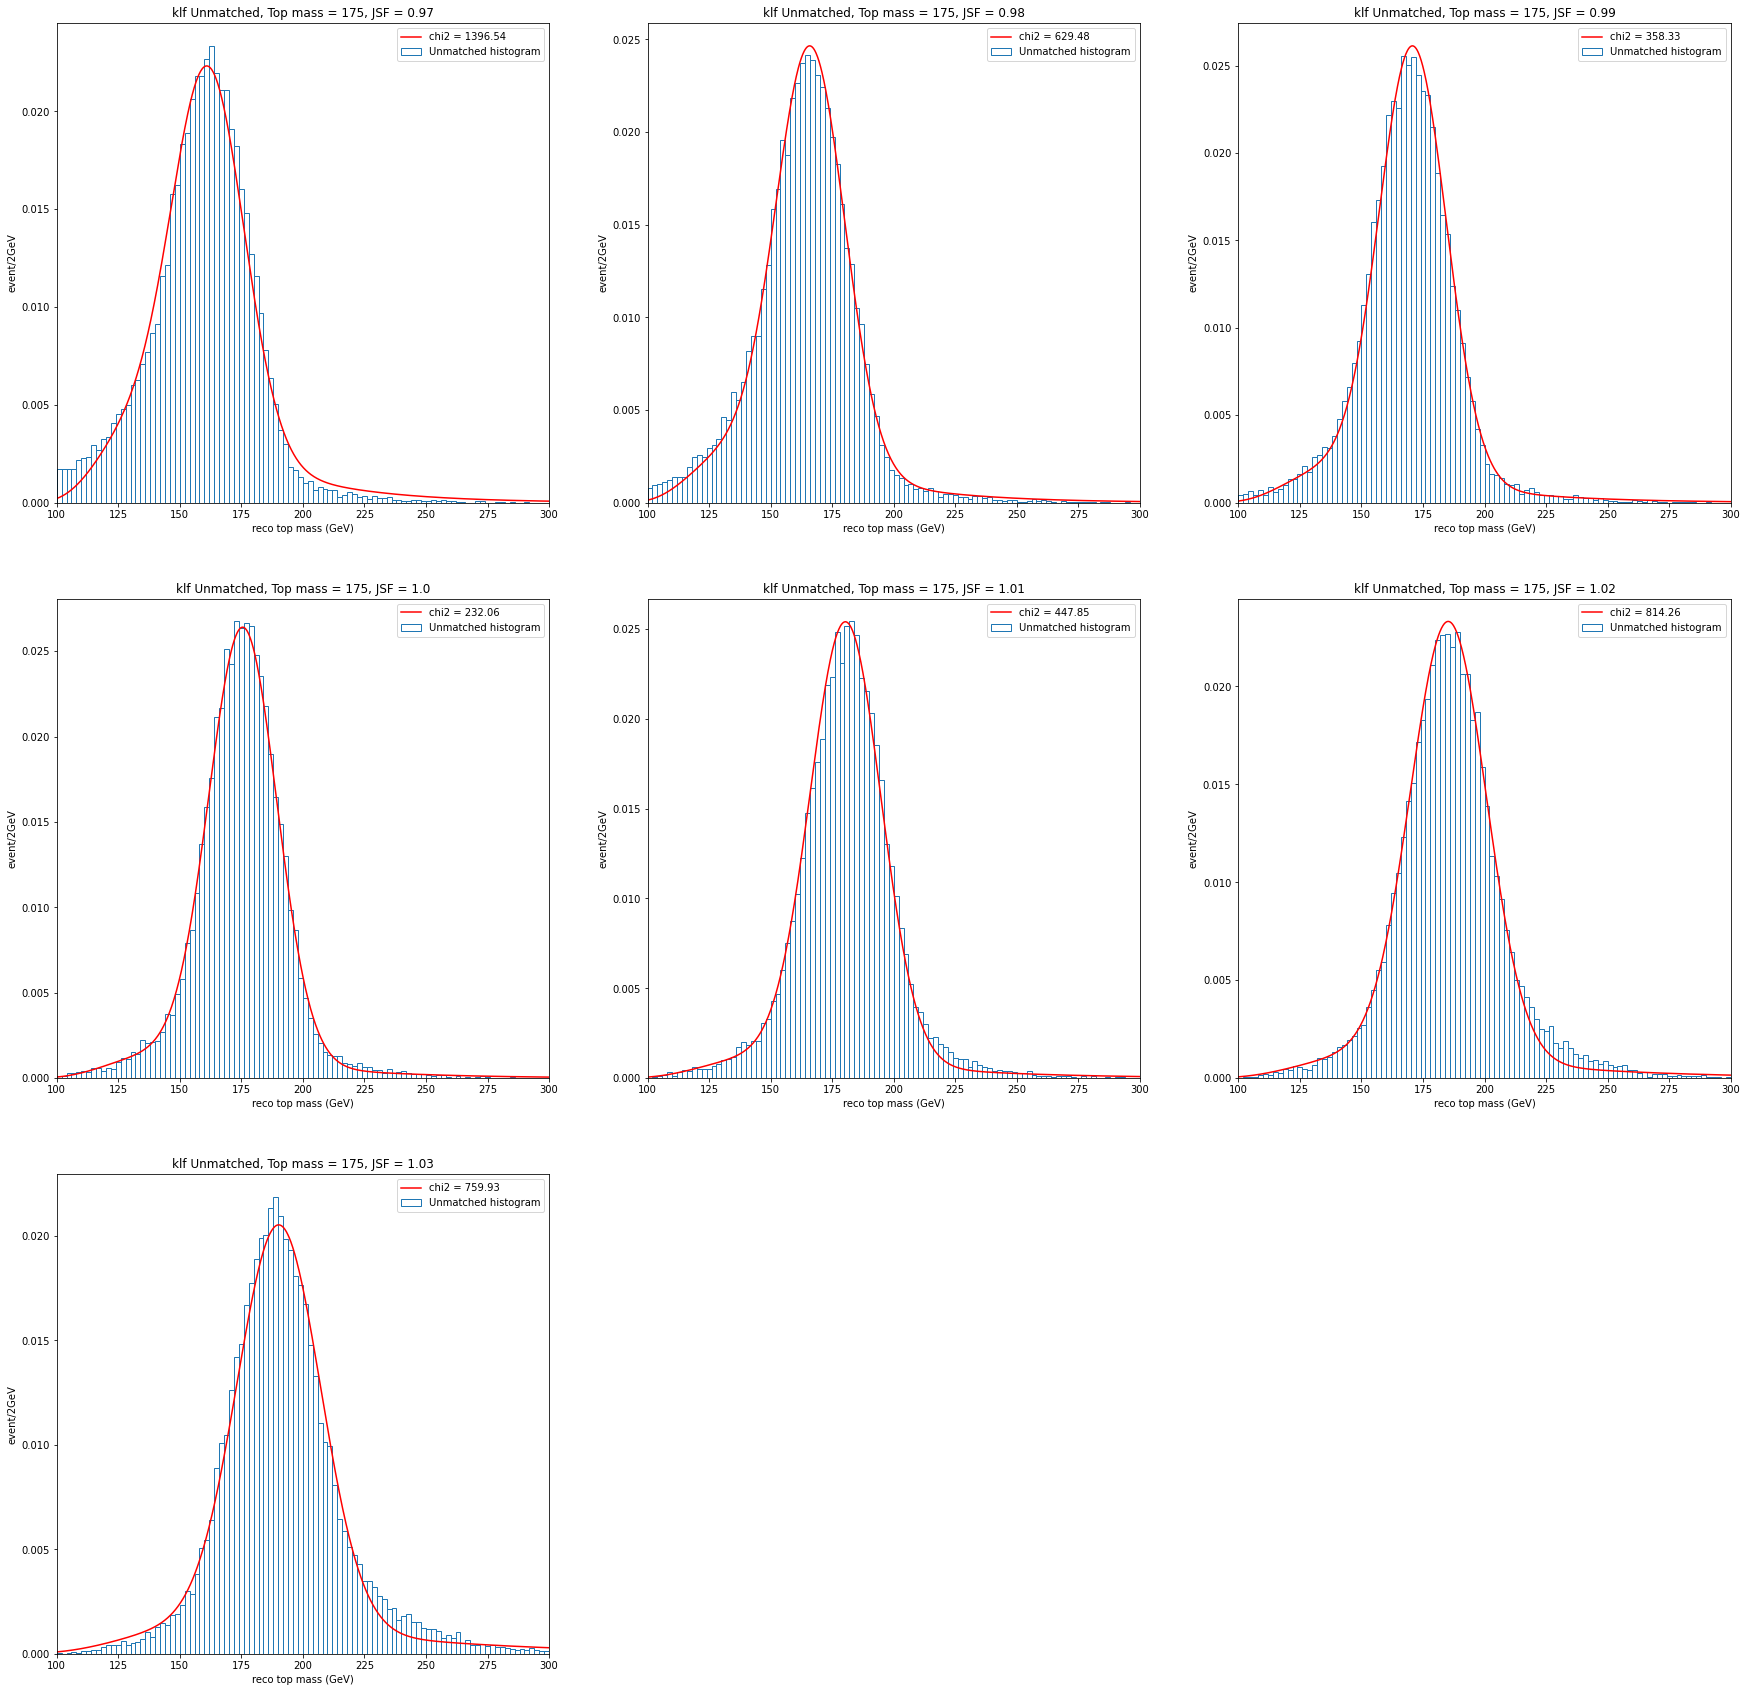

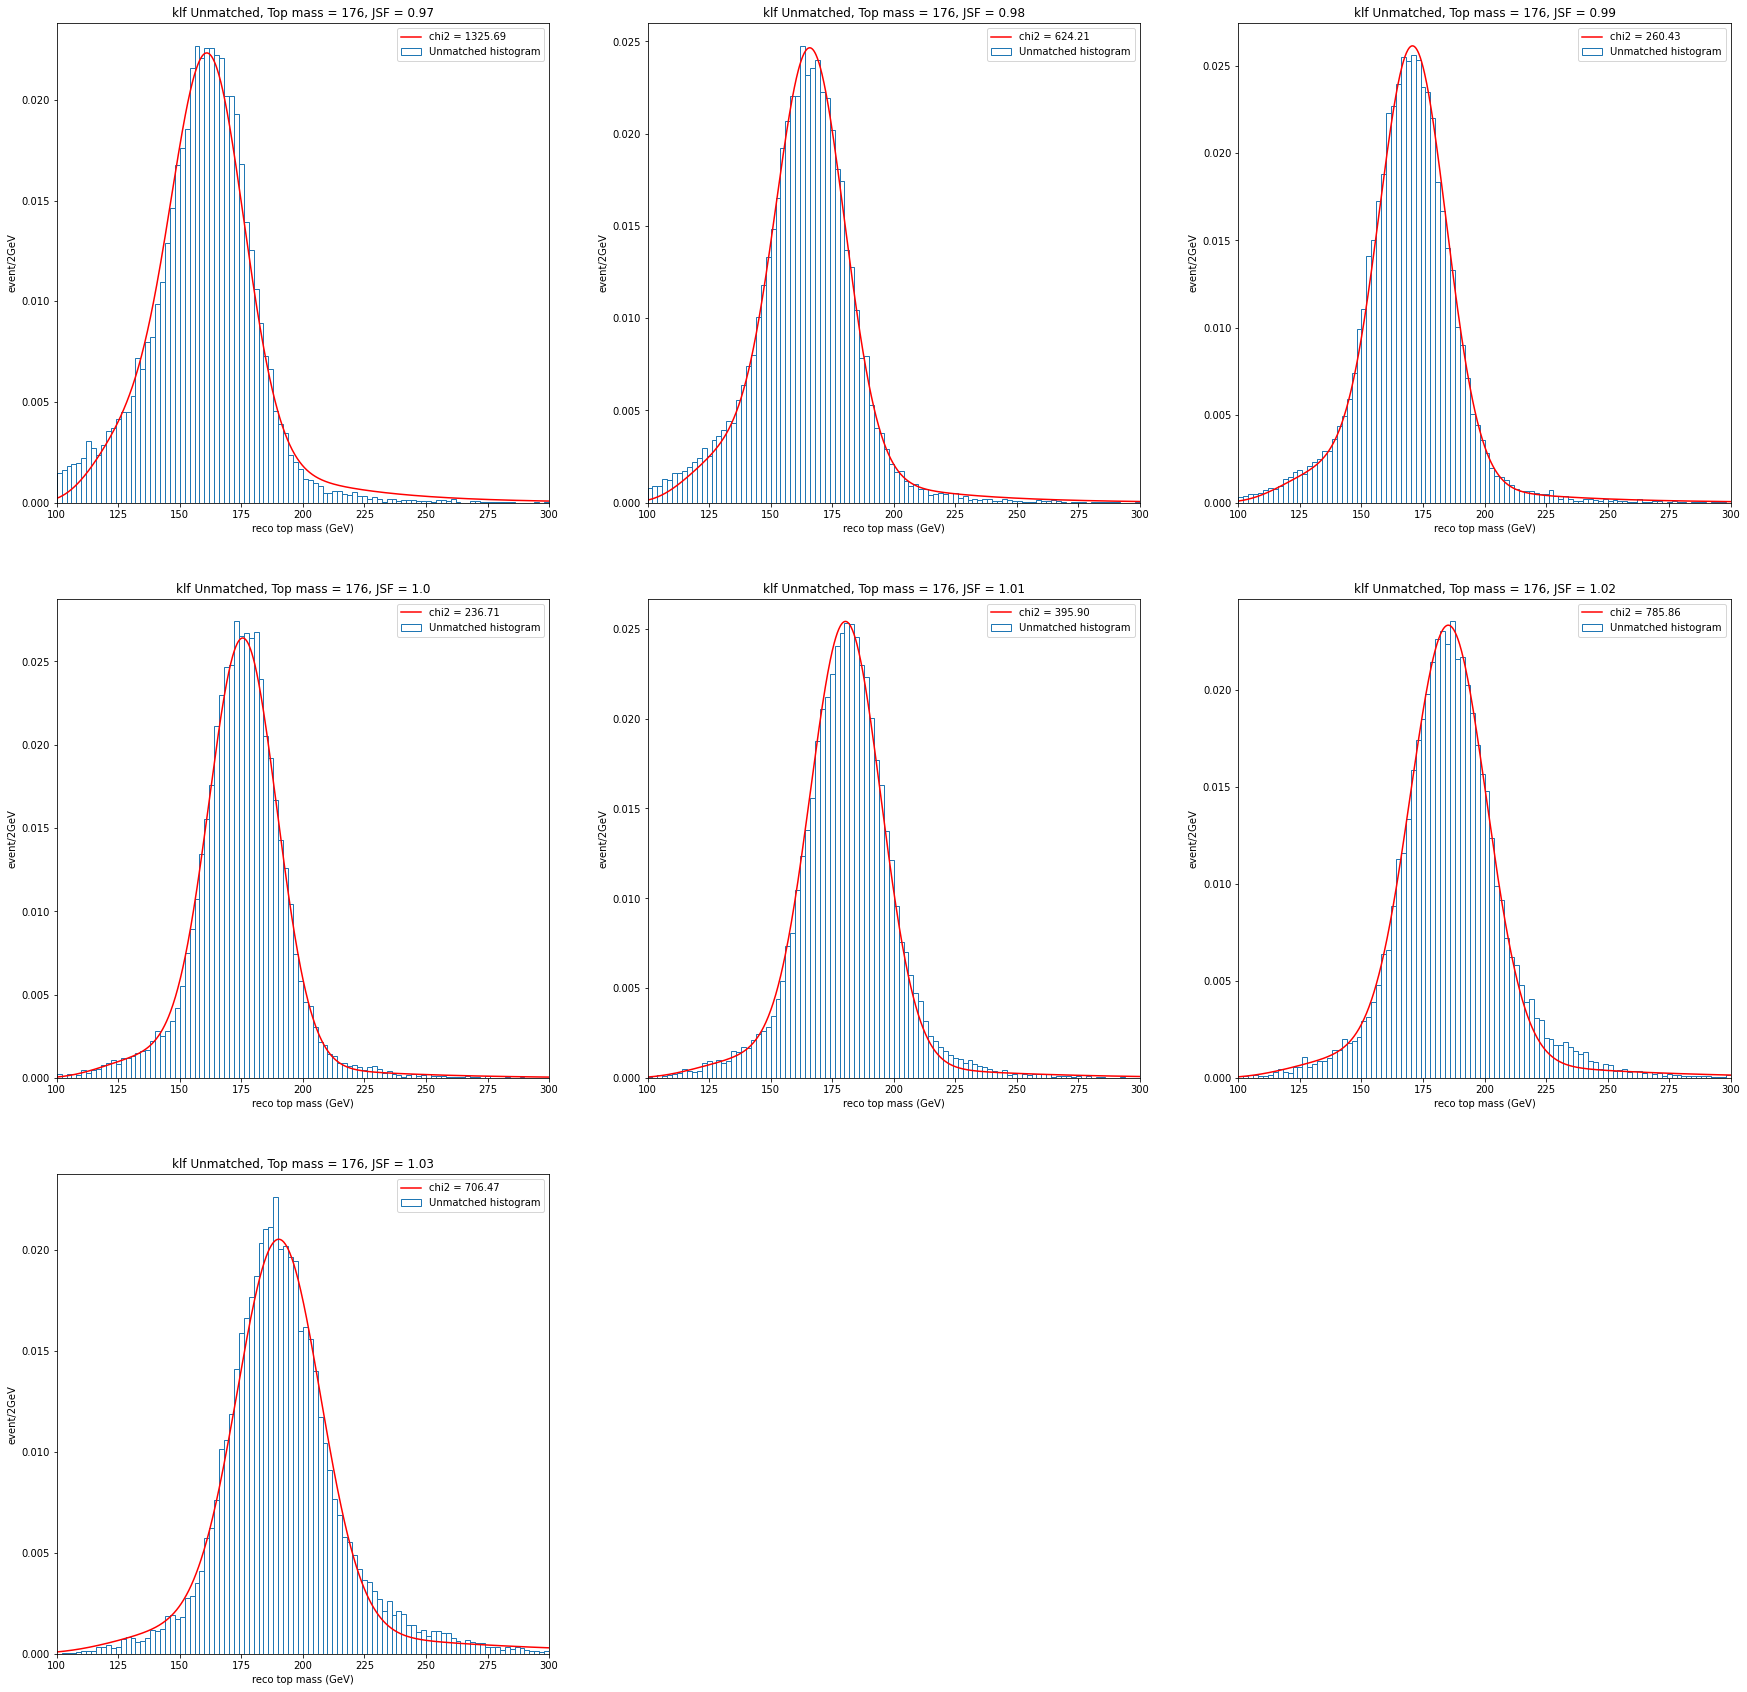

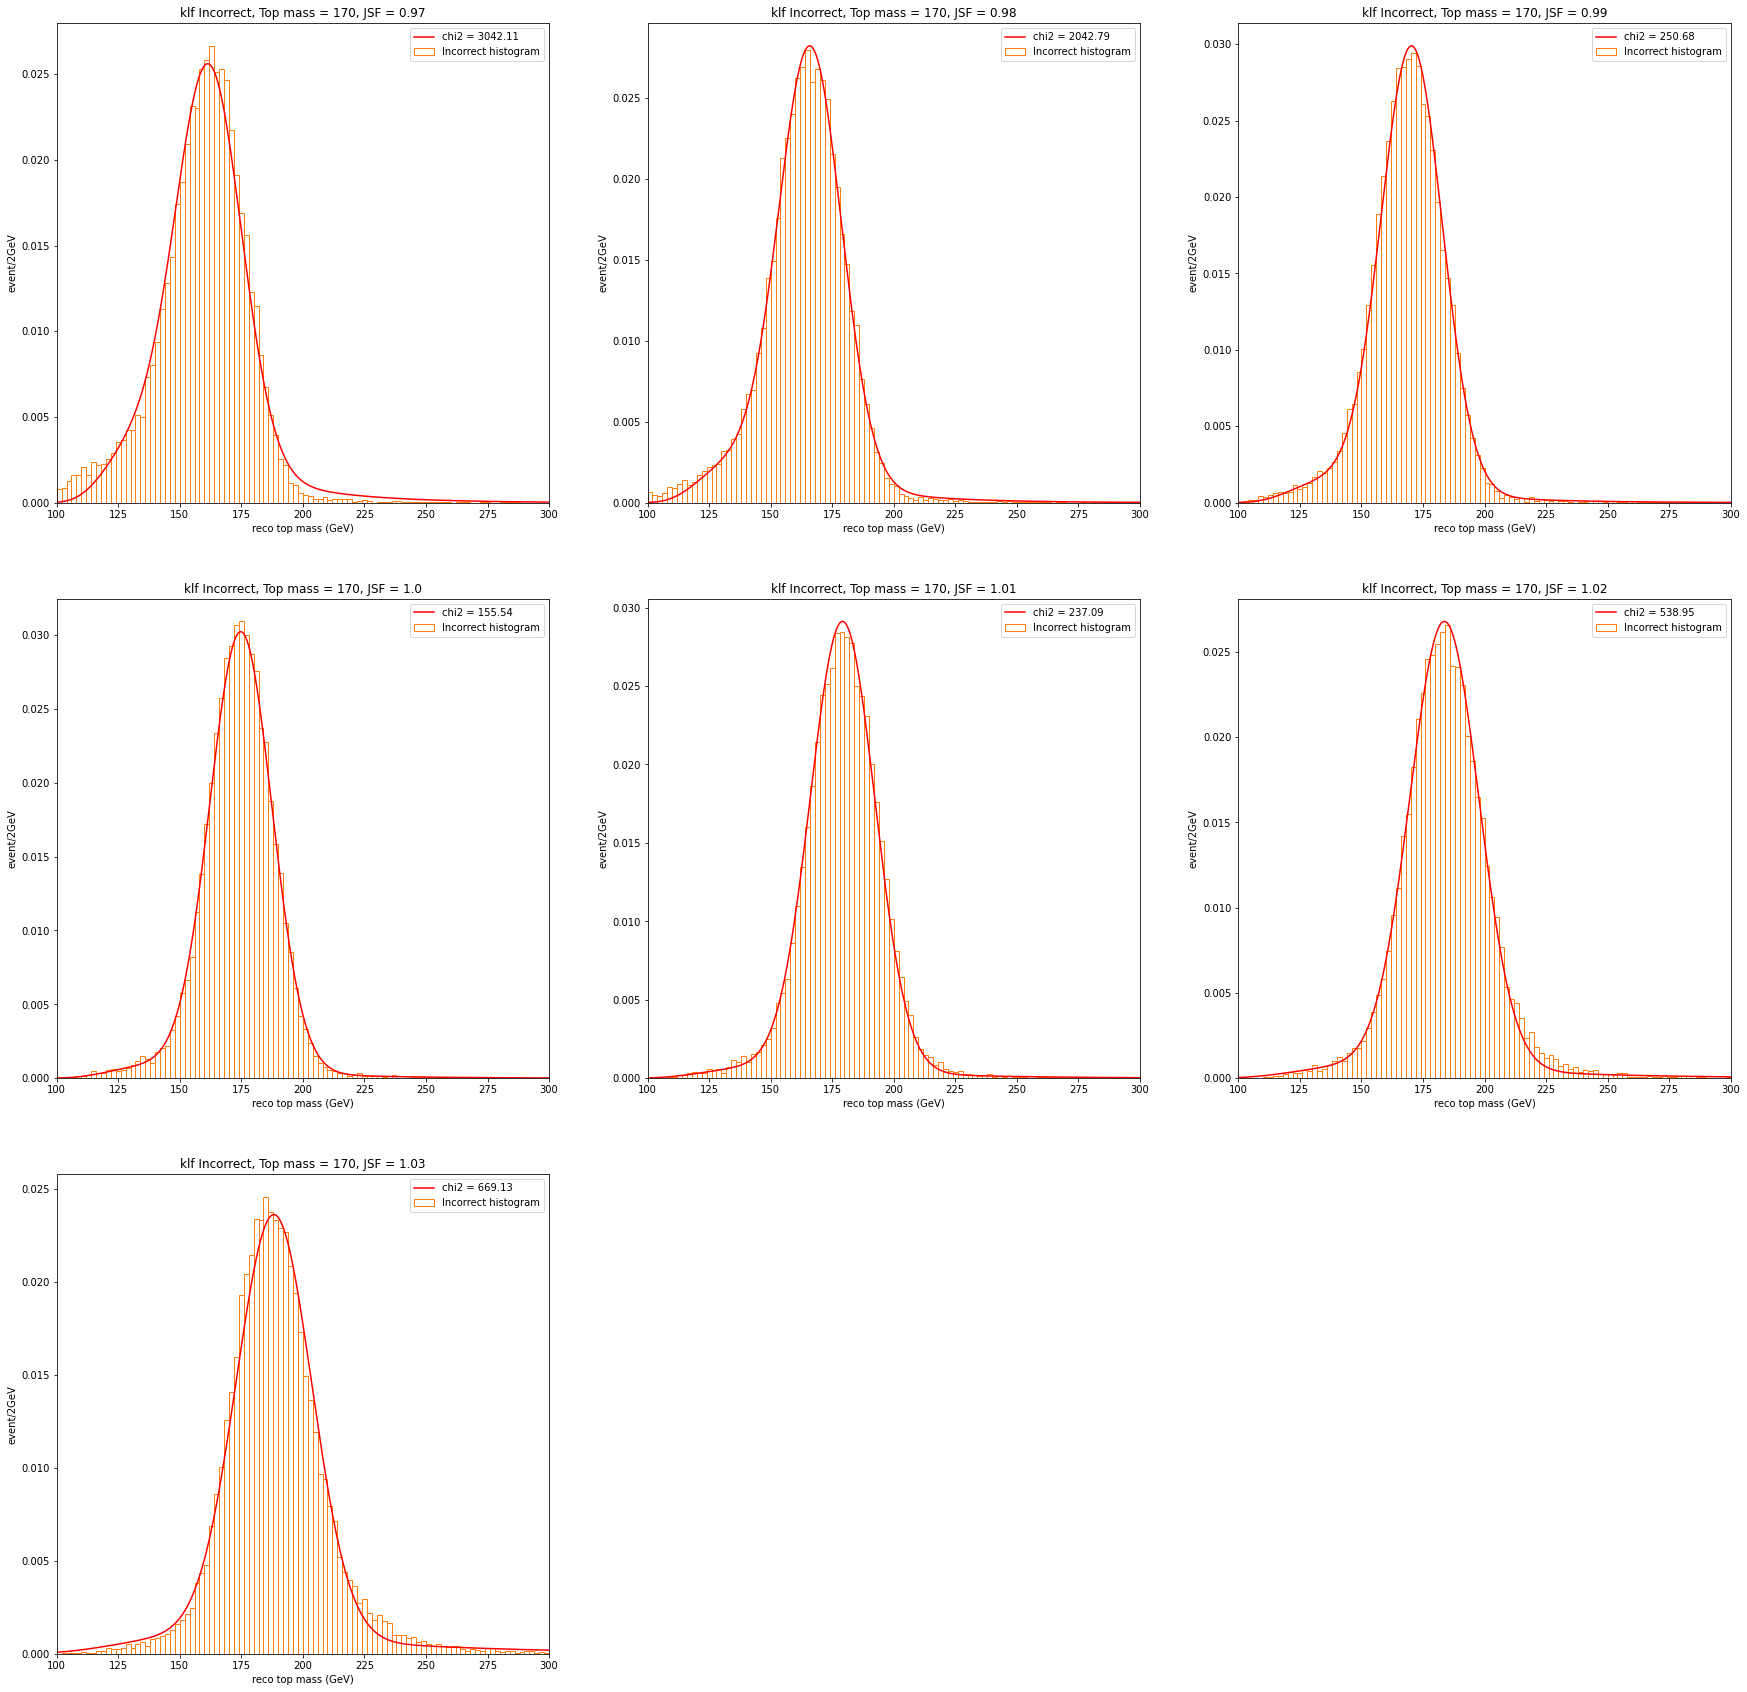

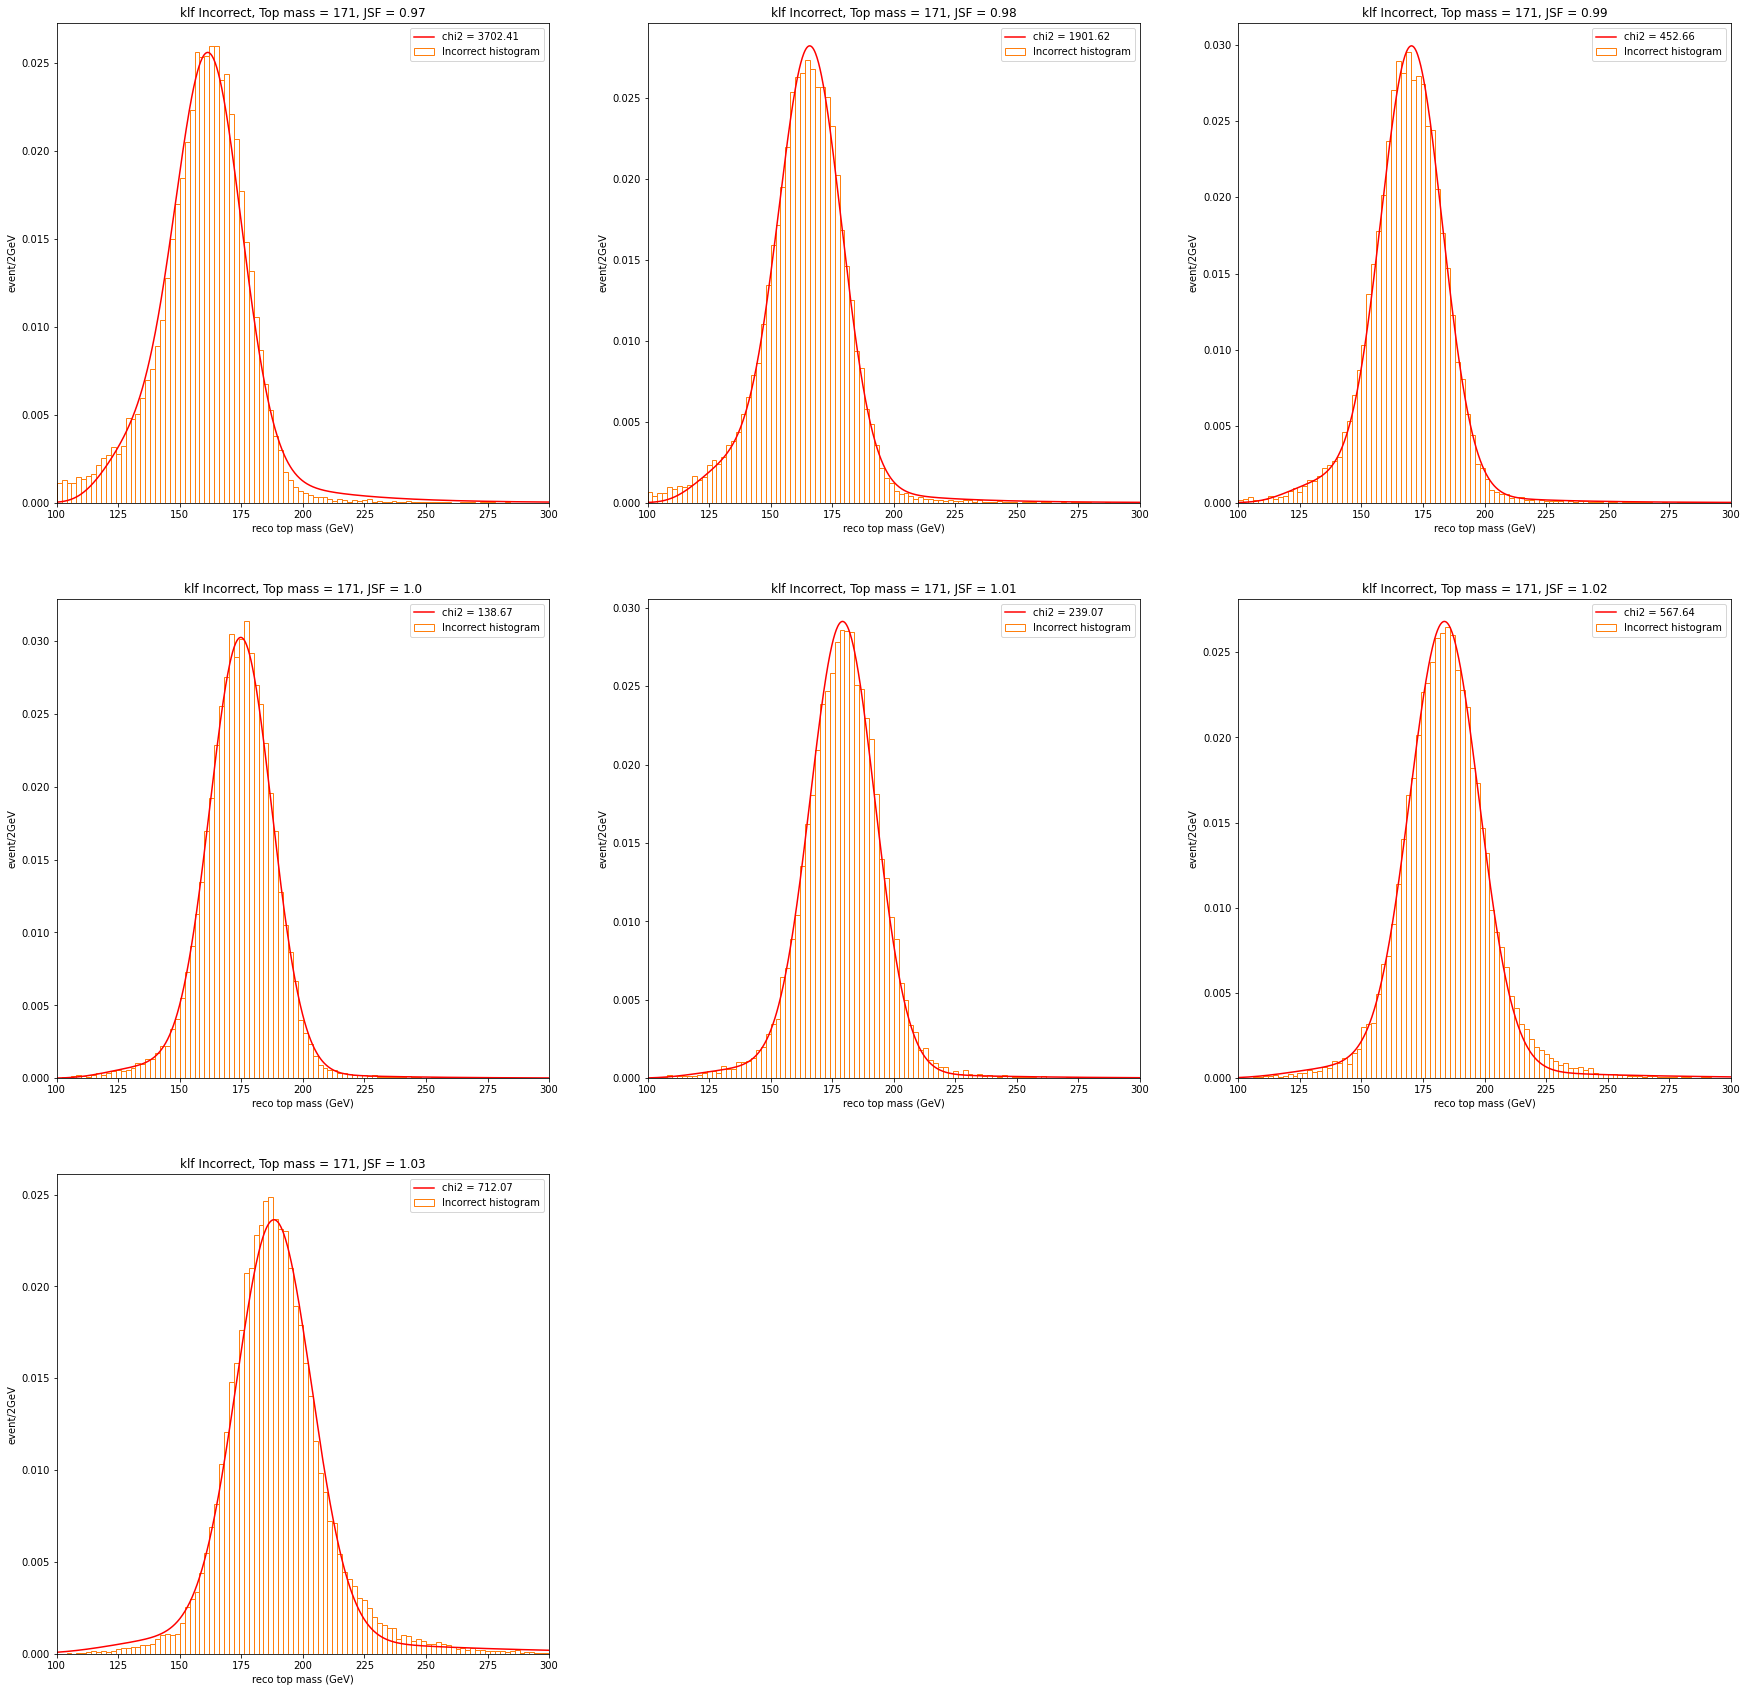

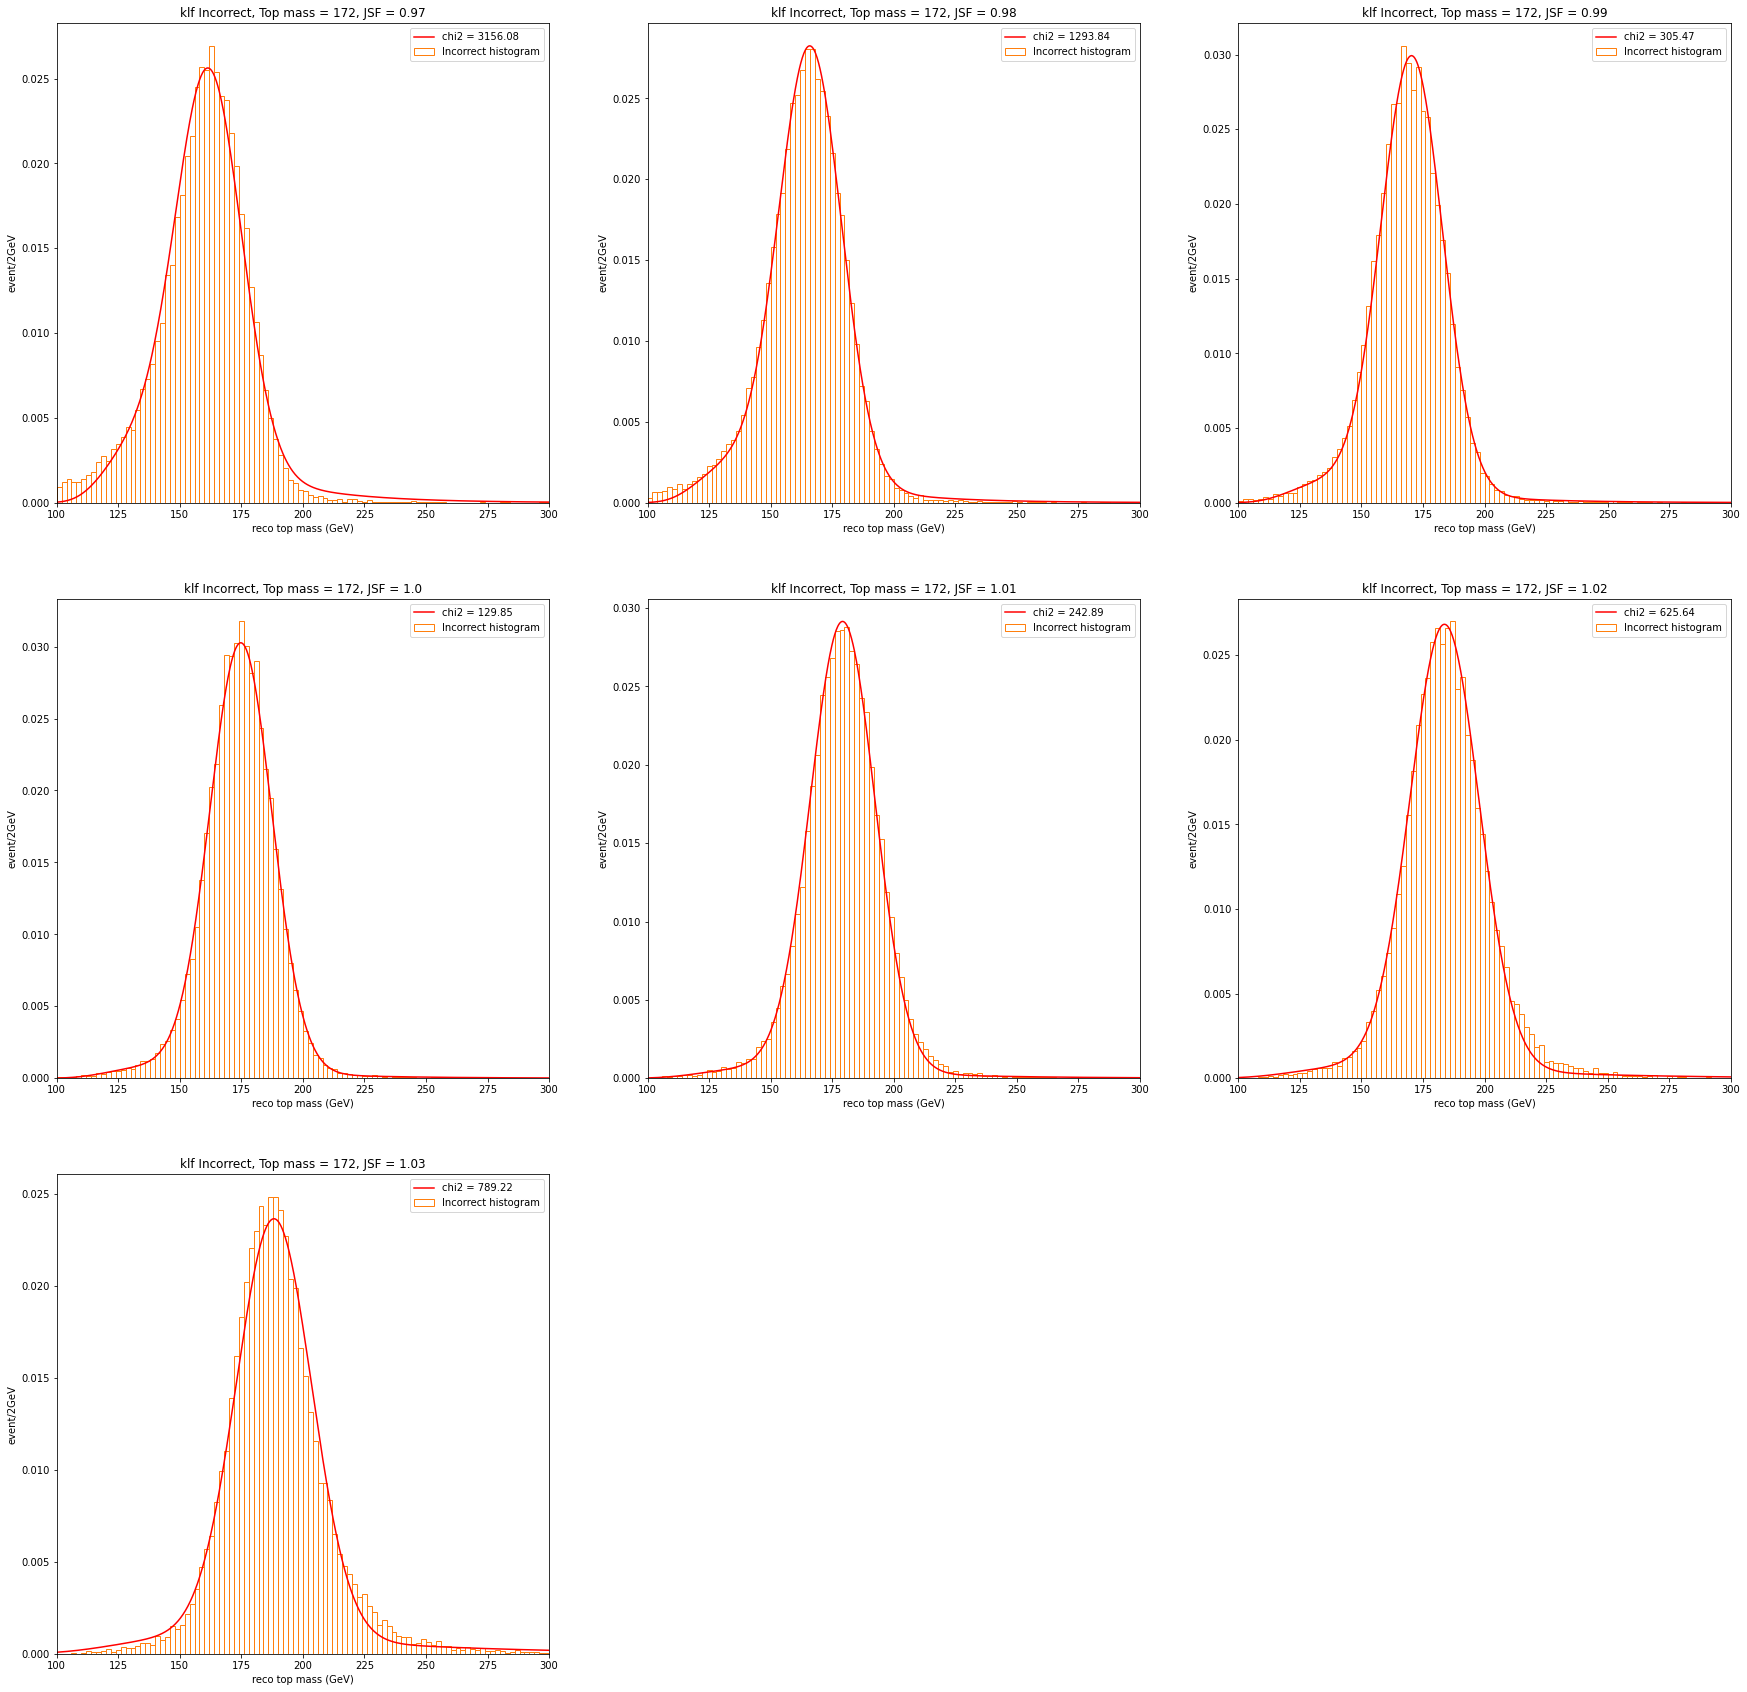

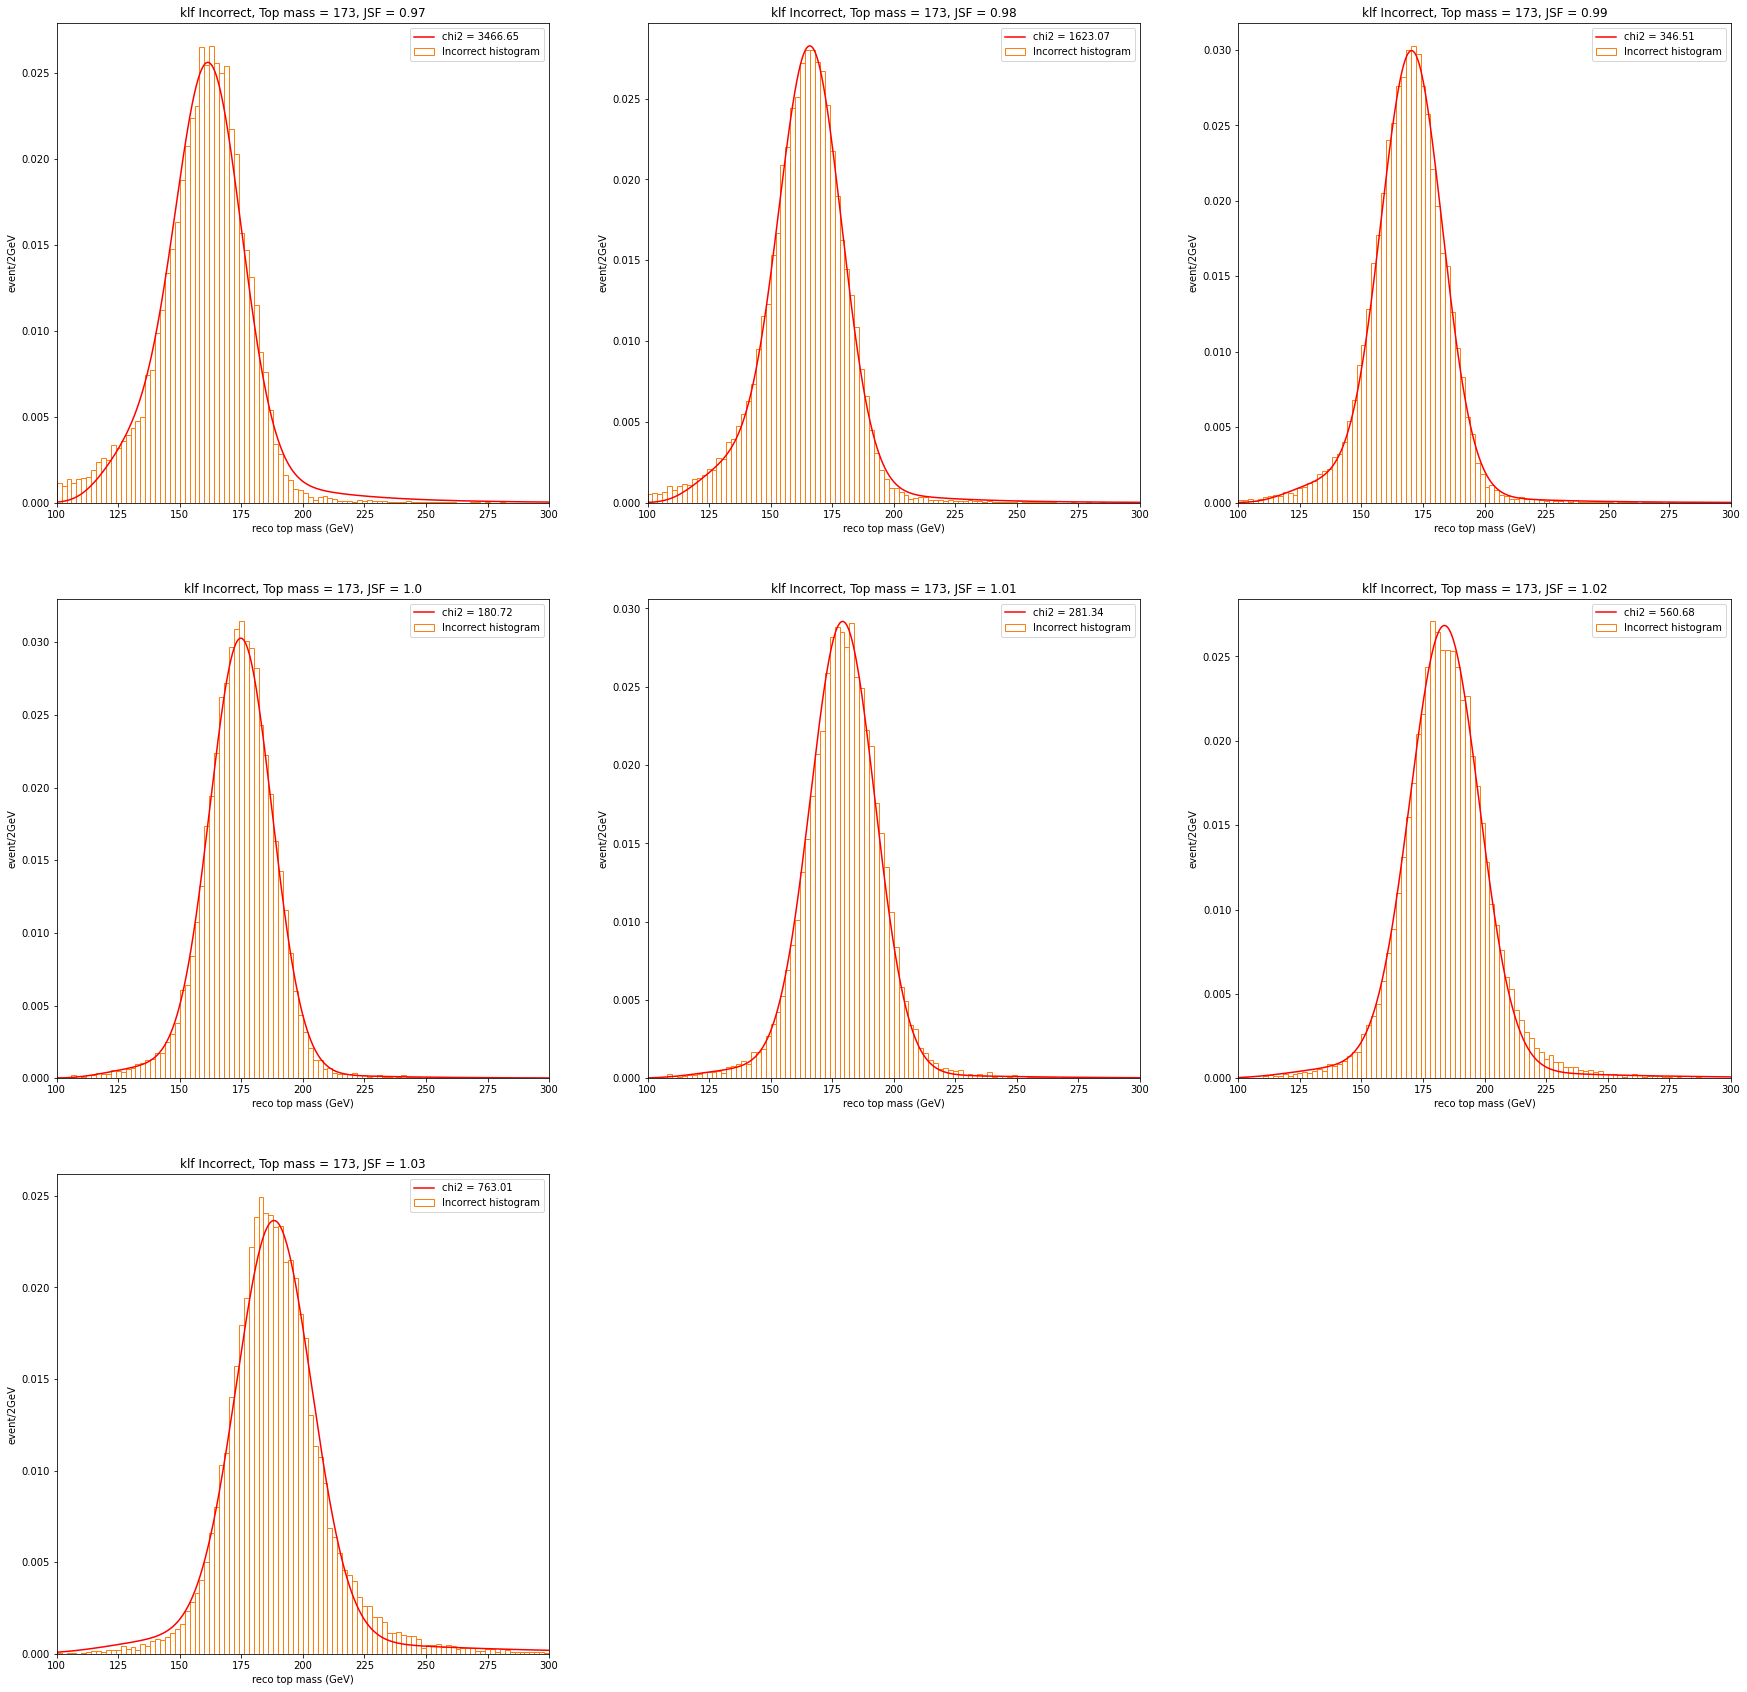

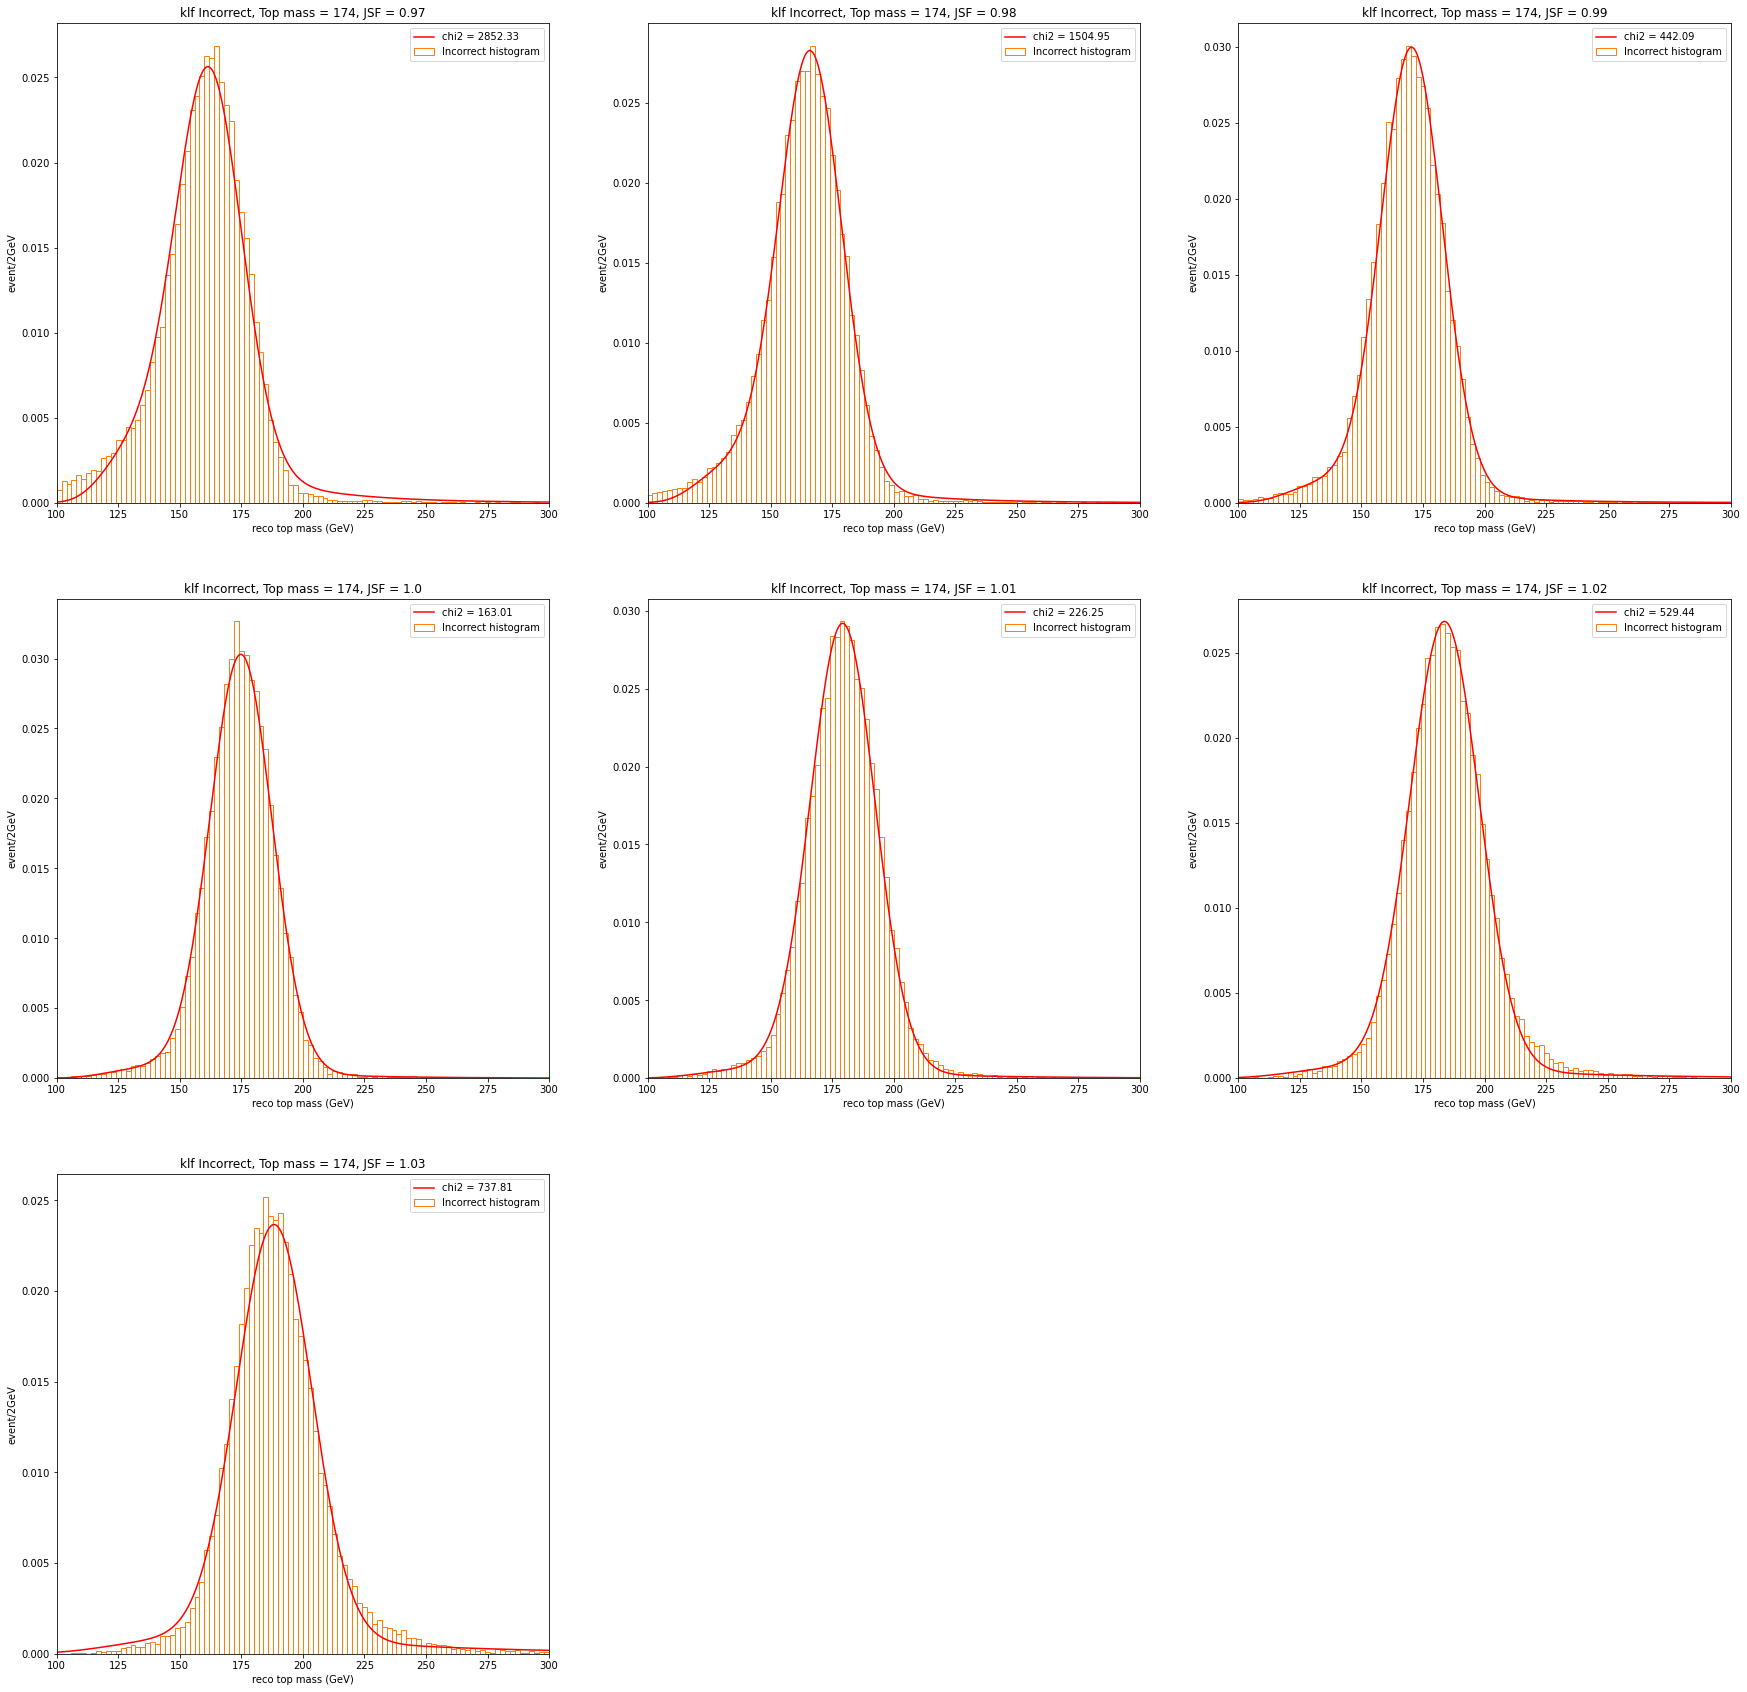

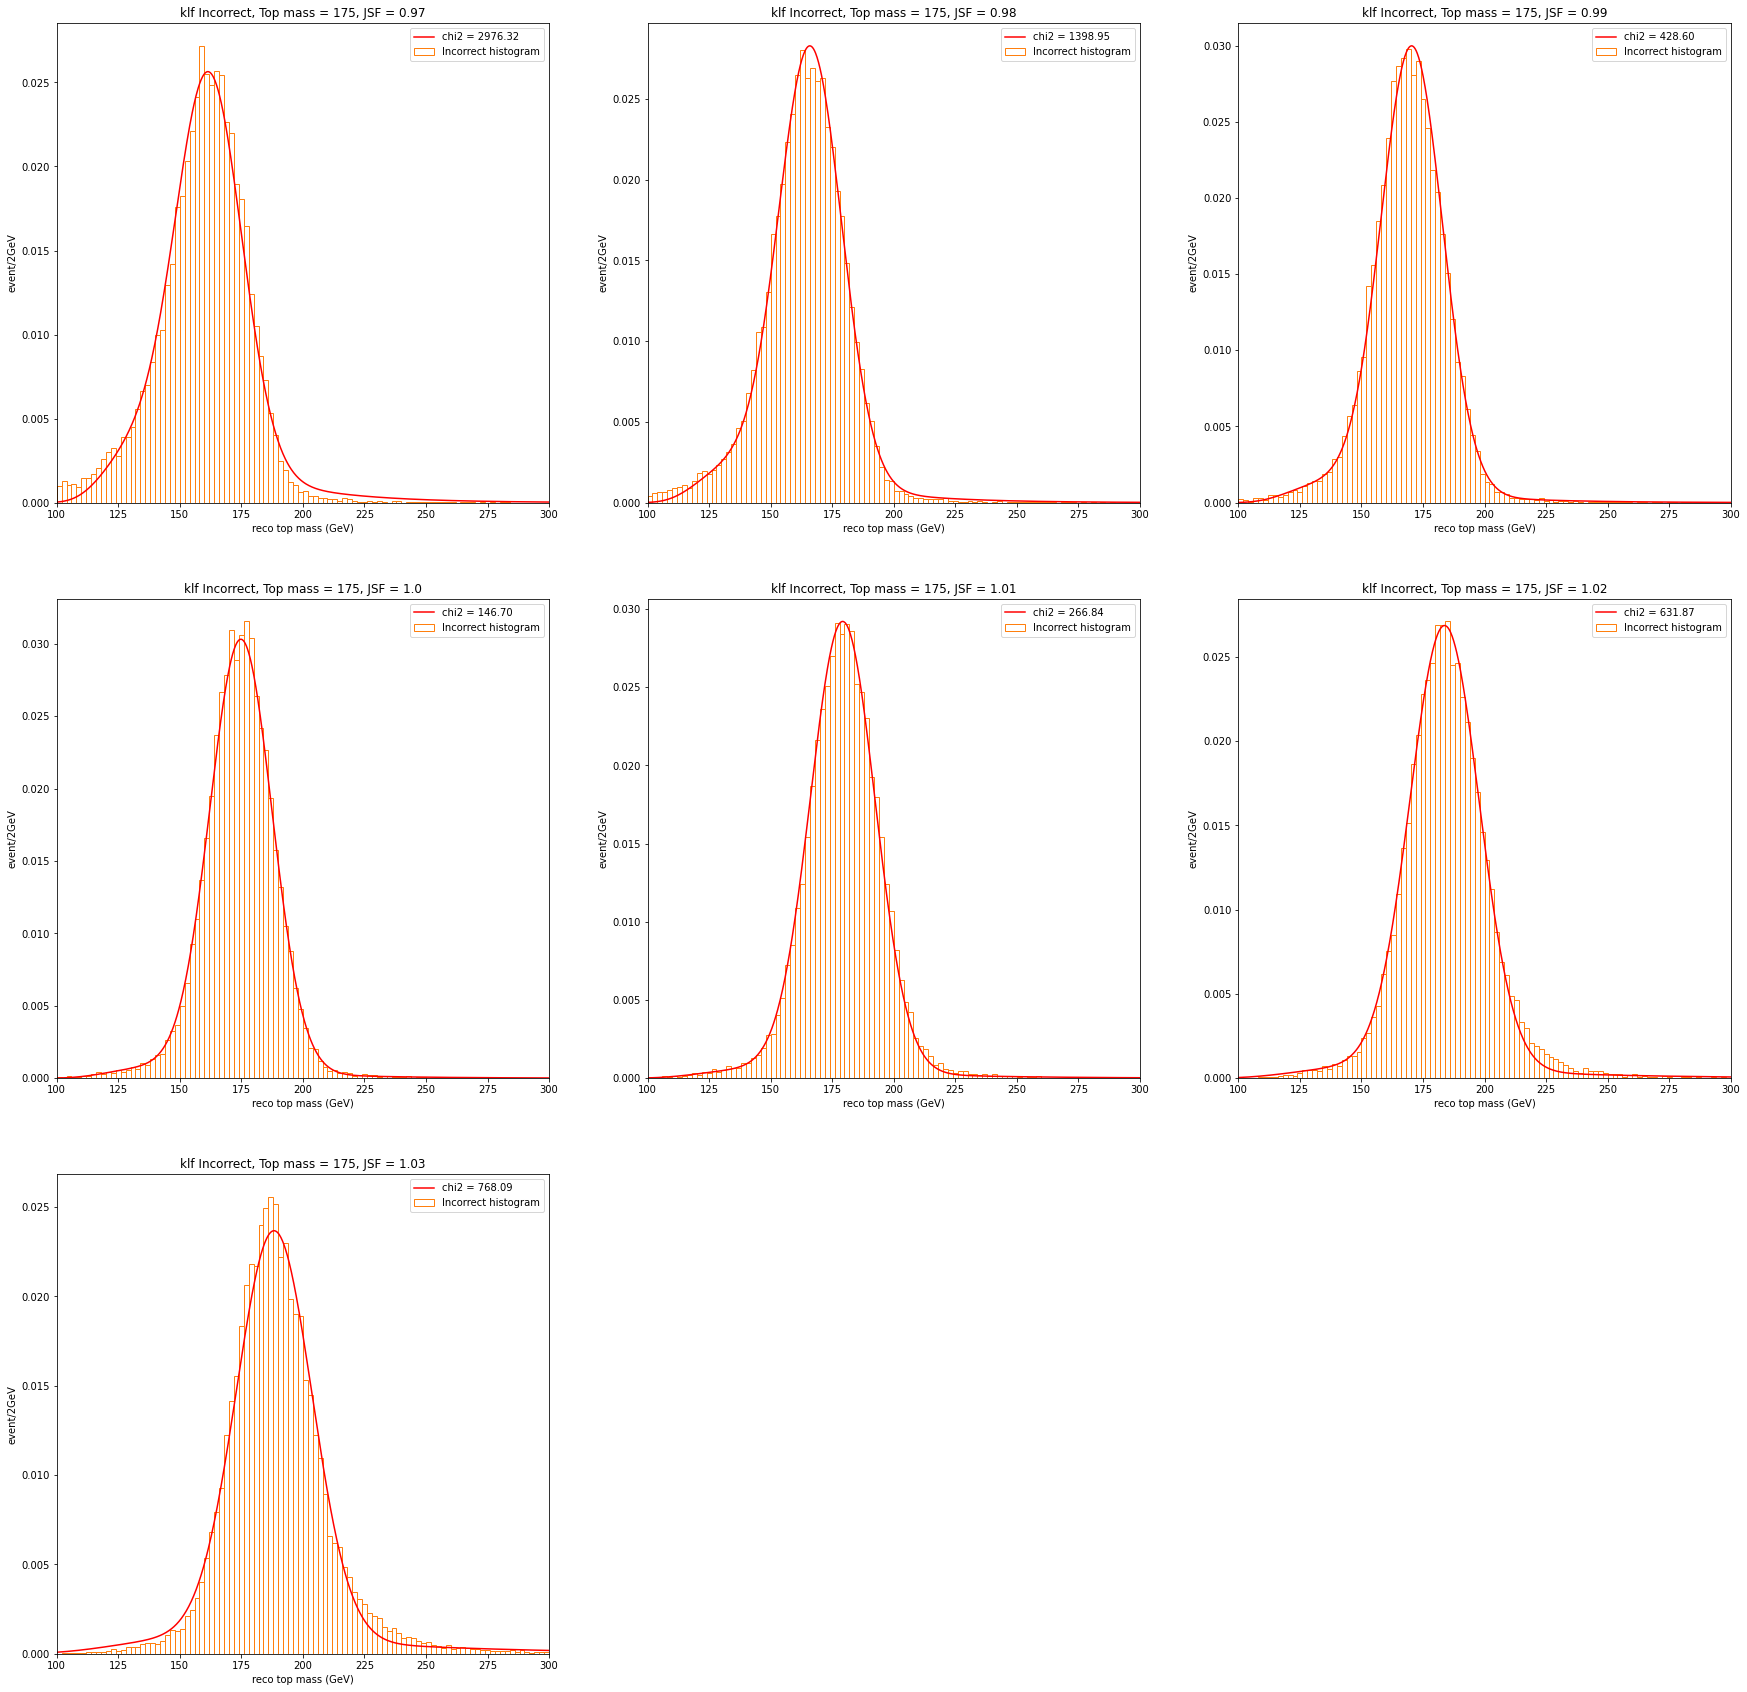

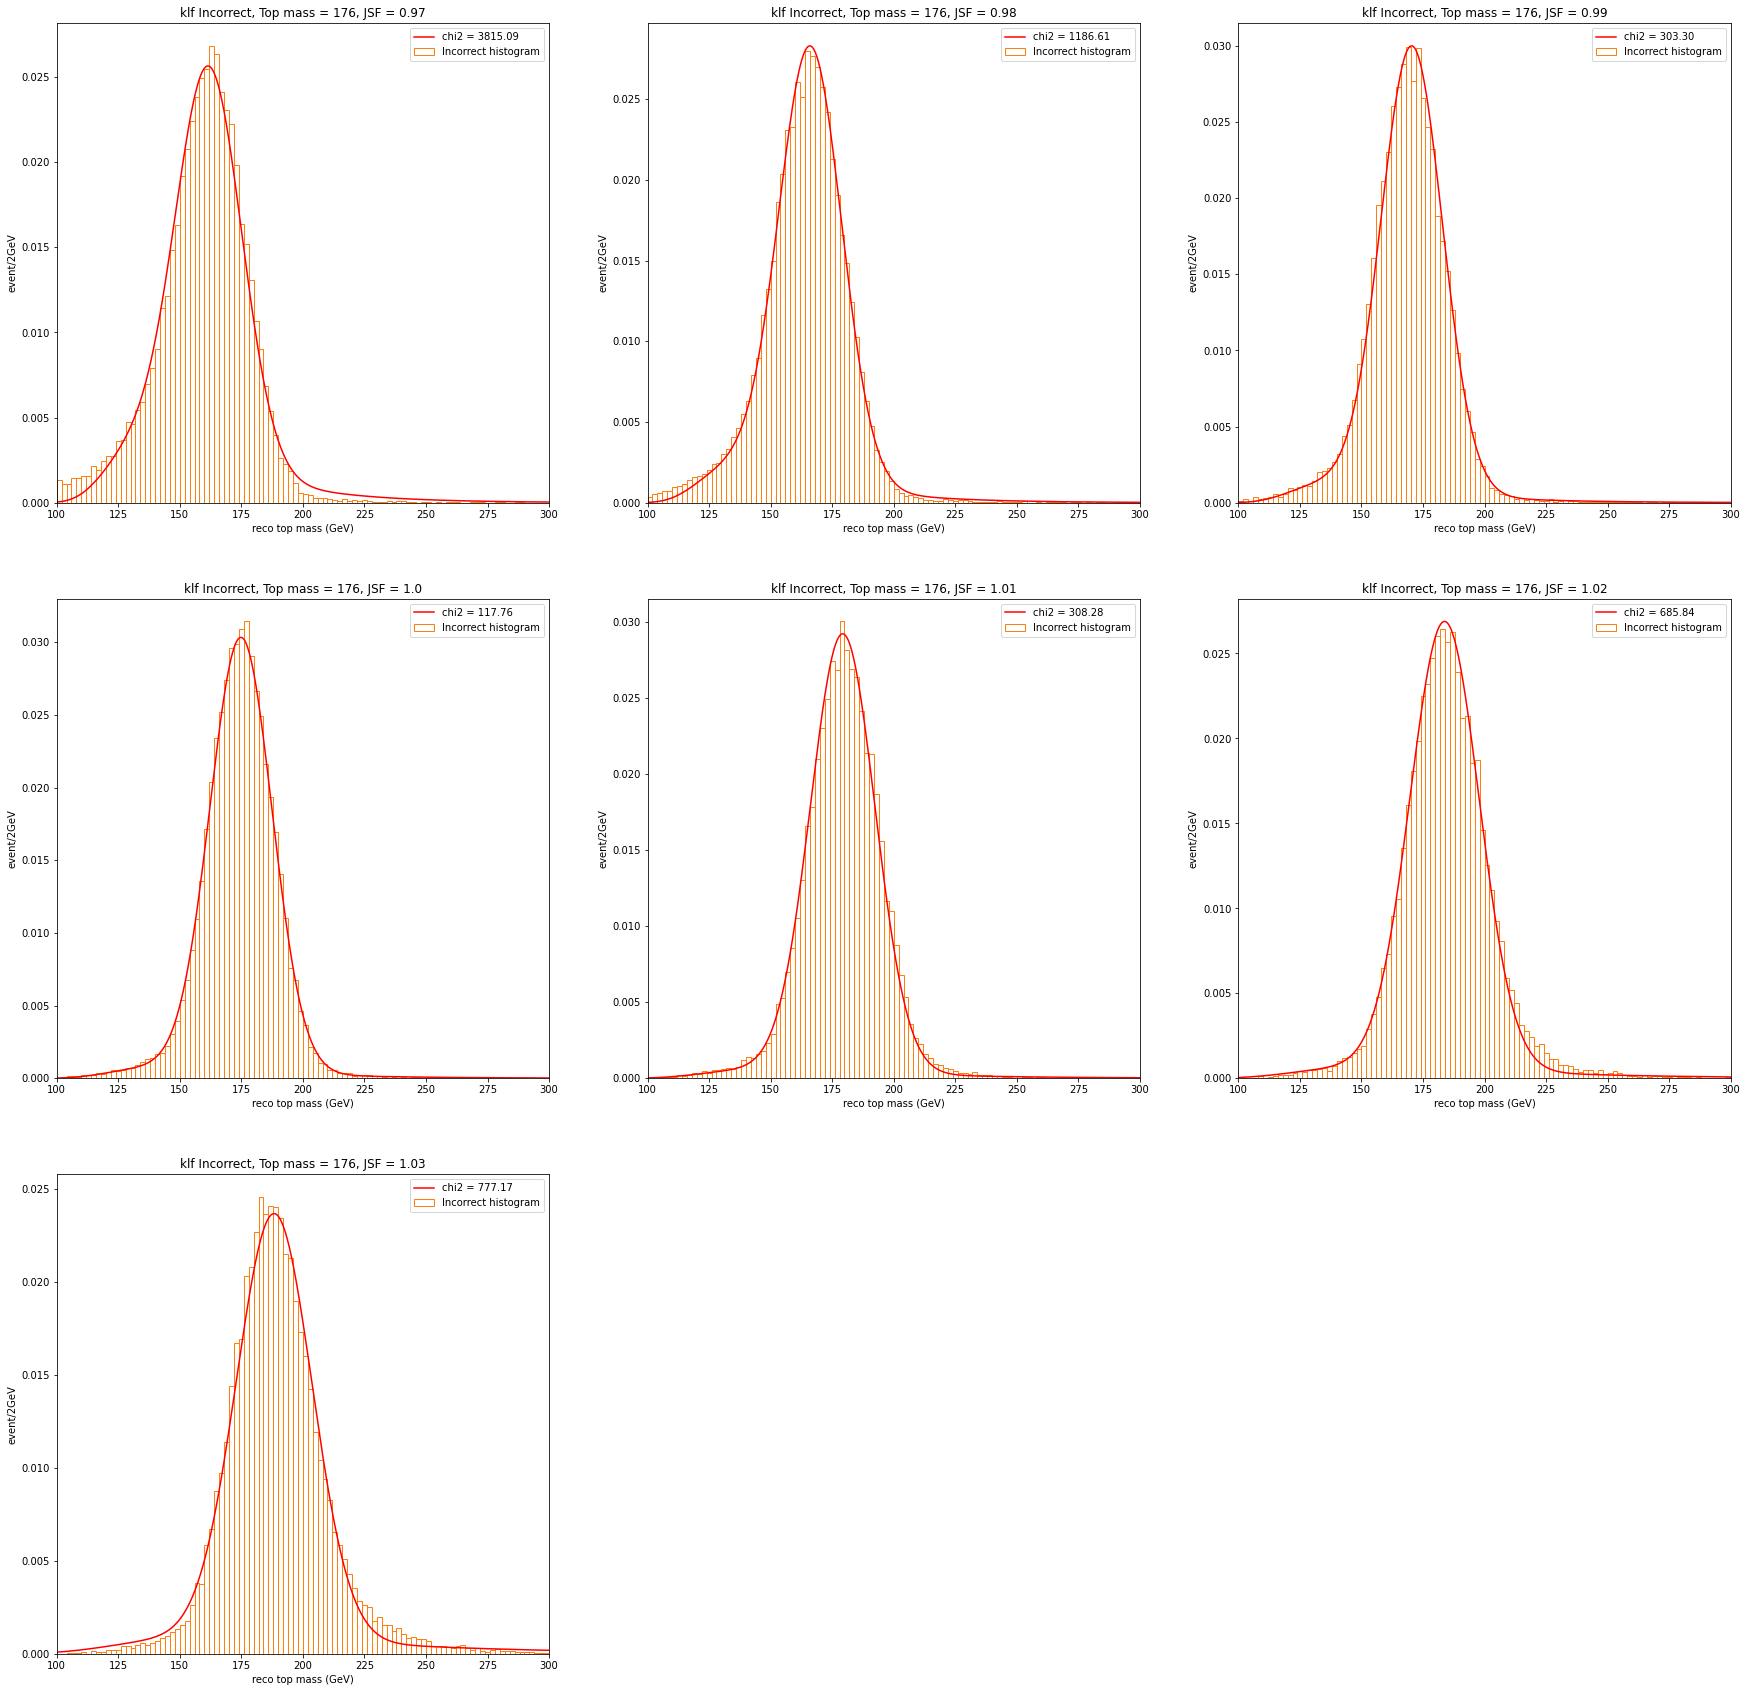

KeyboardInterrupt: 

In [37]:
# Compare the pdf to the original template
for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 30))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(3, 3, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>-70))]
            hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
            popt = [linear_parabola((m, JSF), *pdf_klf_dic[(state_i, j)]) for j in range(5)]
            # 2Gaussian for correct
            if state_i == 2:
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+1, *popt))
            
            # Landau + Gaussian for incorrect and unmatch
            else:
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+1, *popt))

            plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=2, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.xlim(100, 300)
            plt.title('klf {}, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend()
        plt.show()

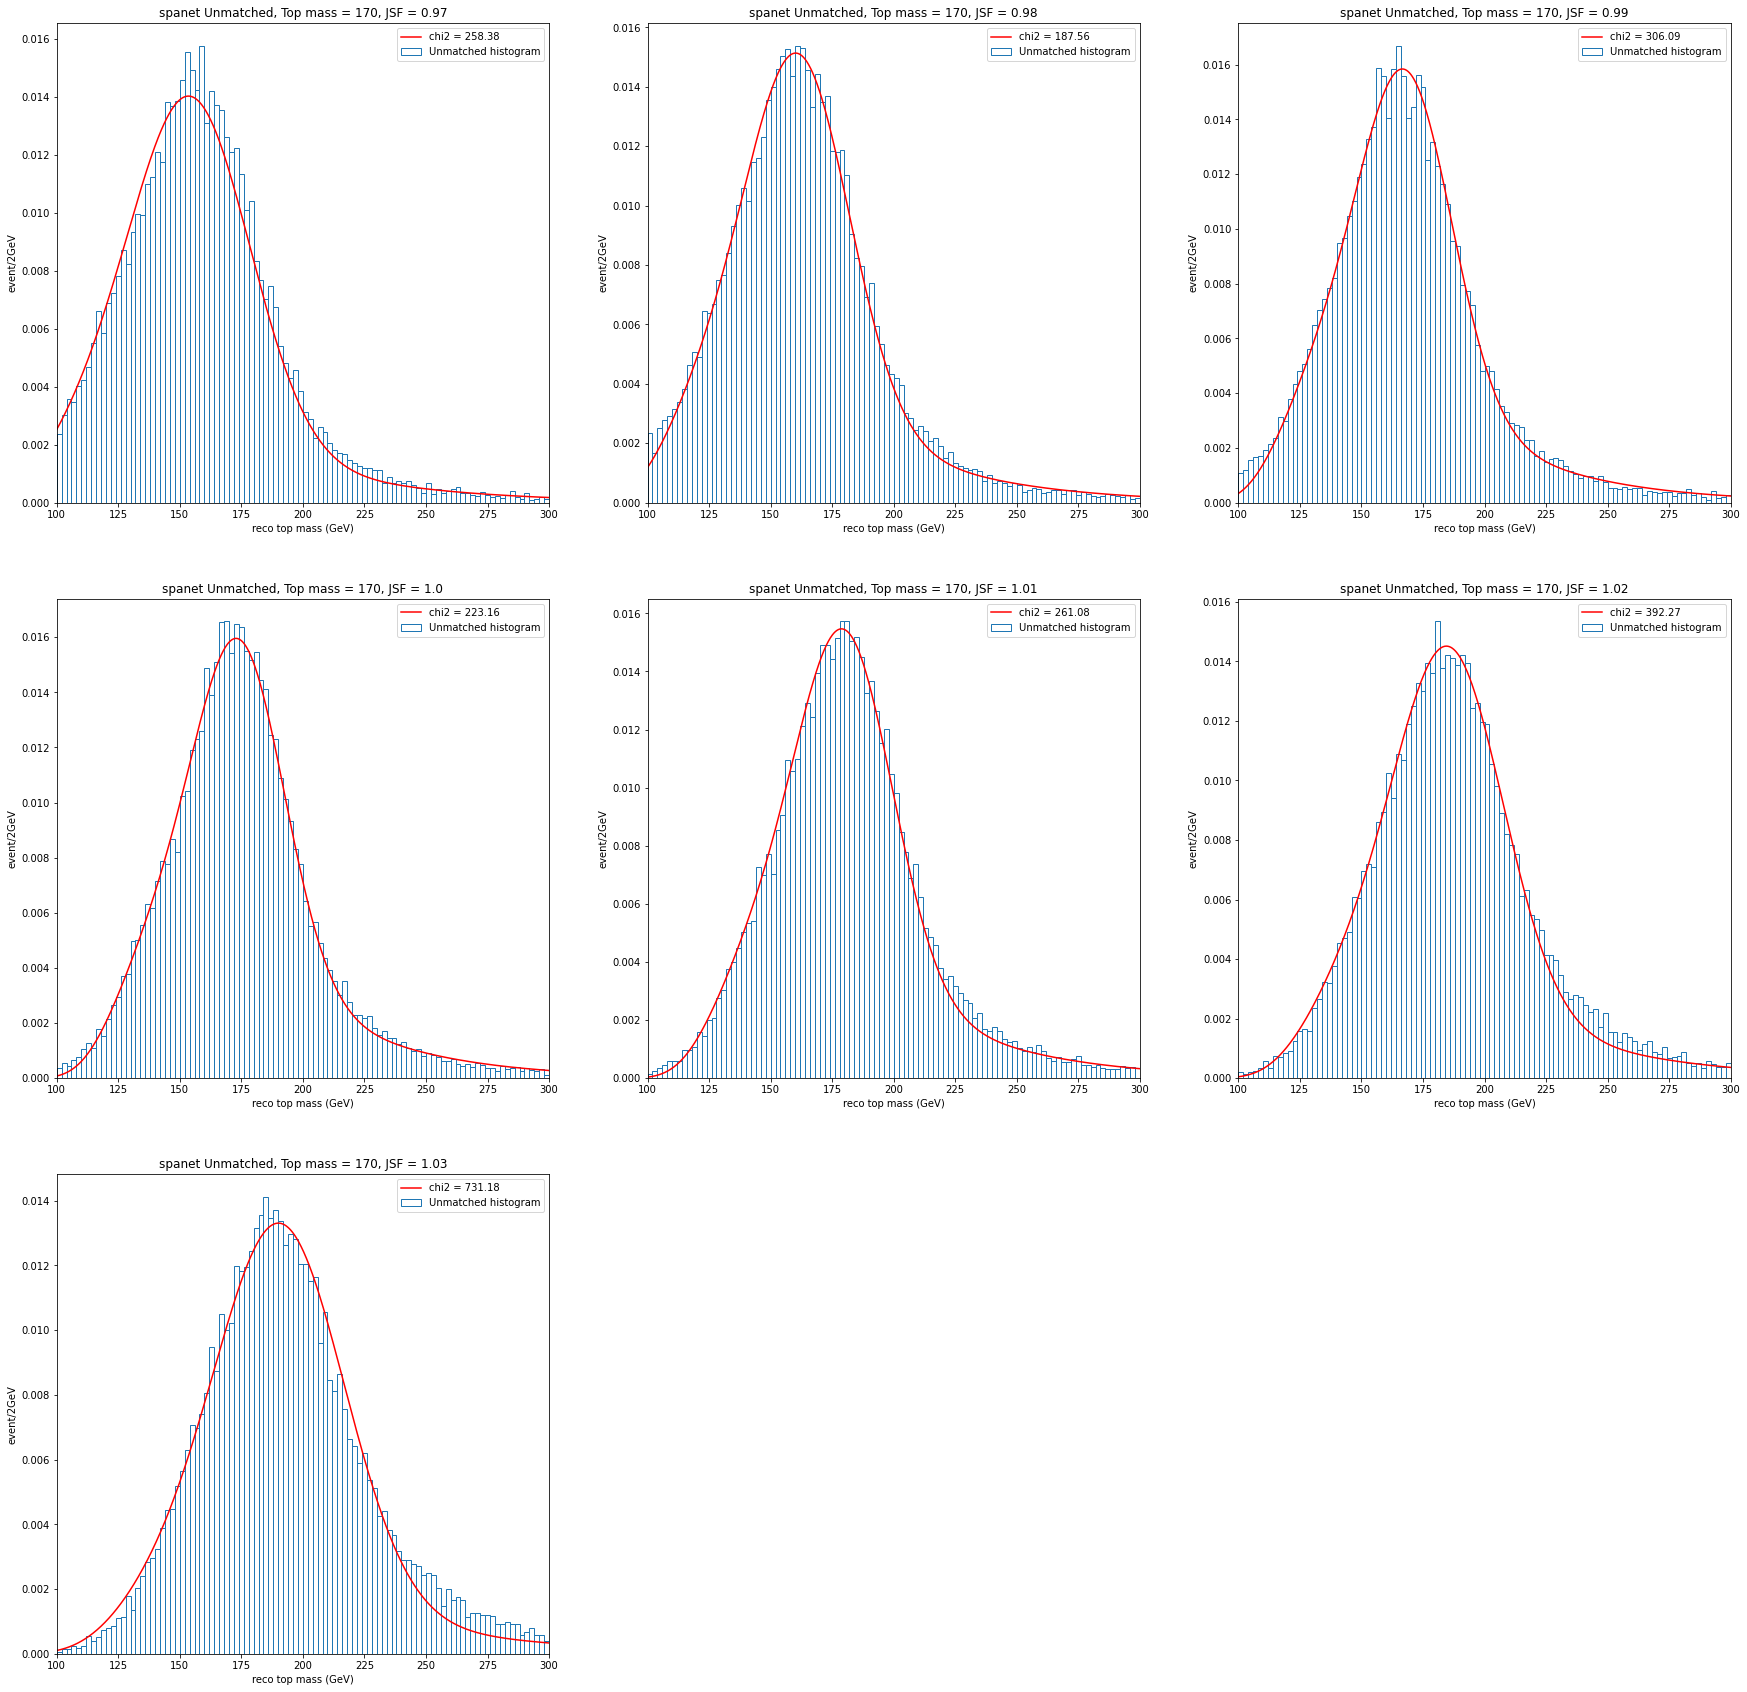

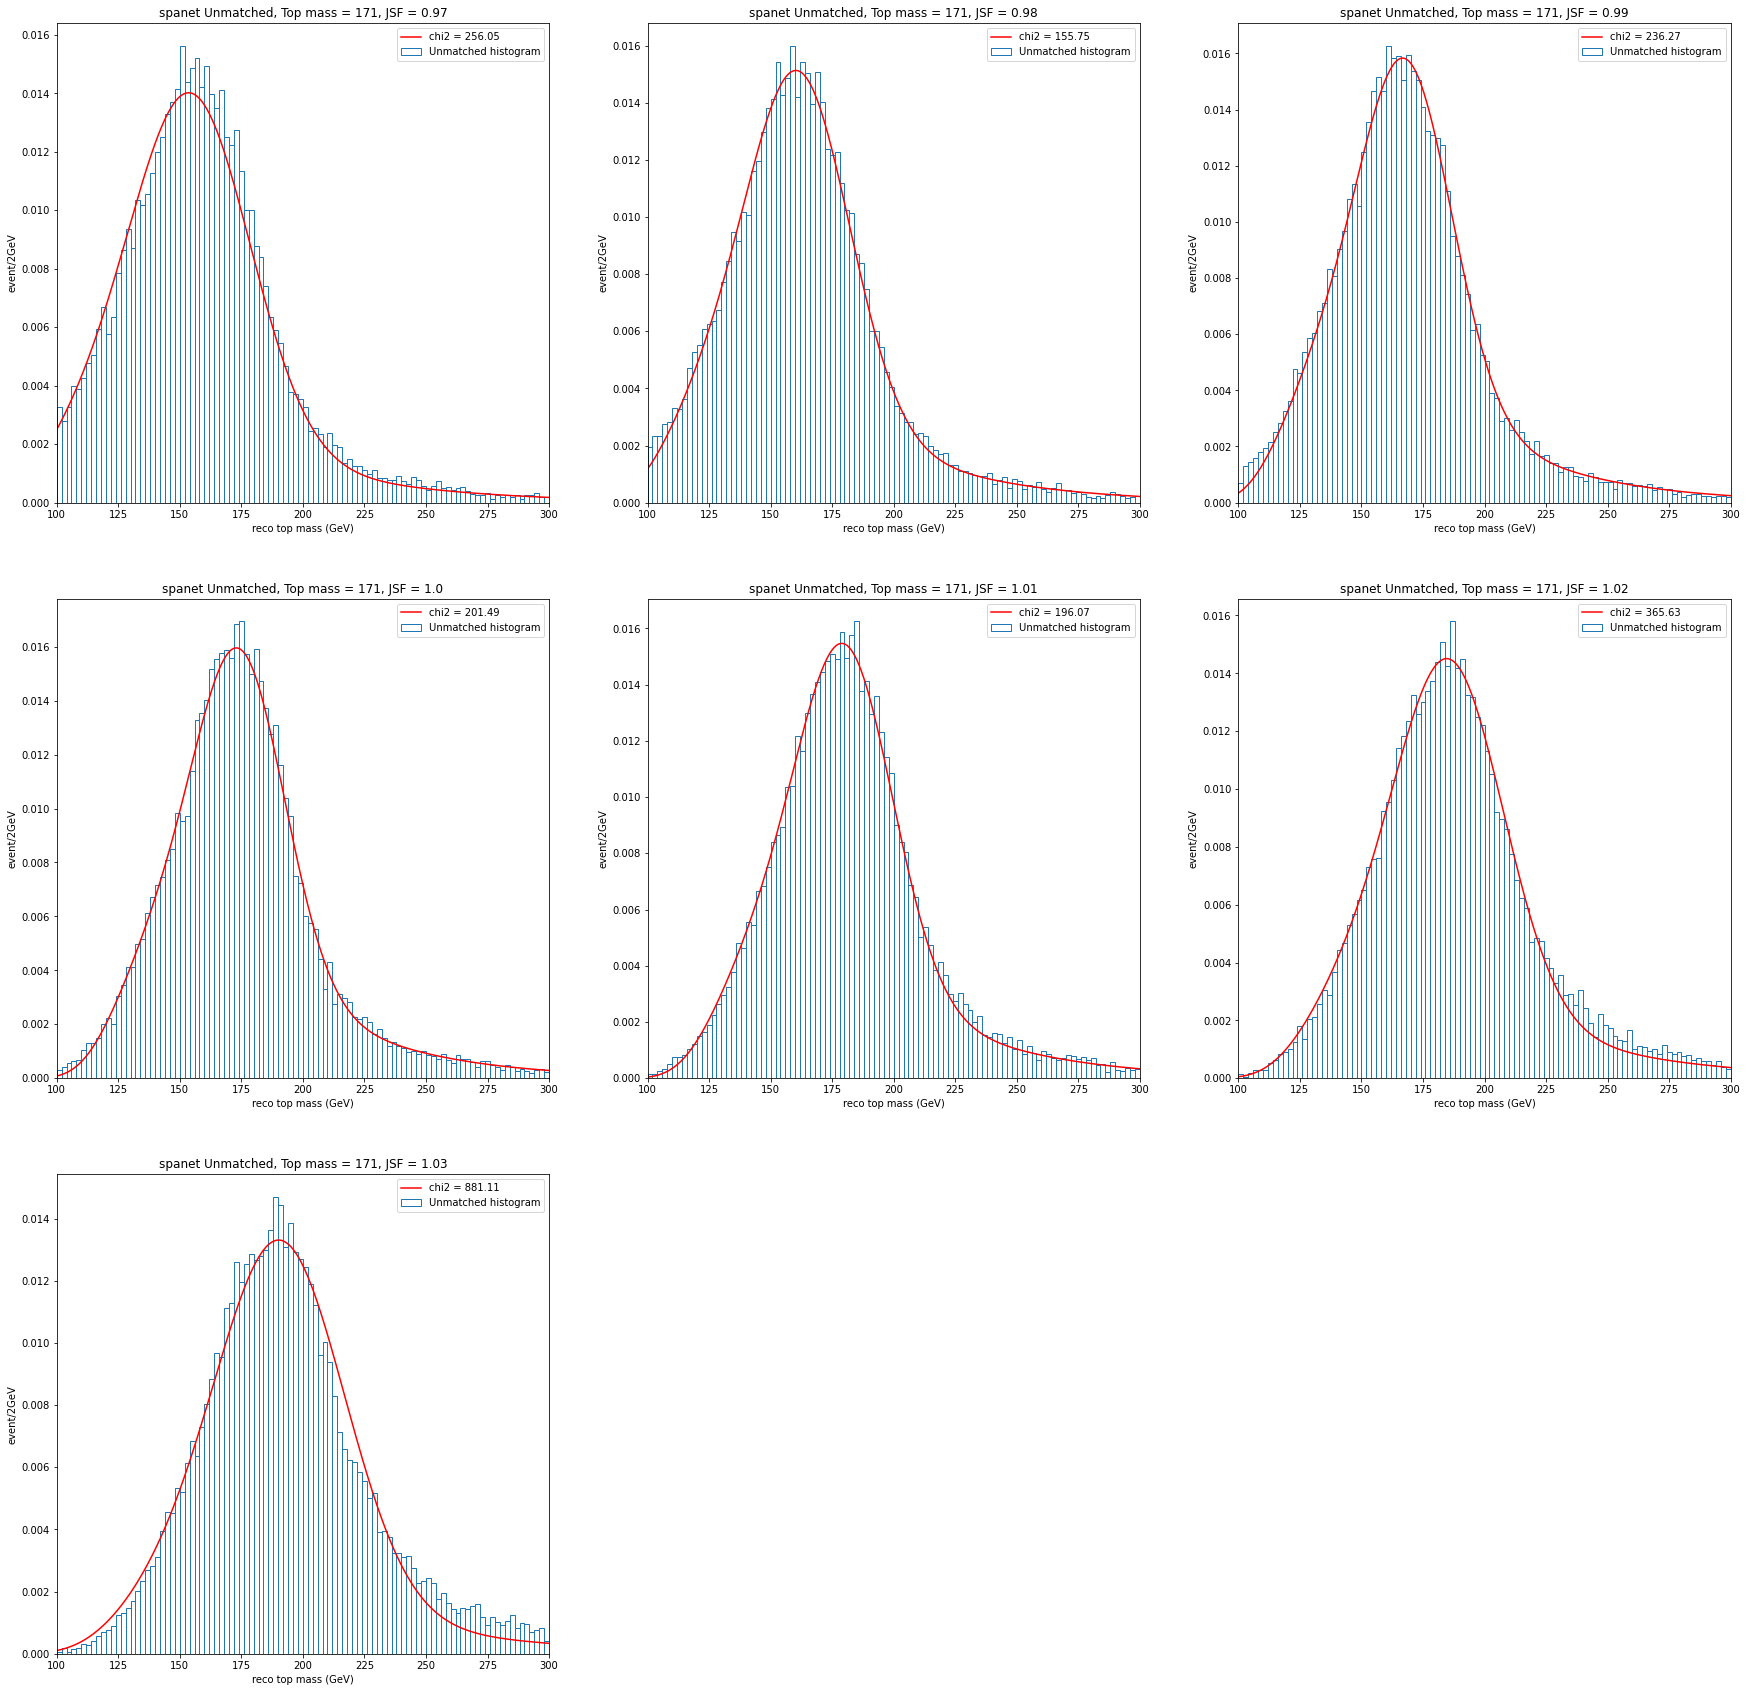

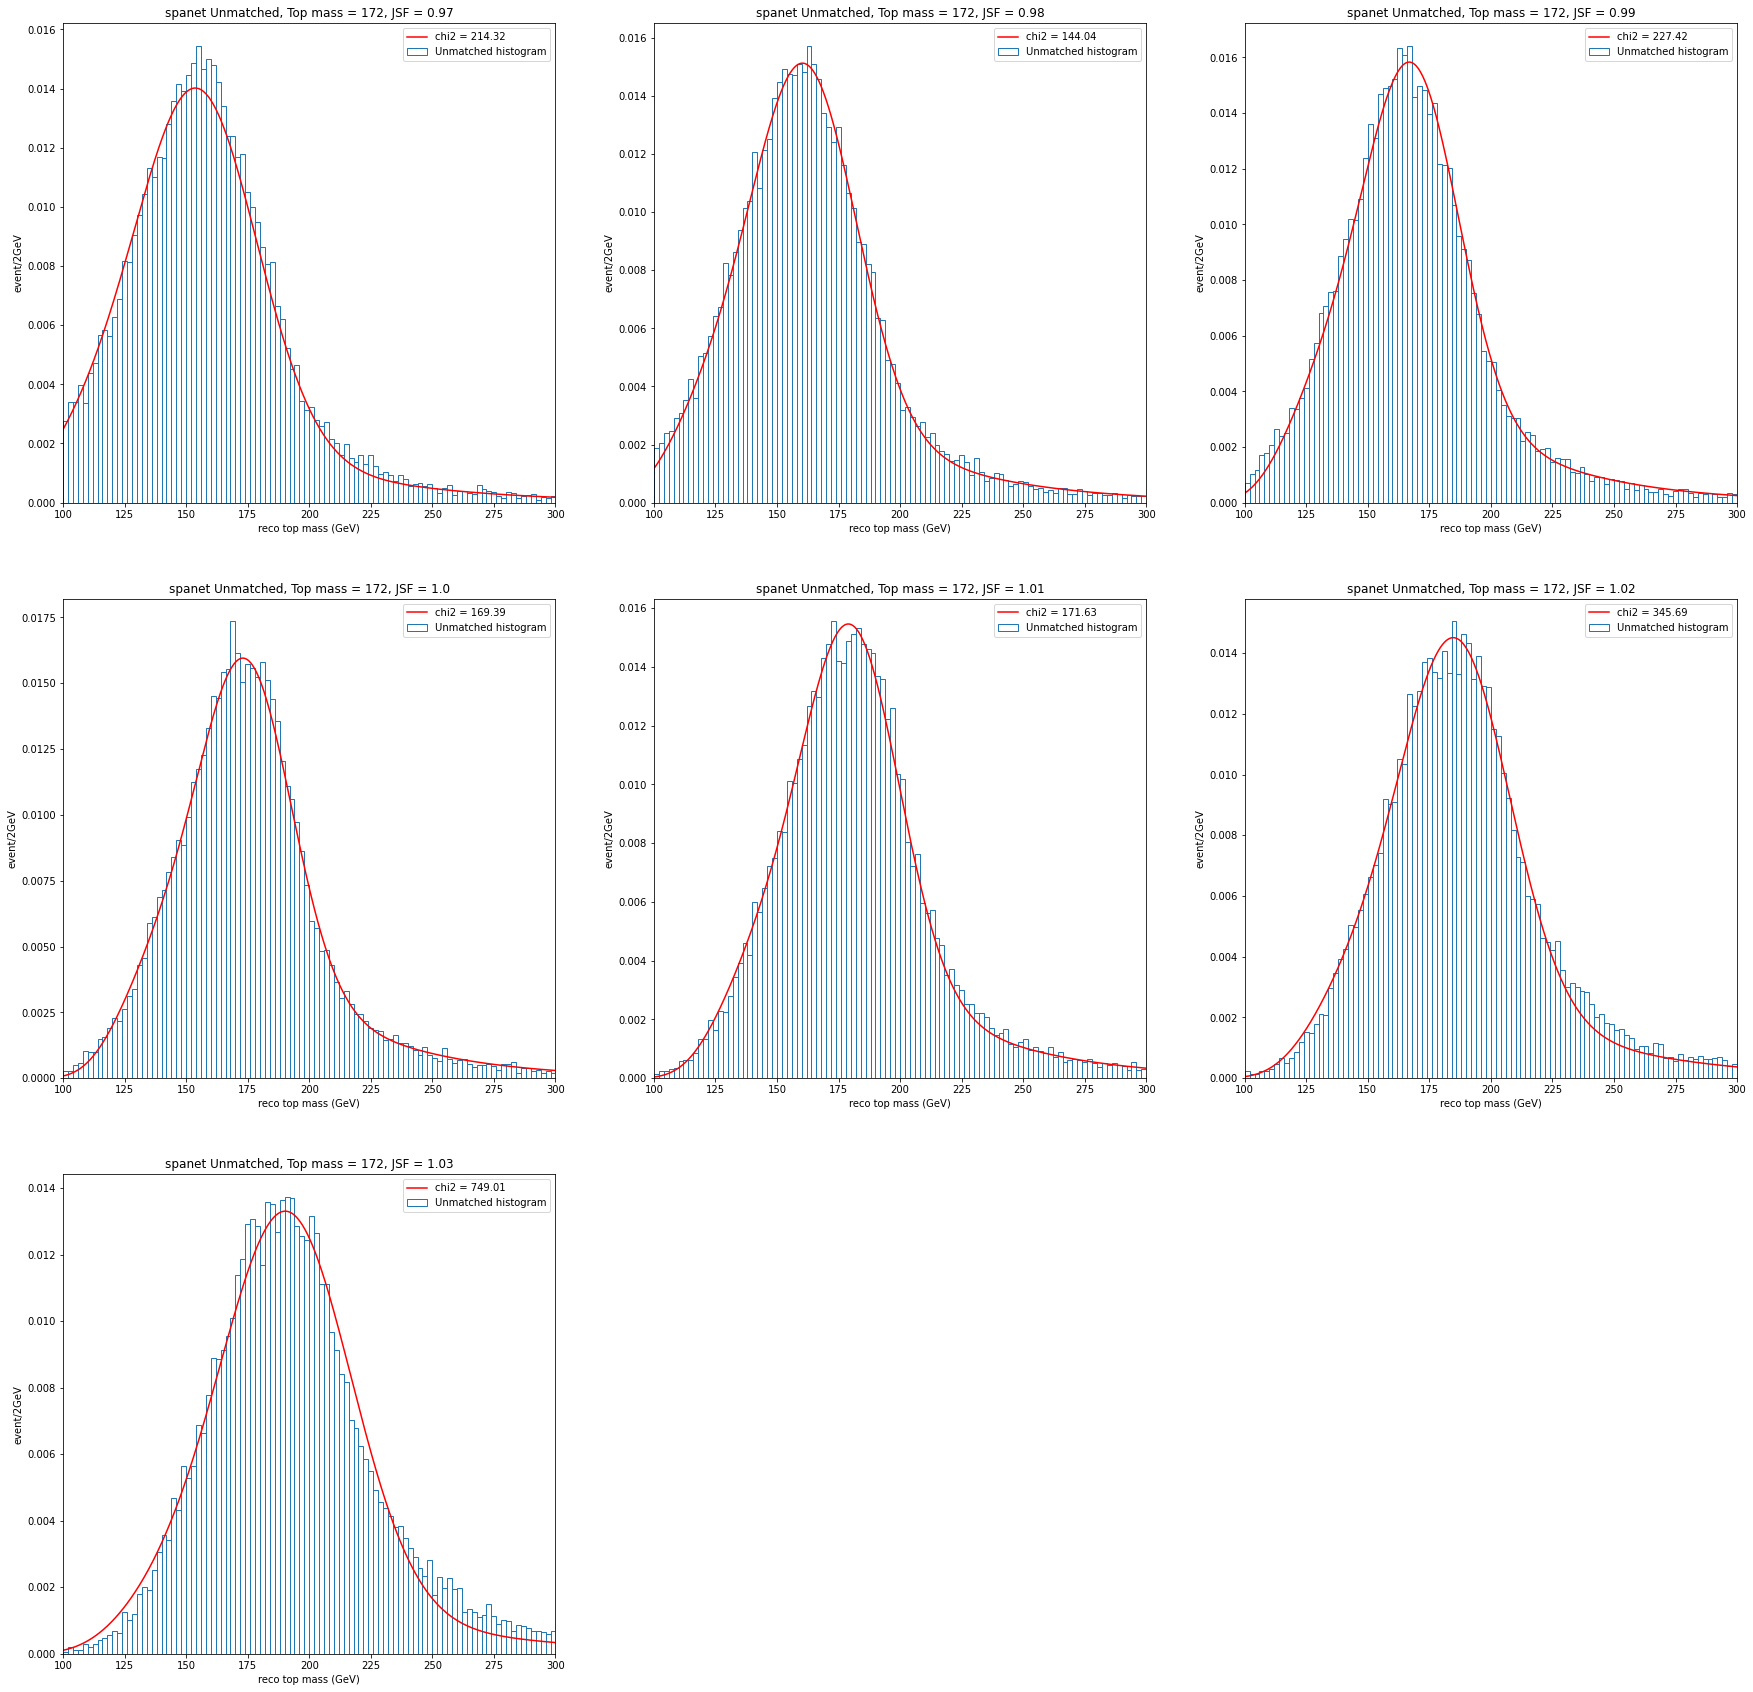

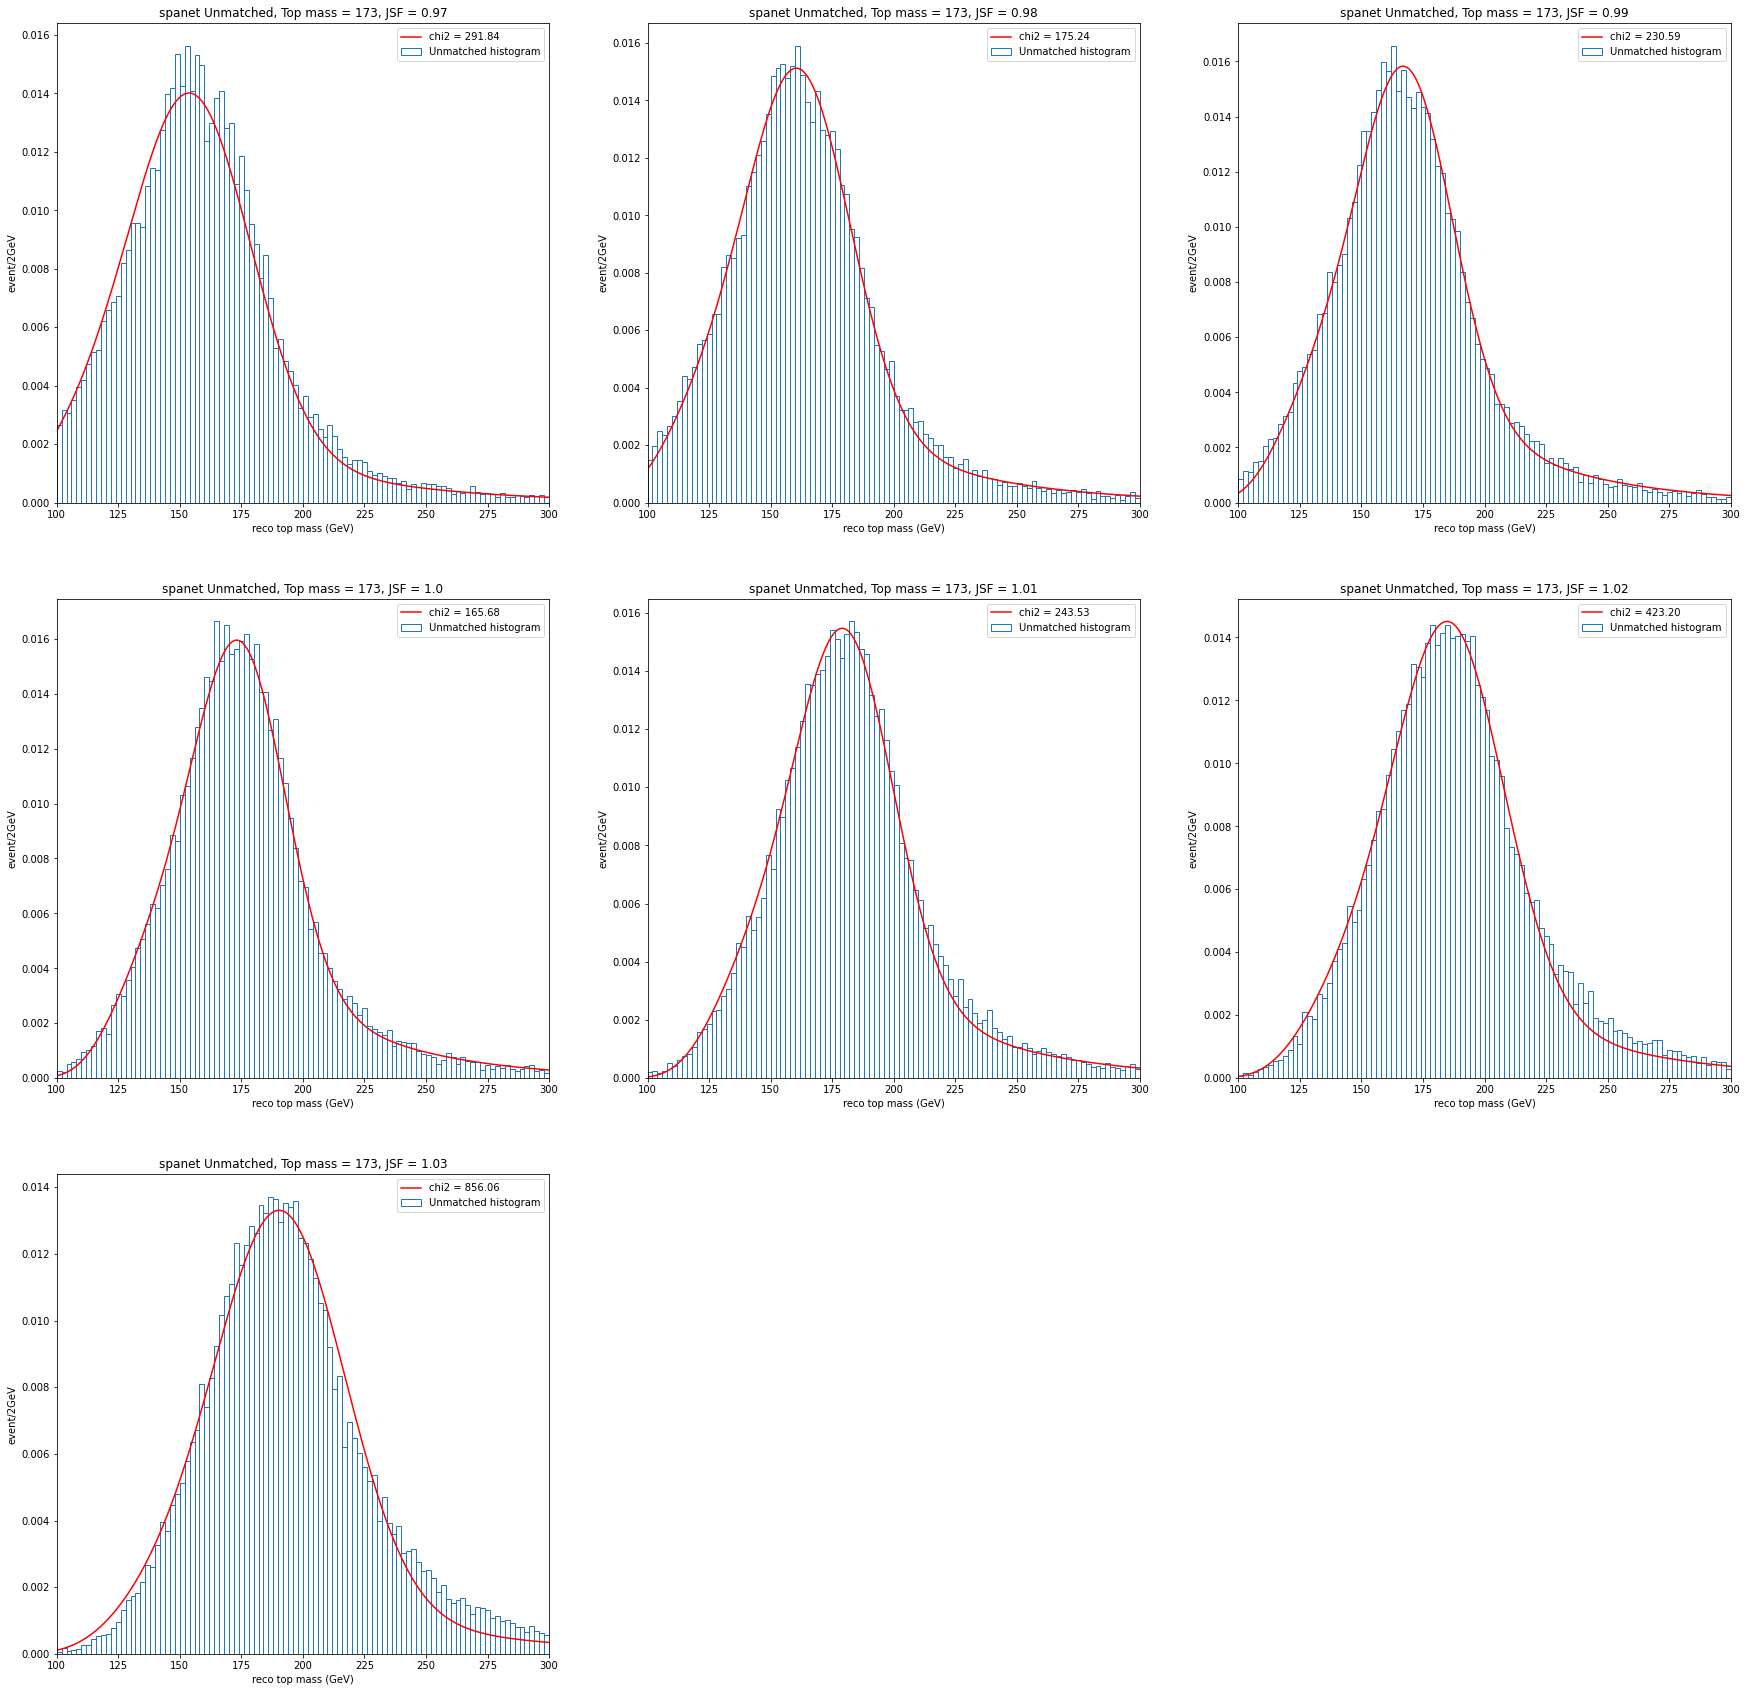

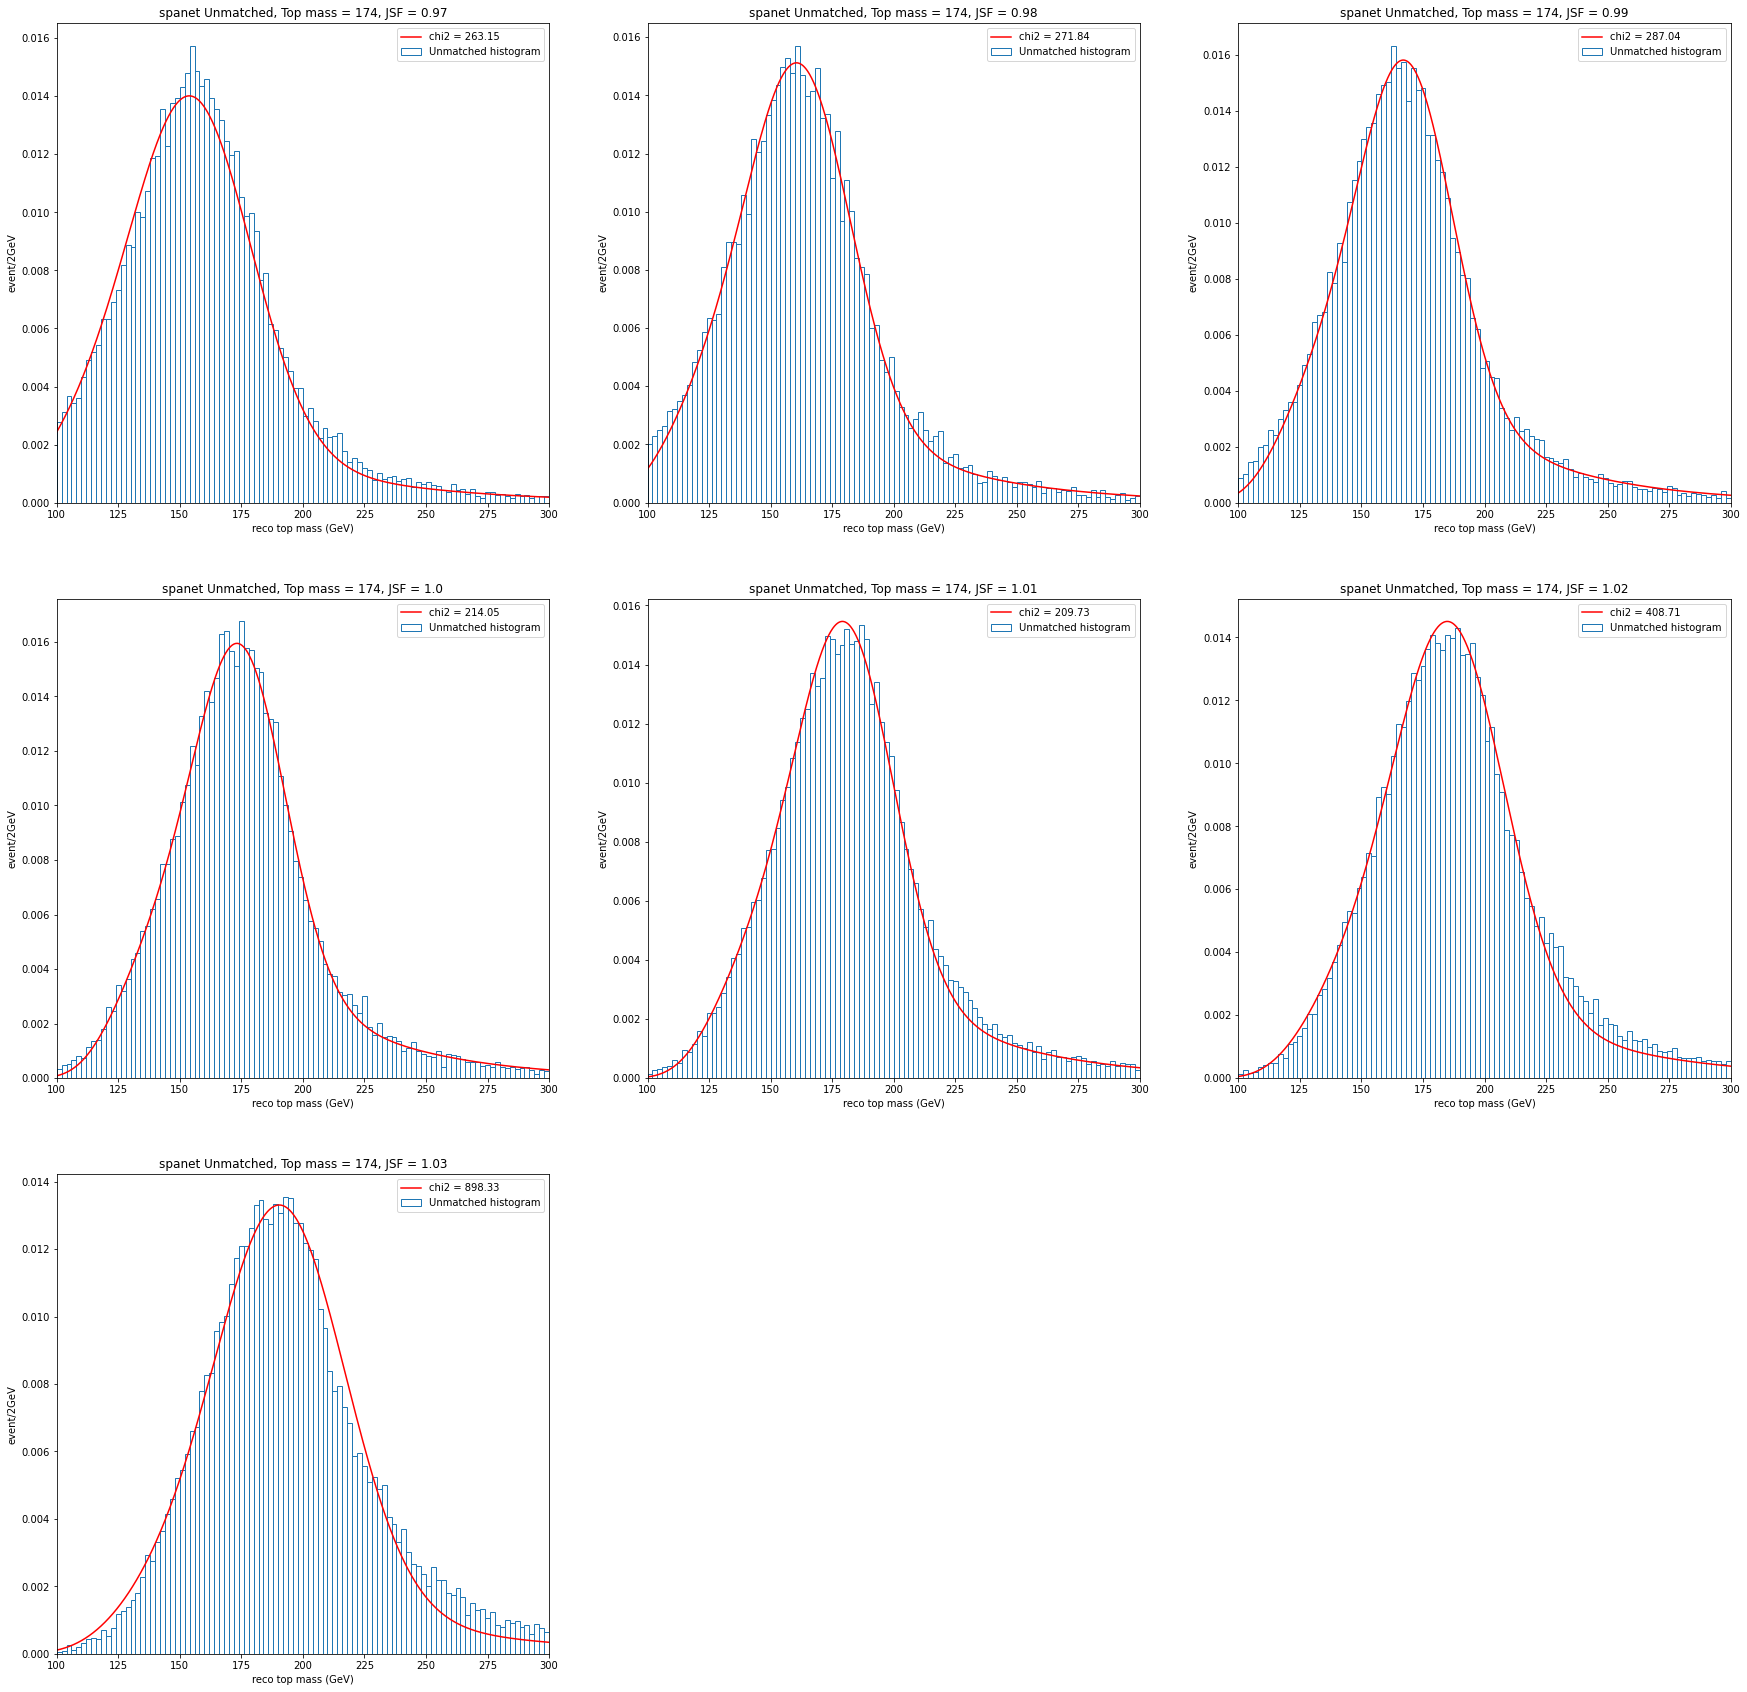

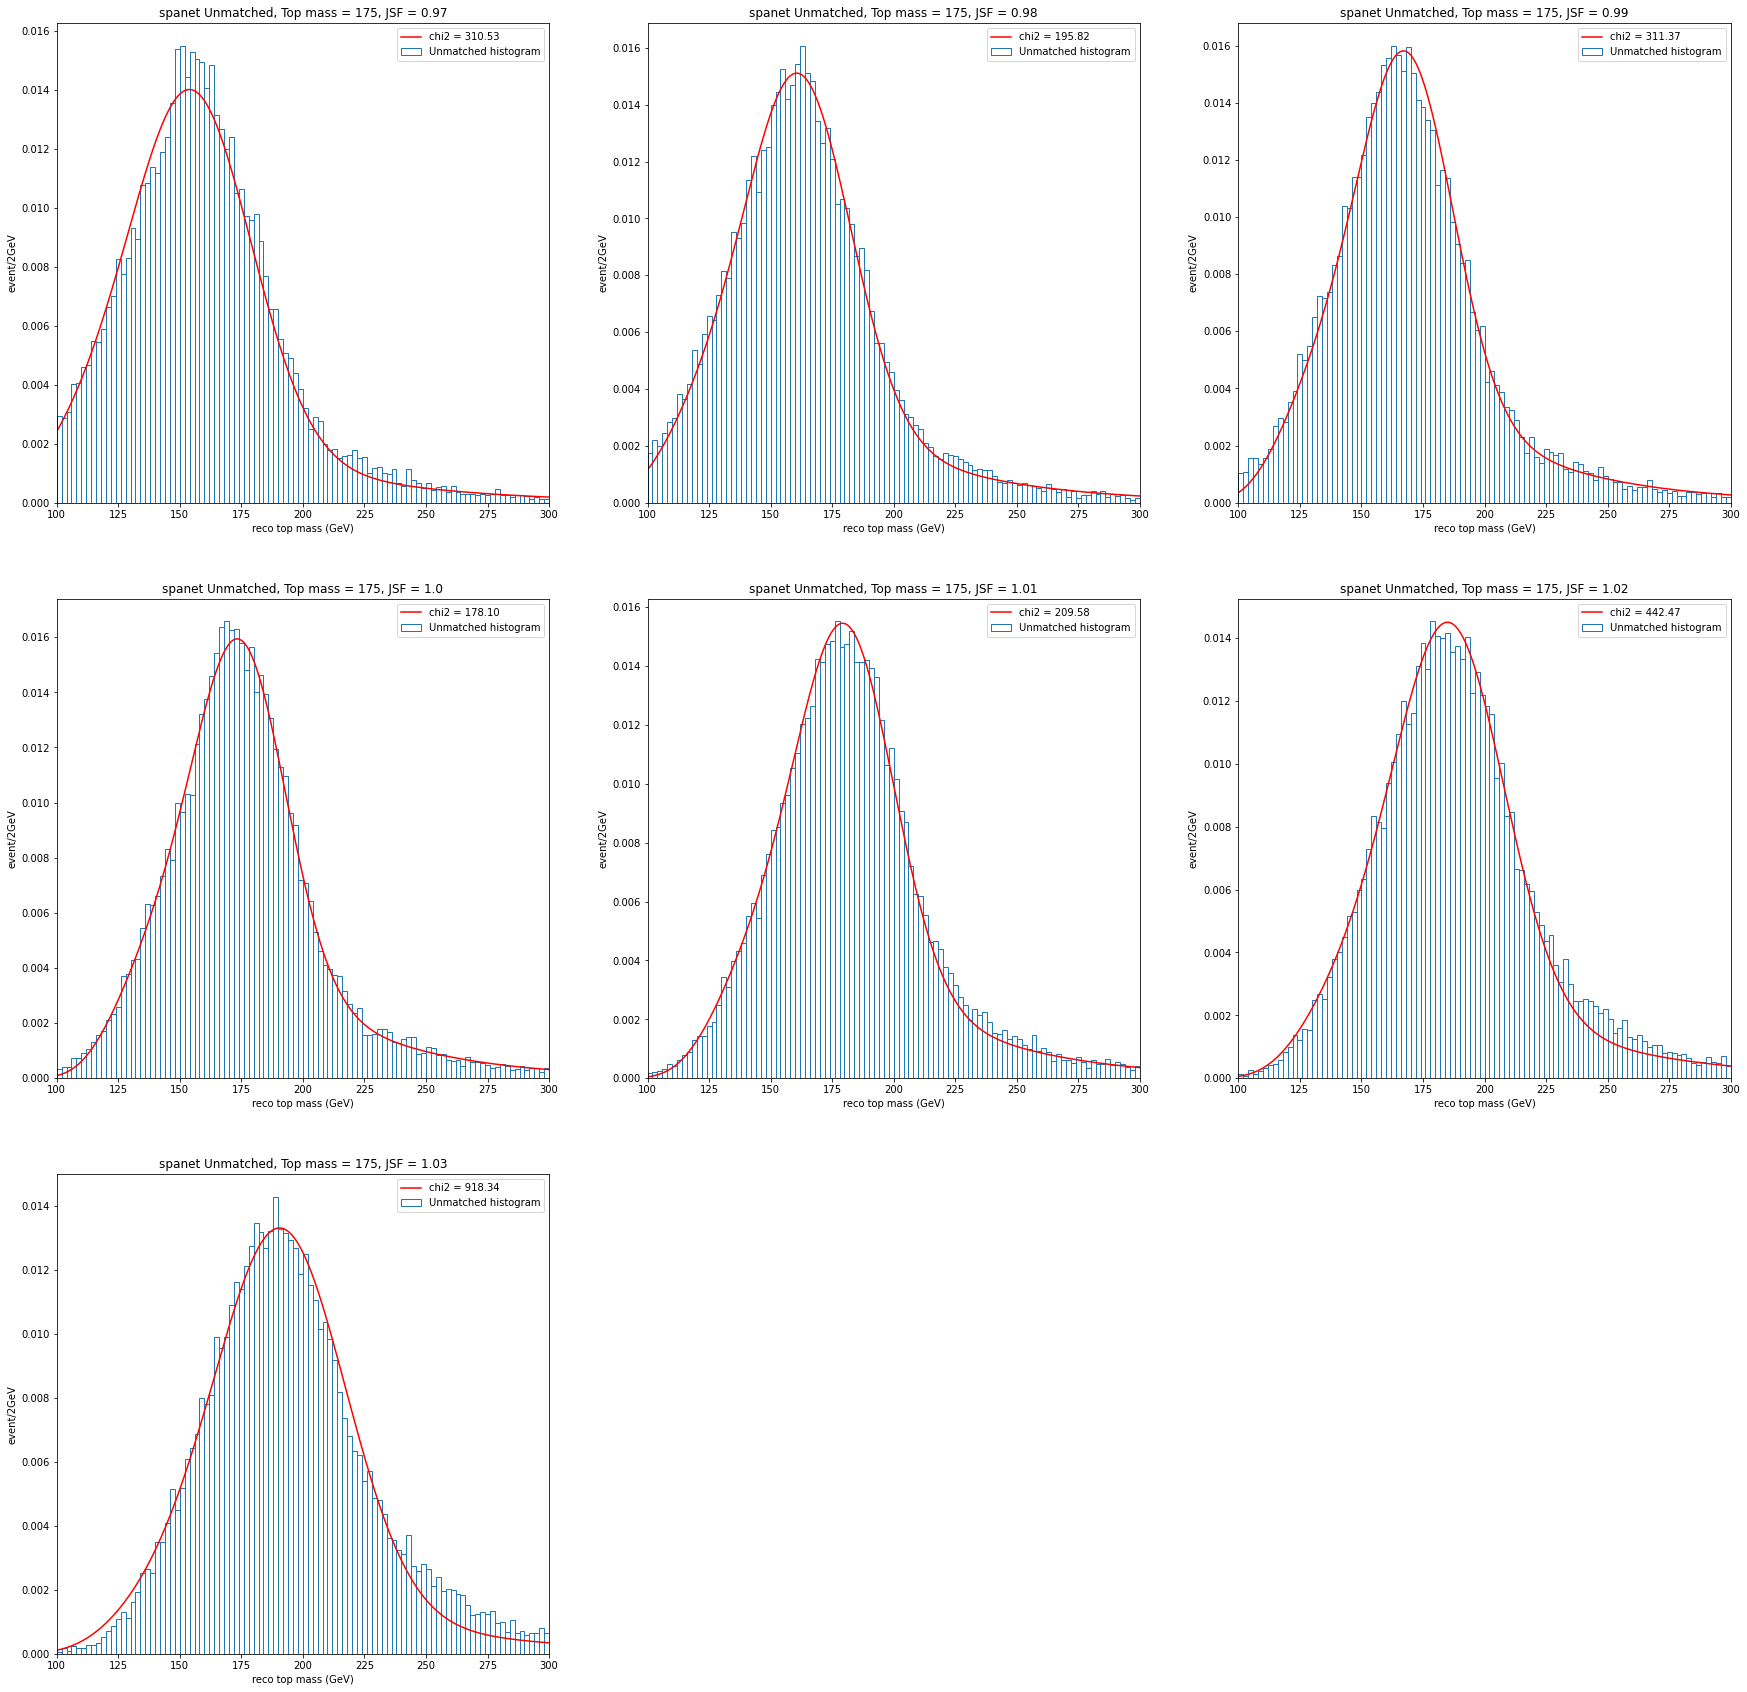

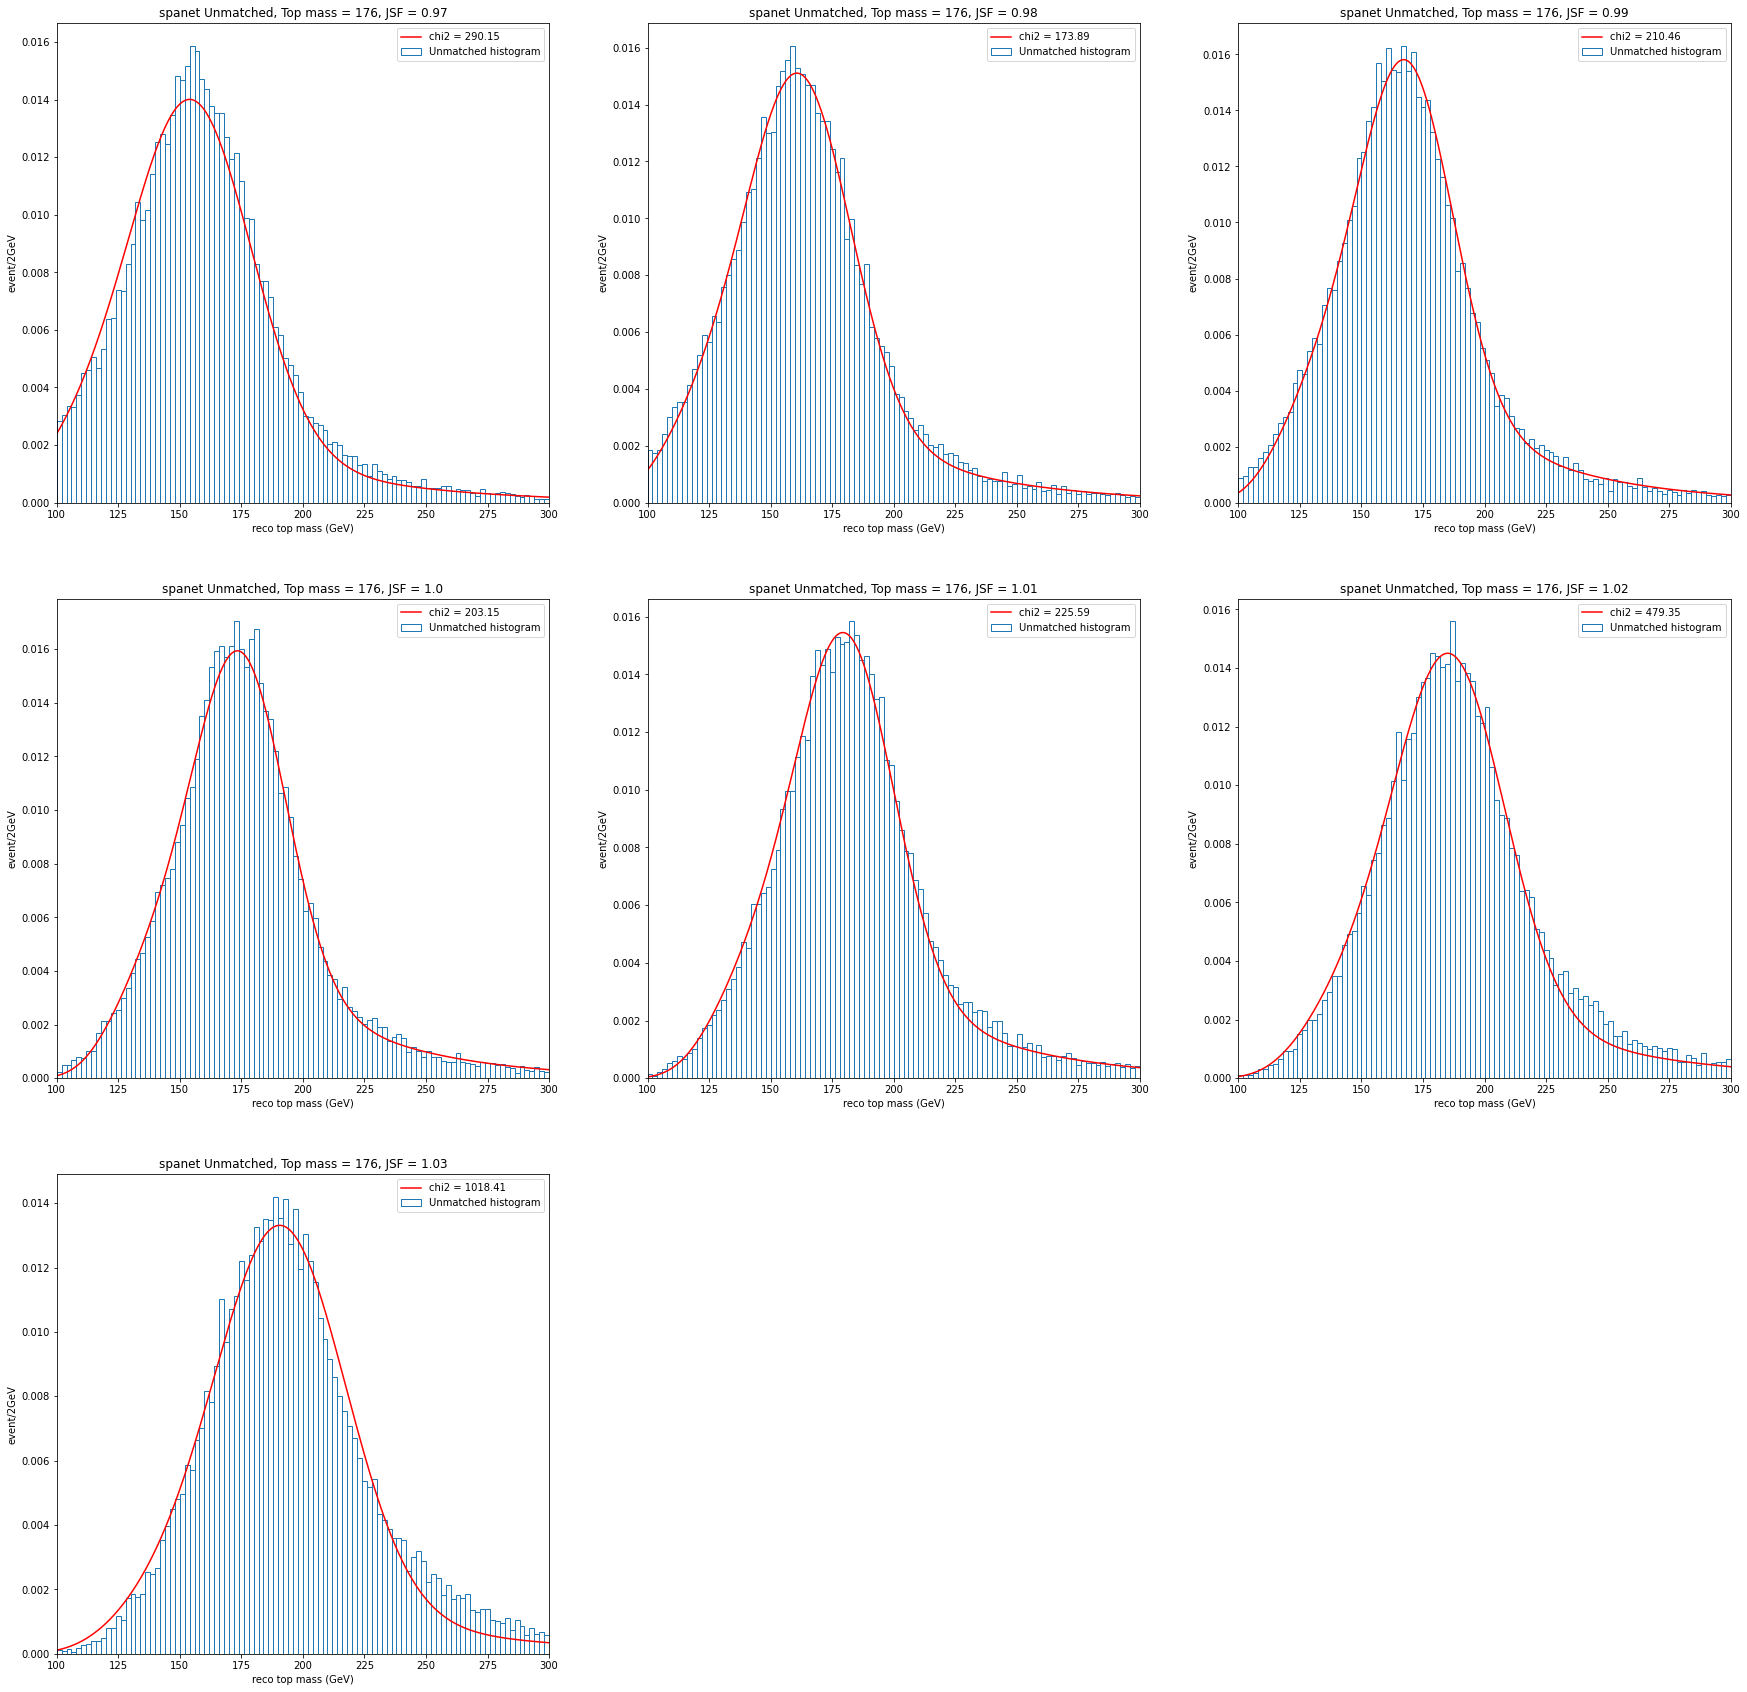

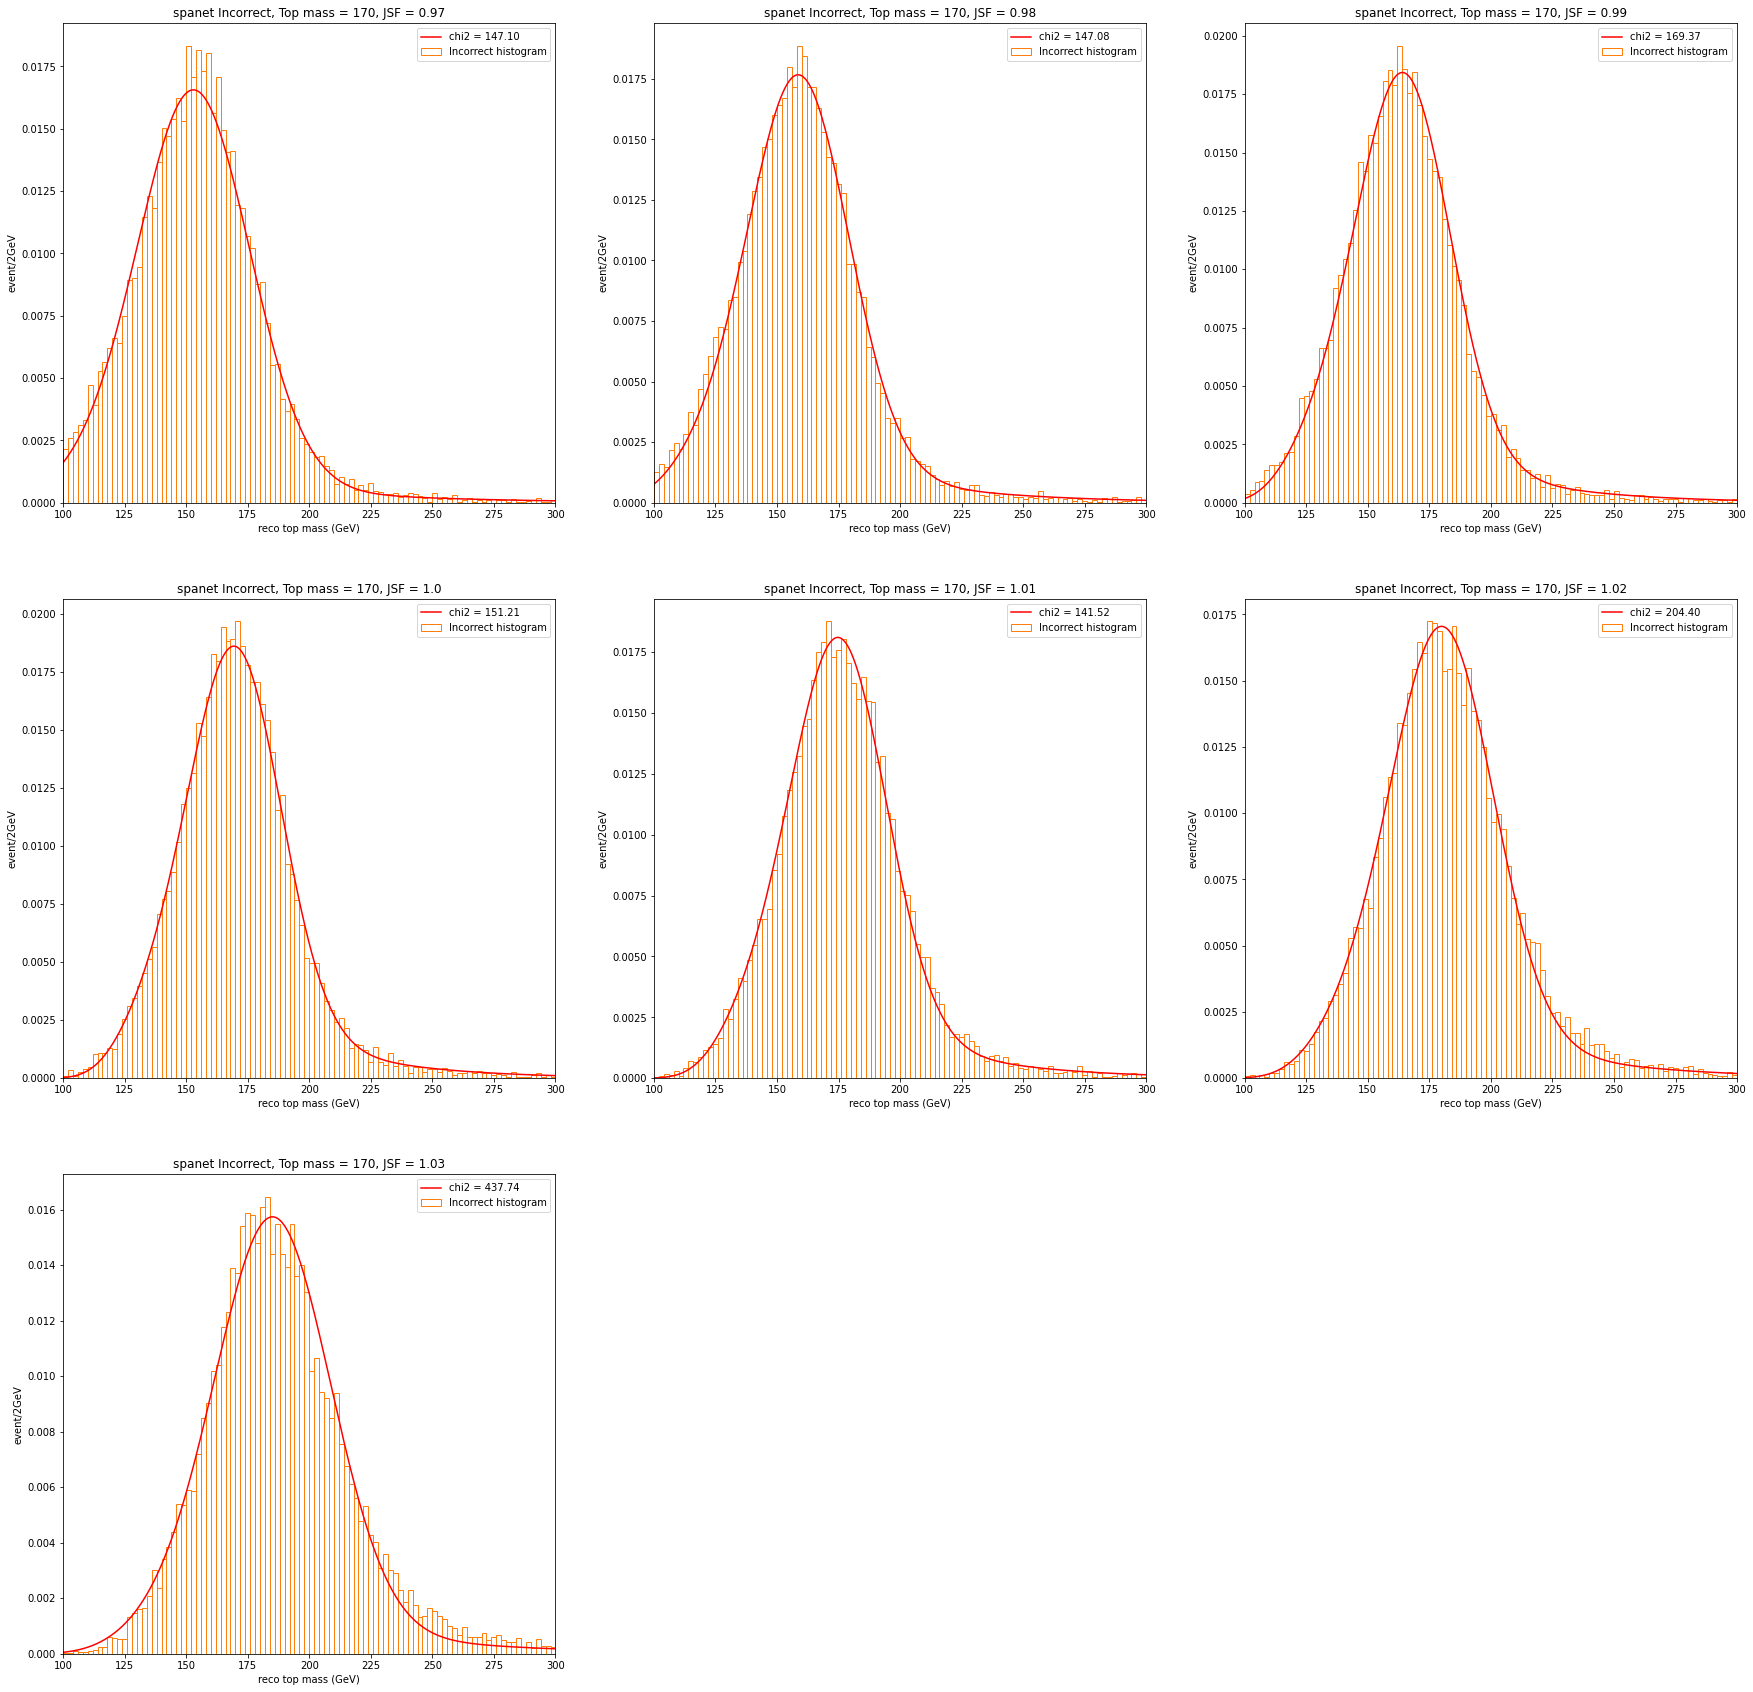

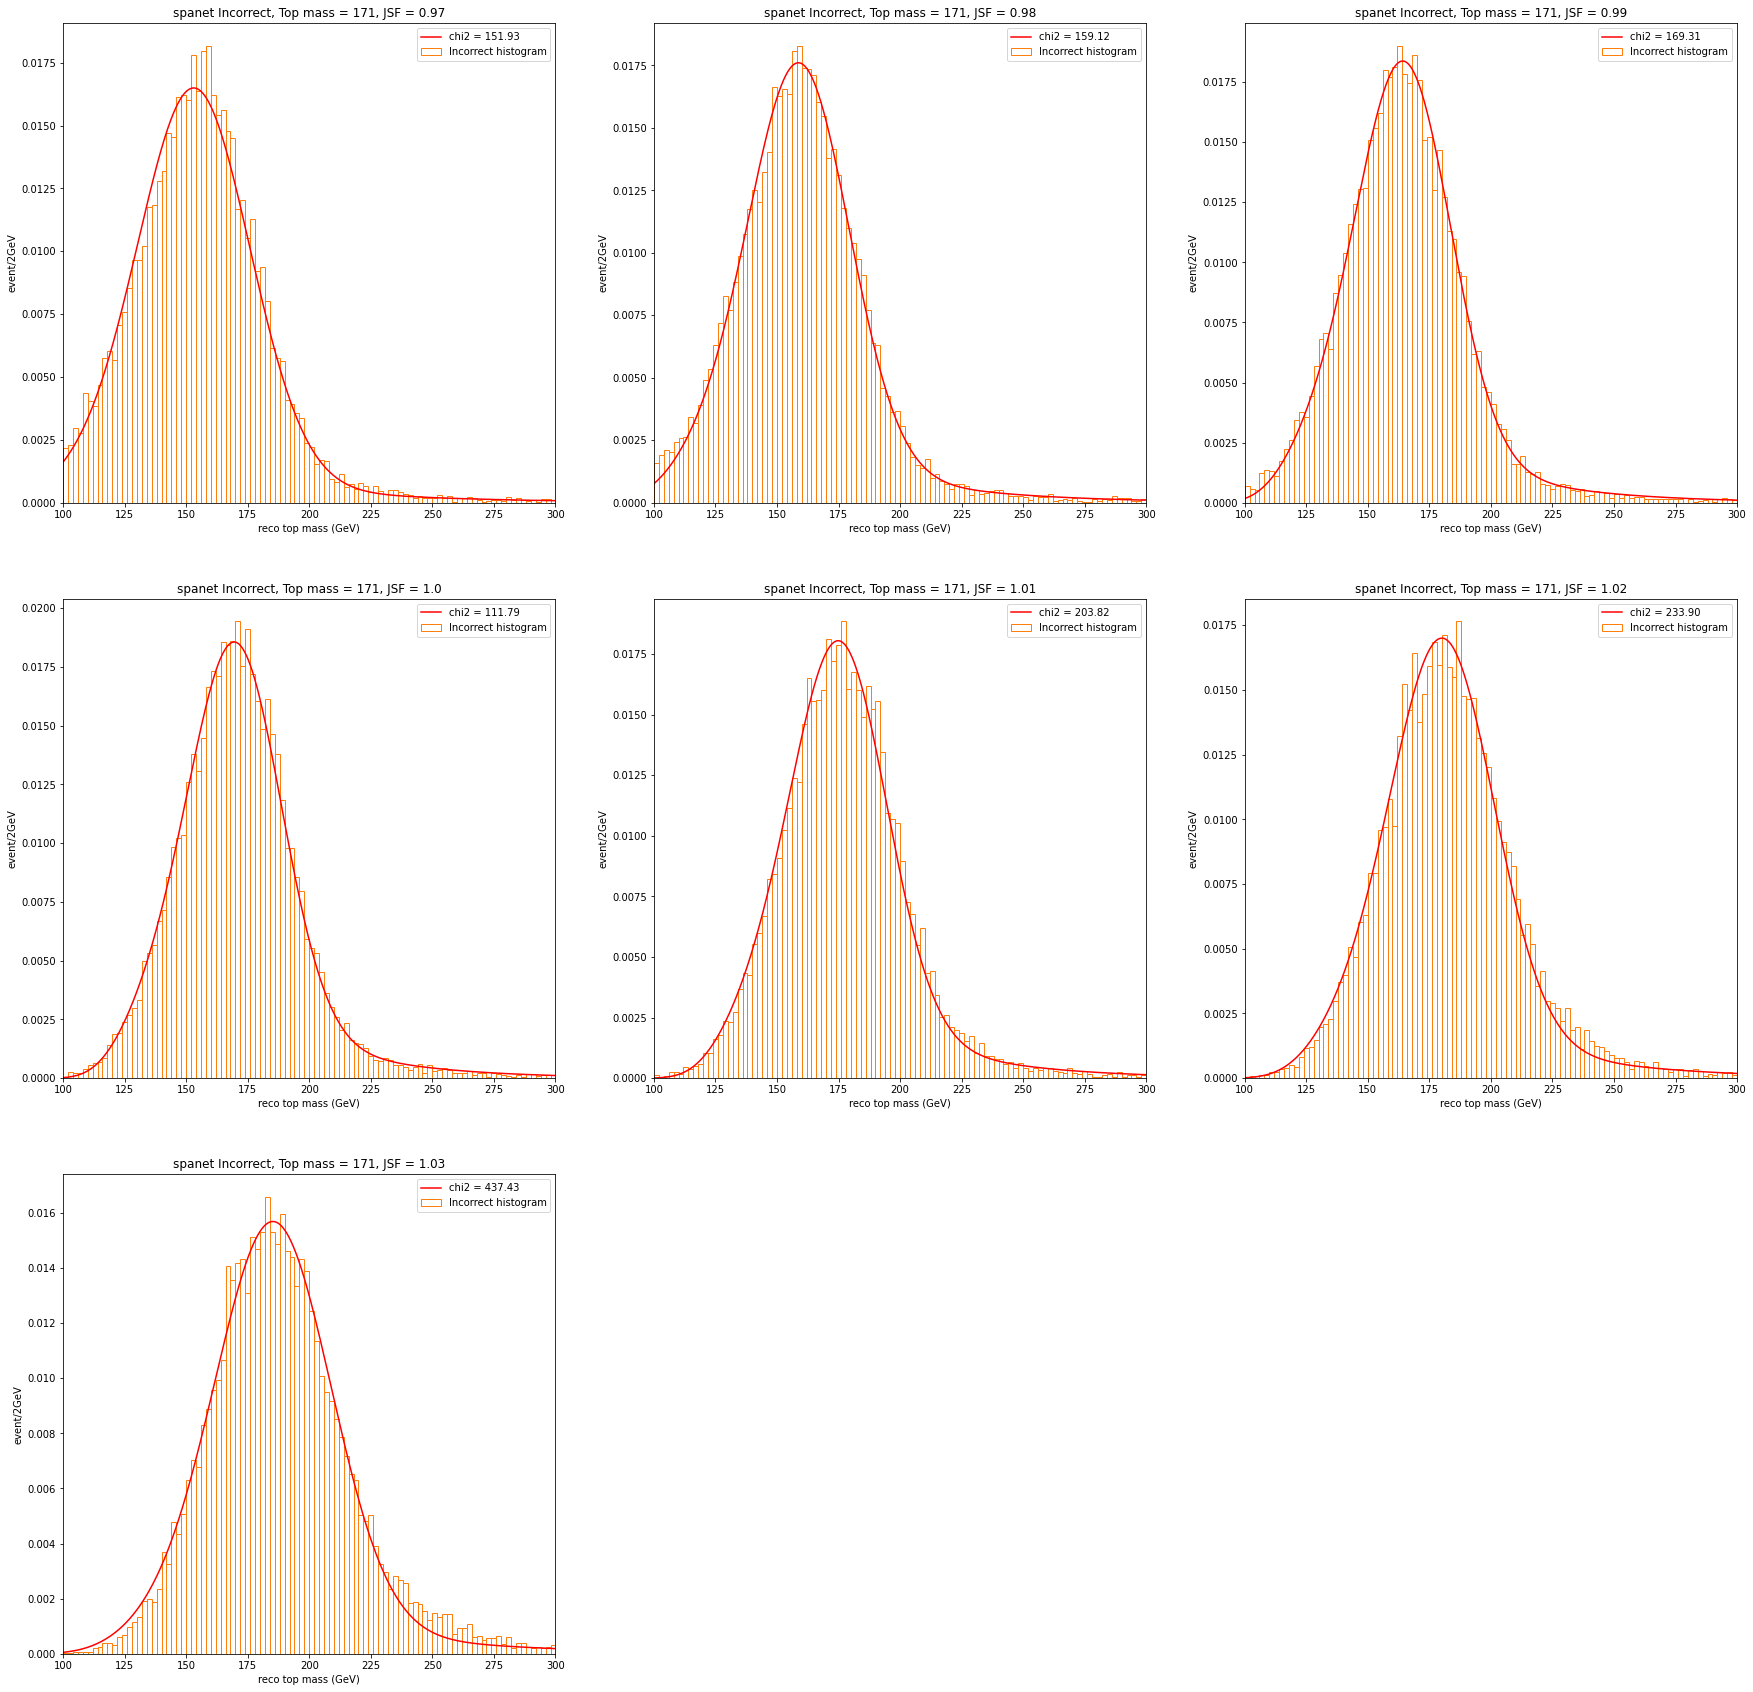

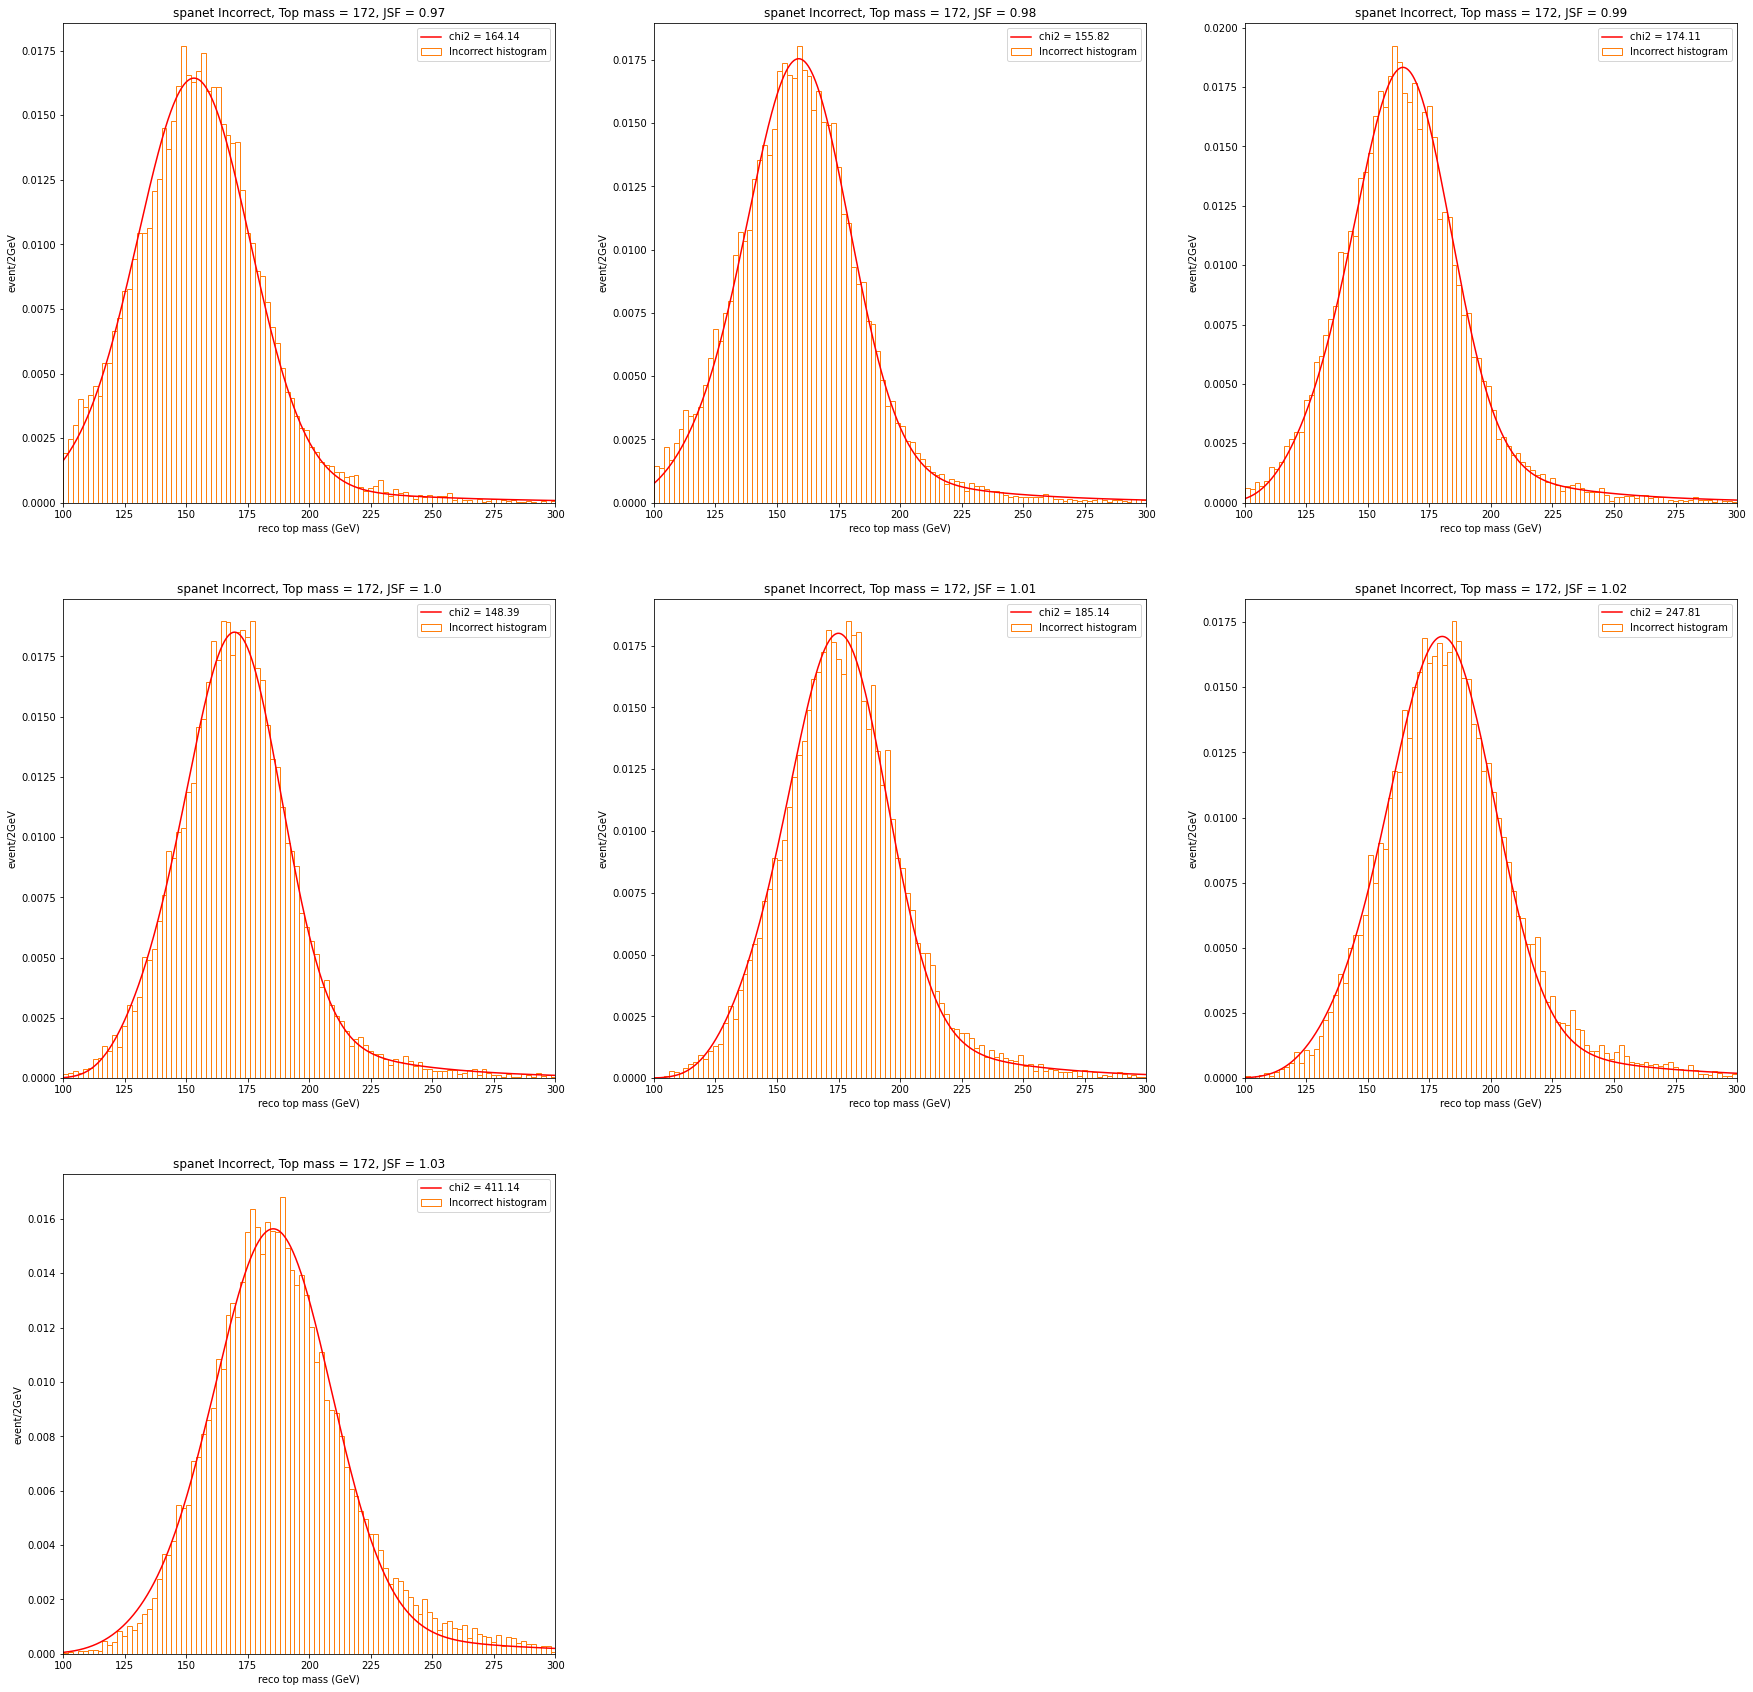

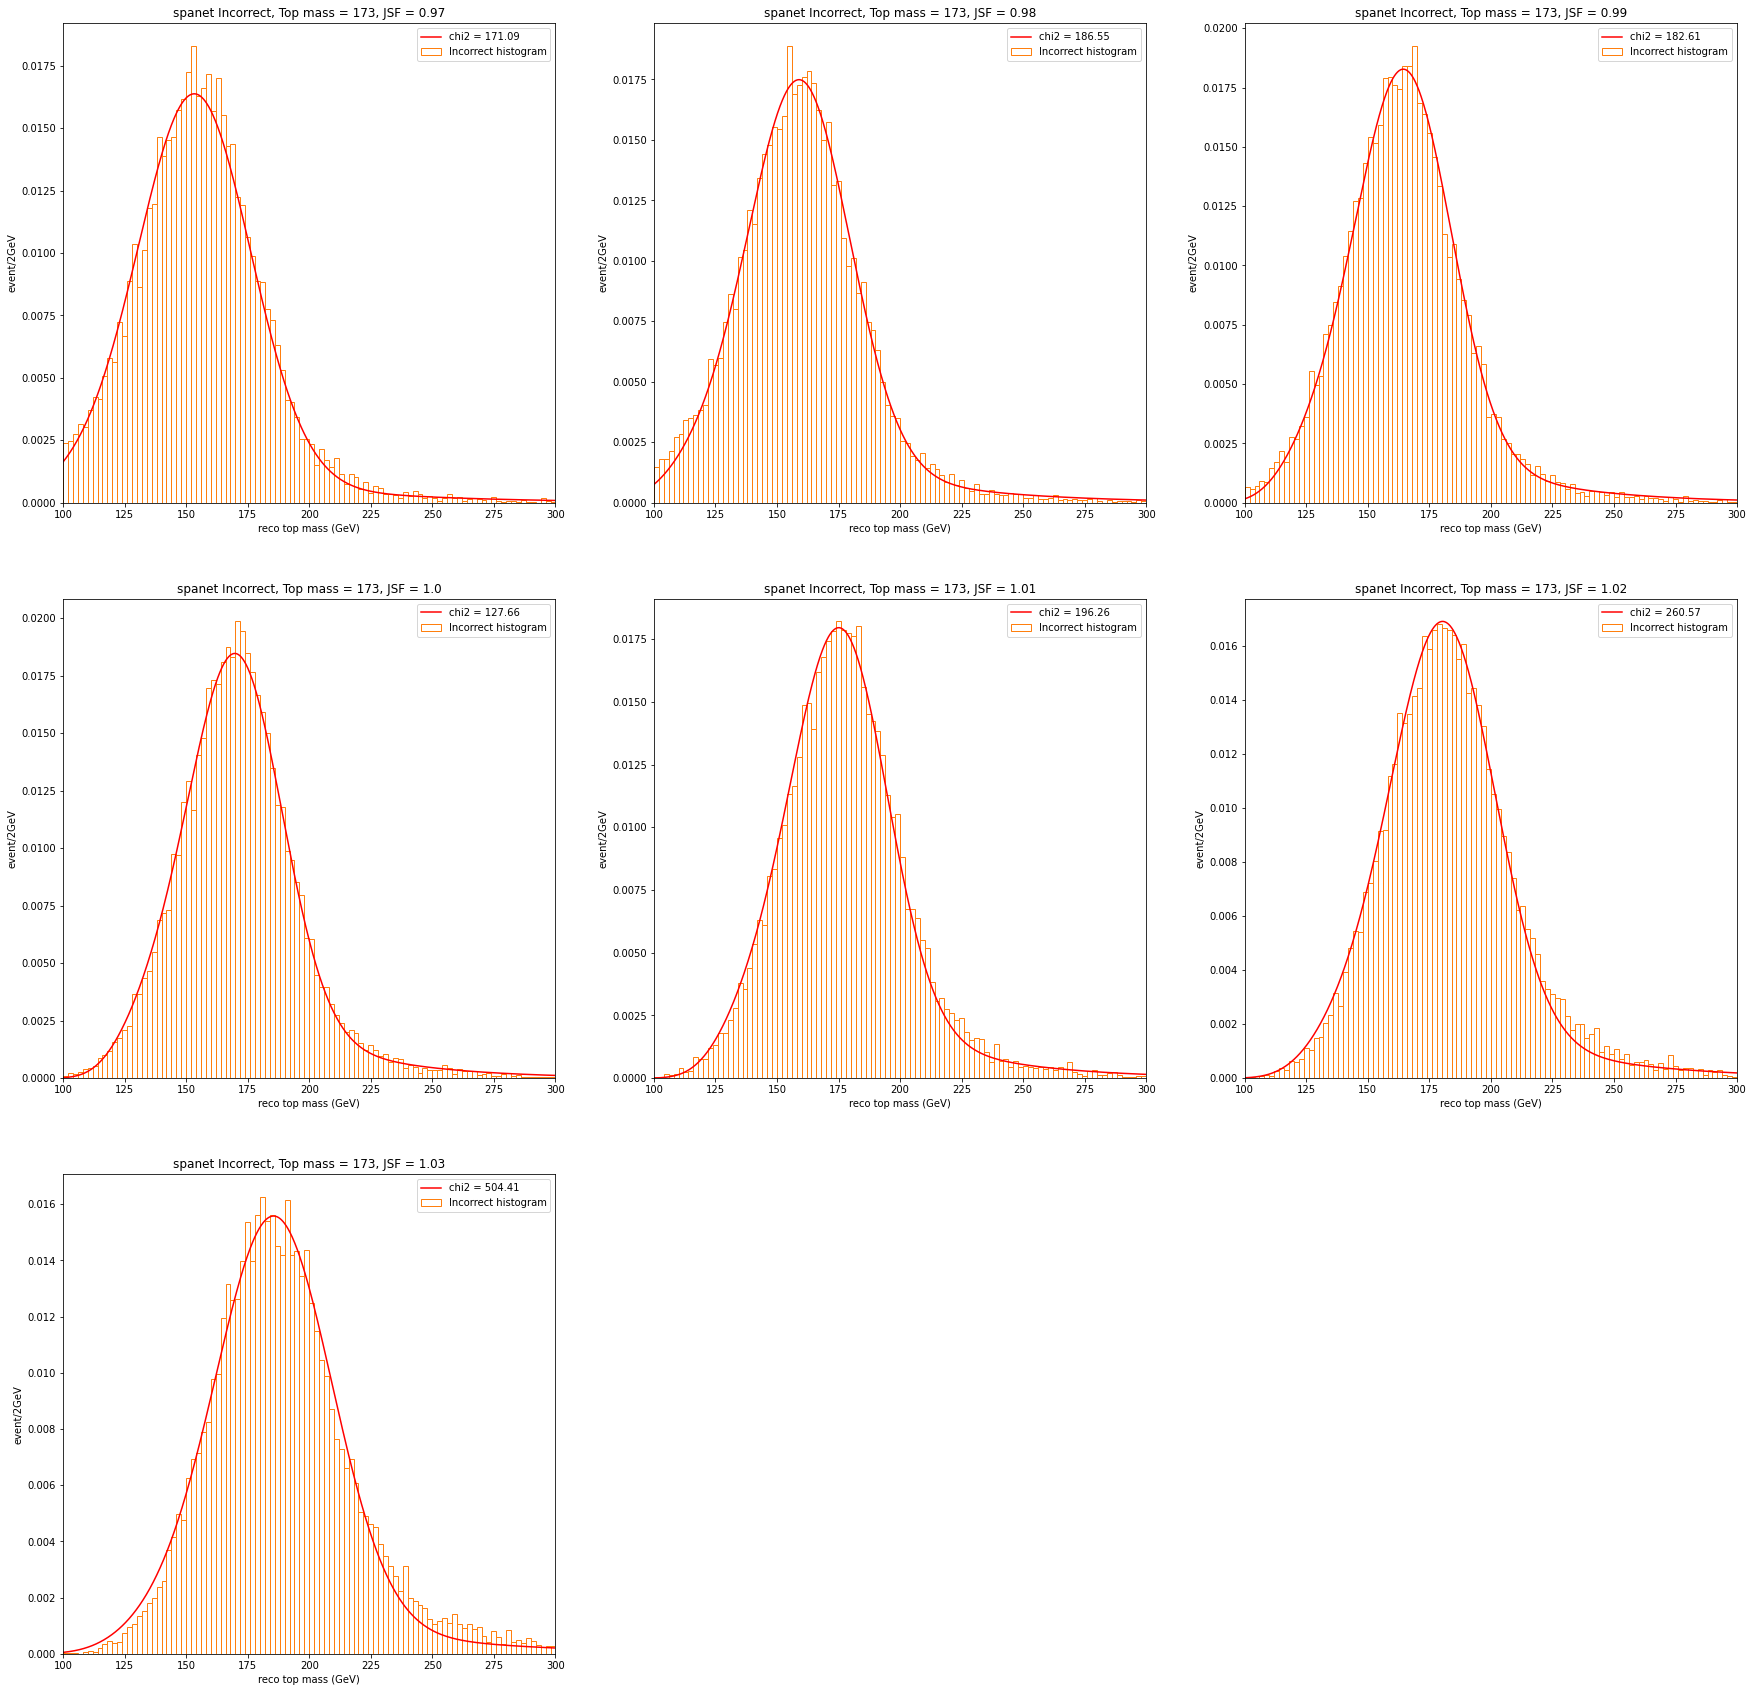

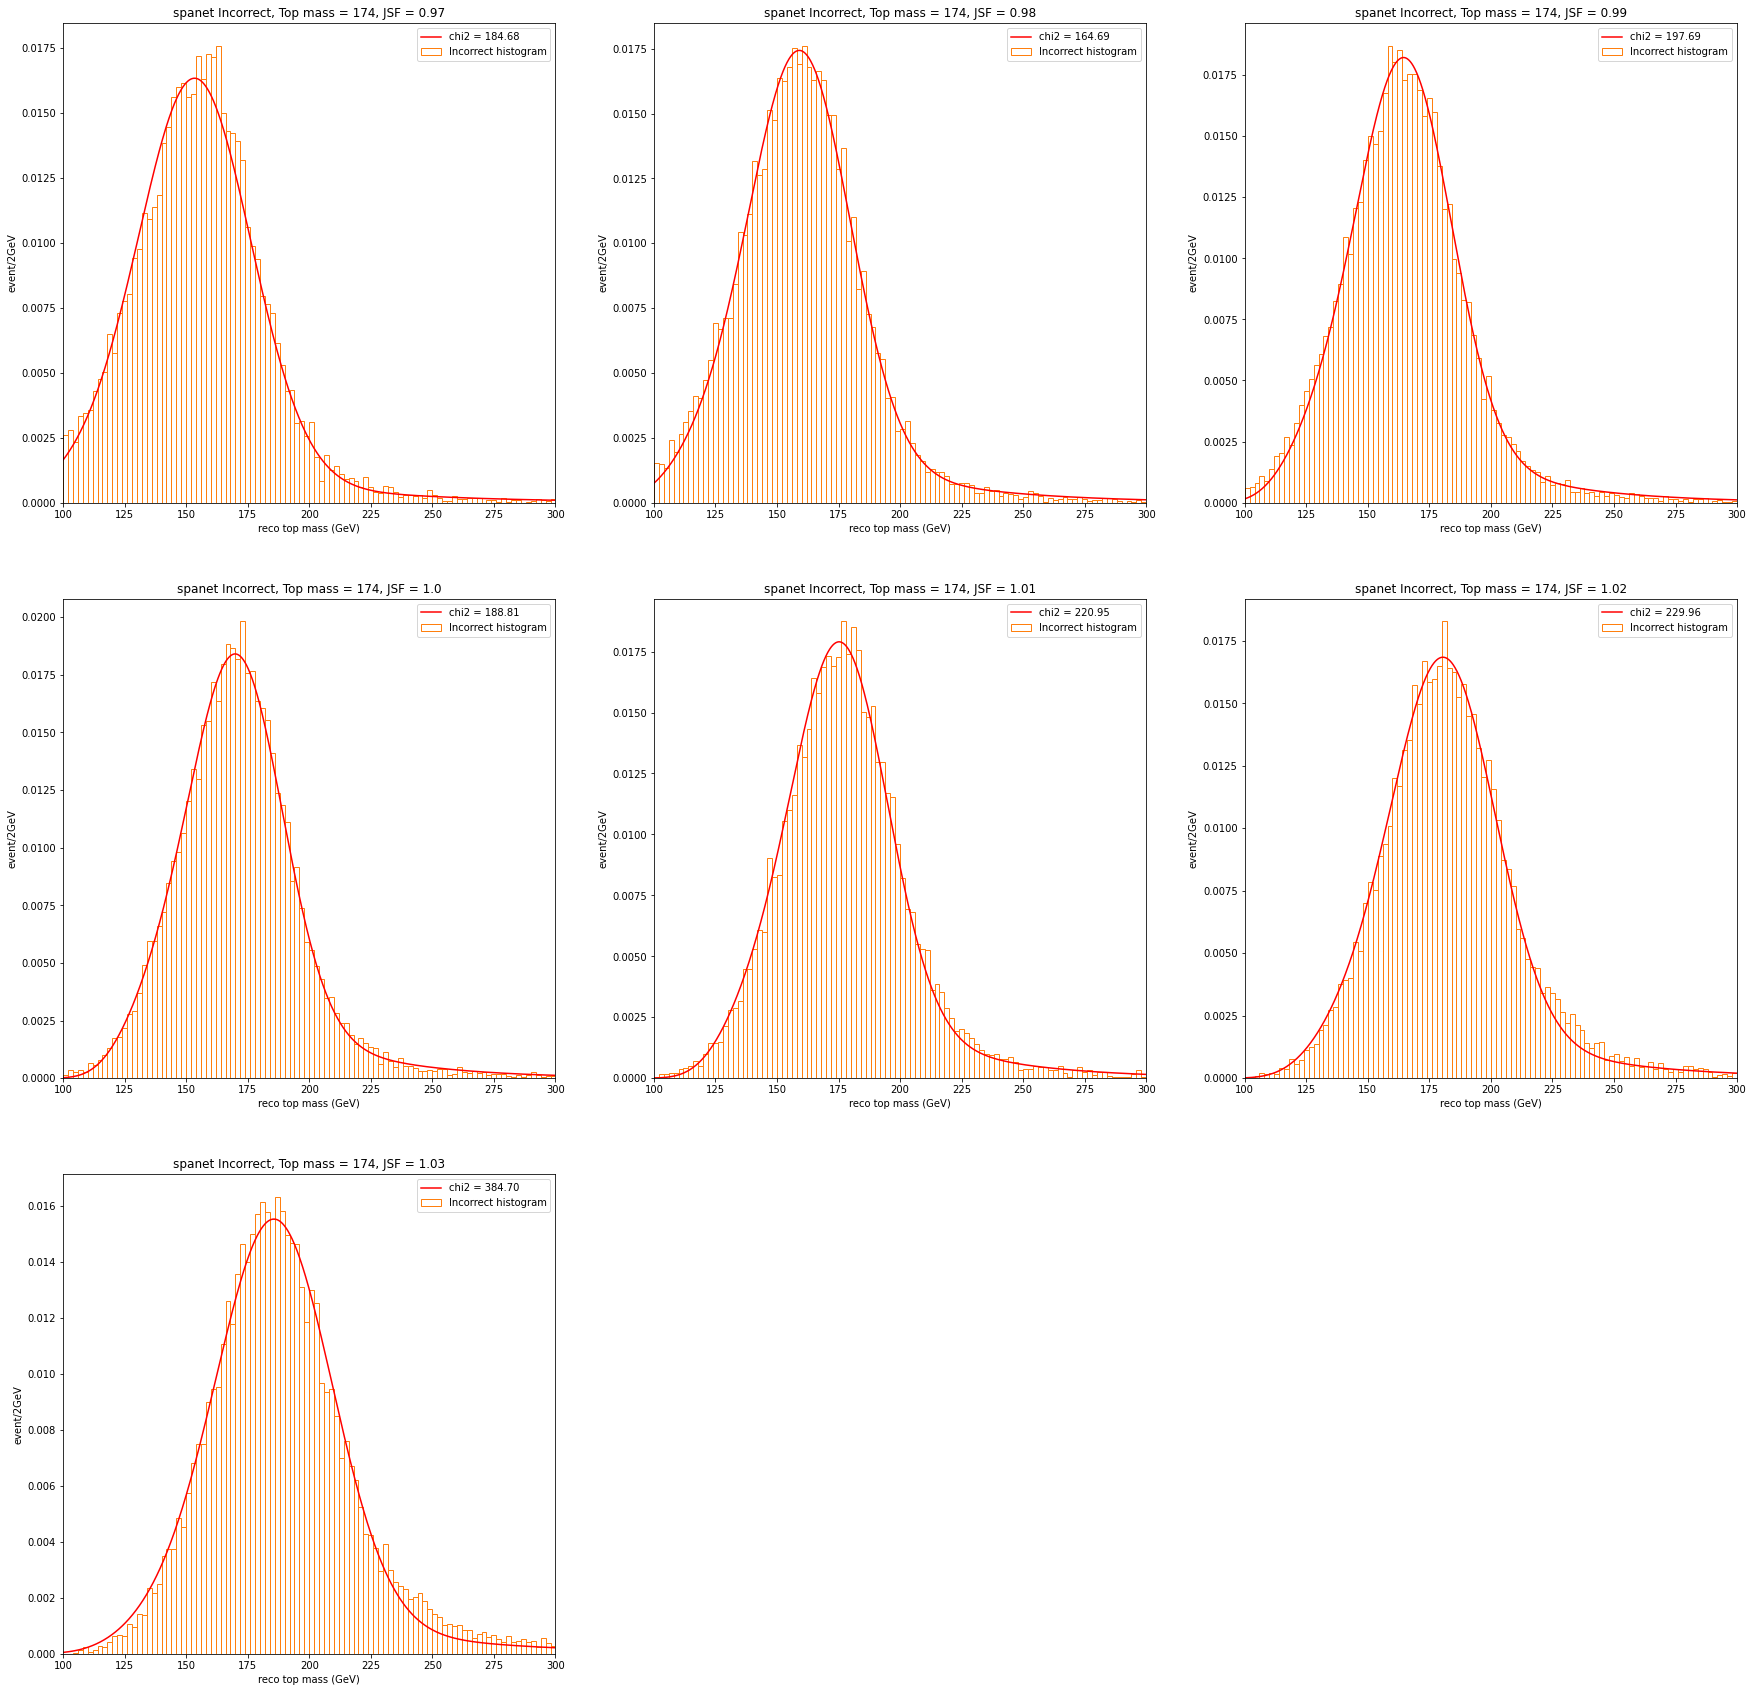

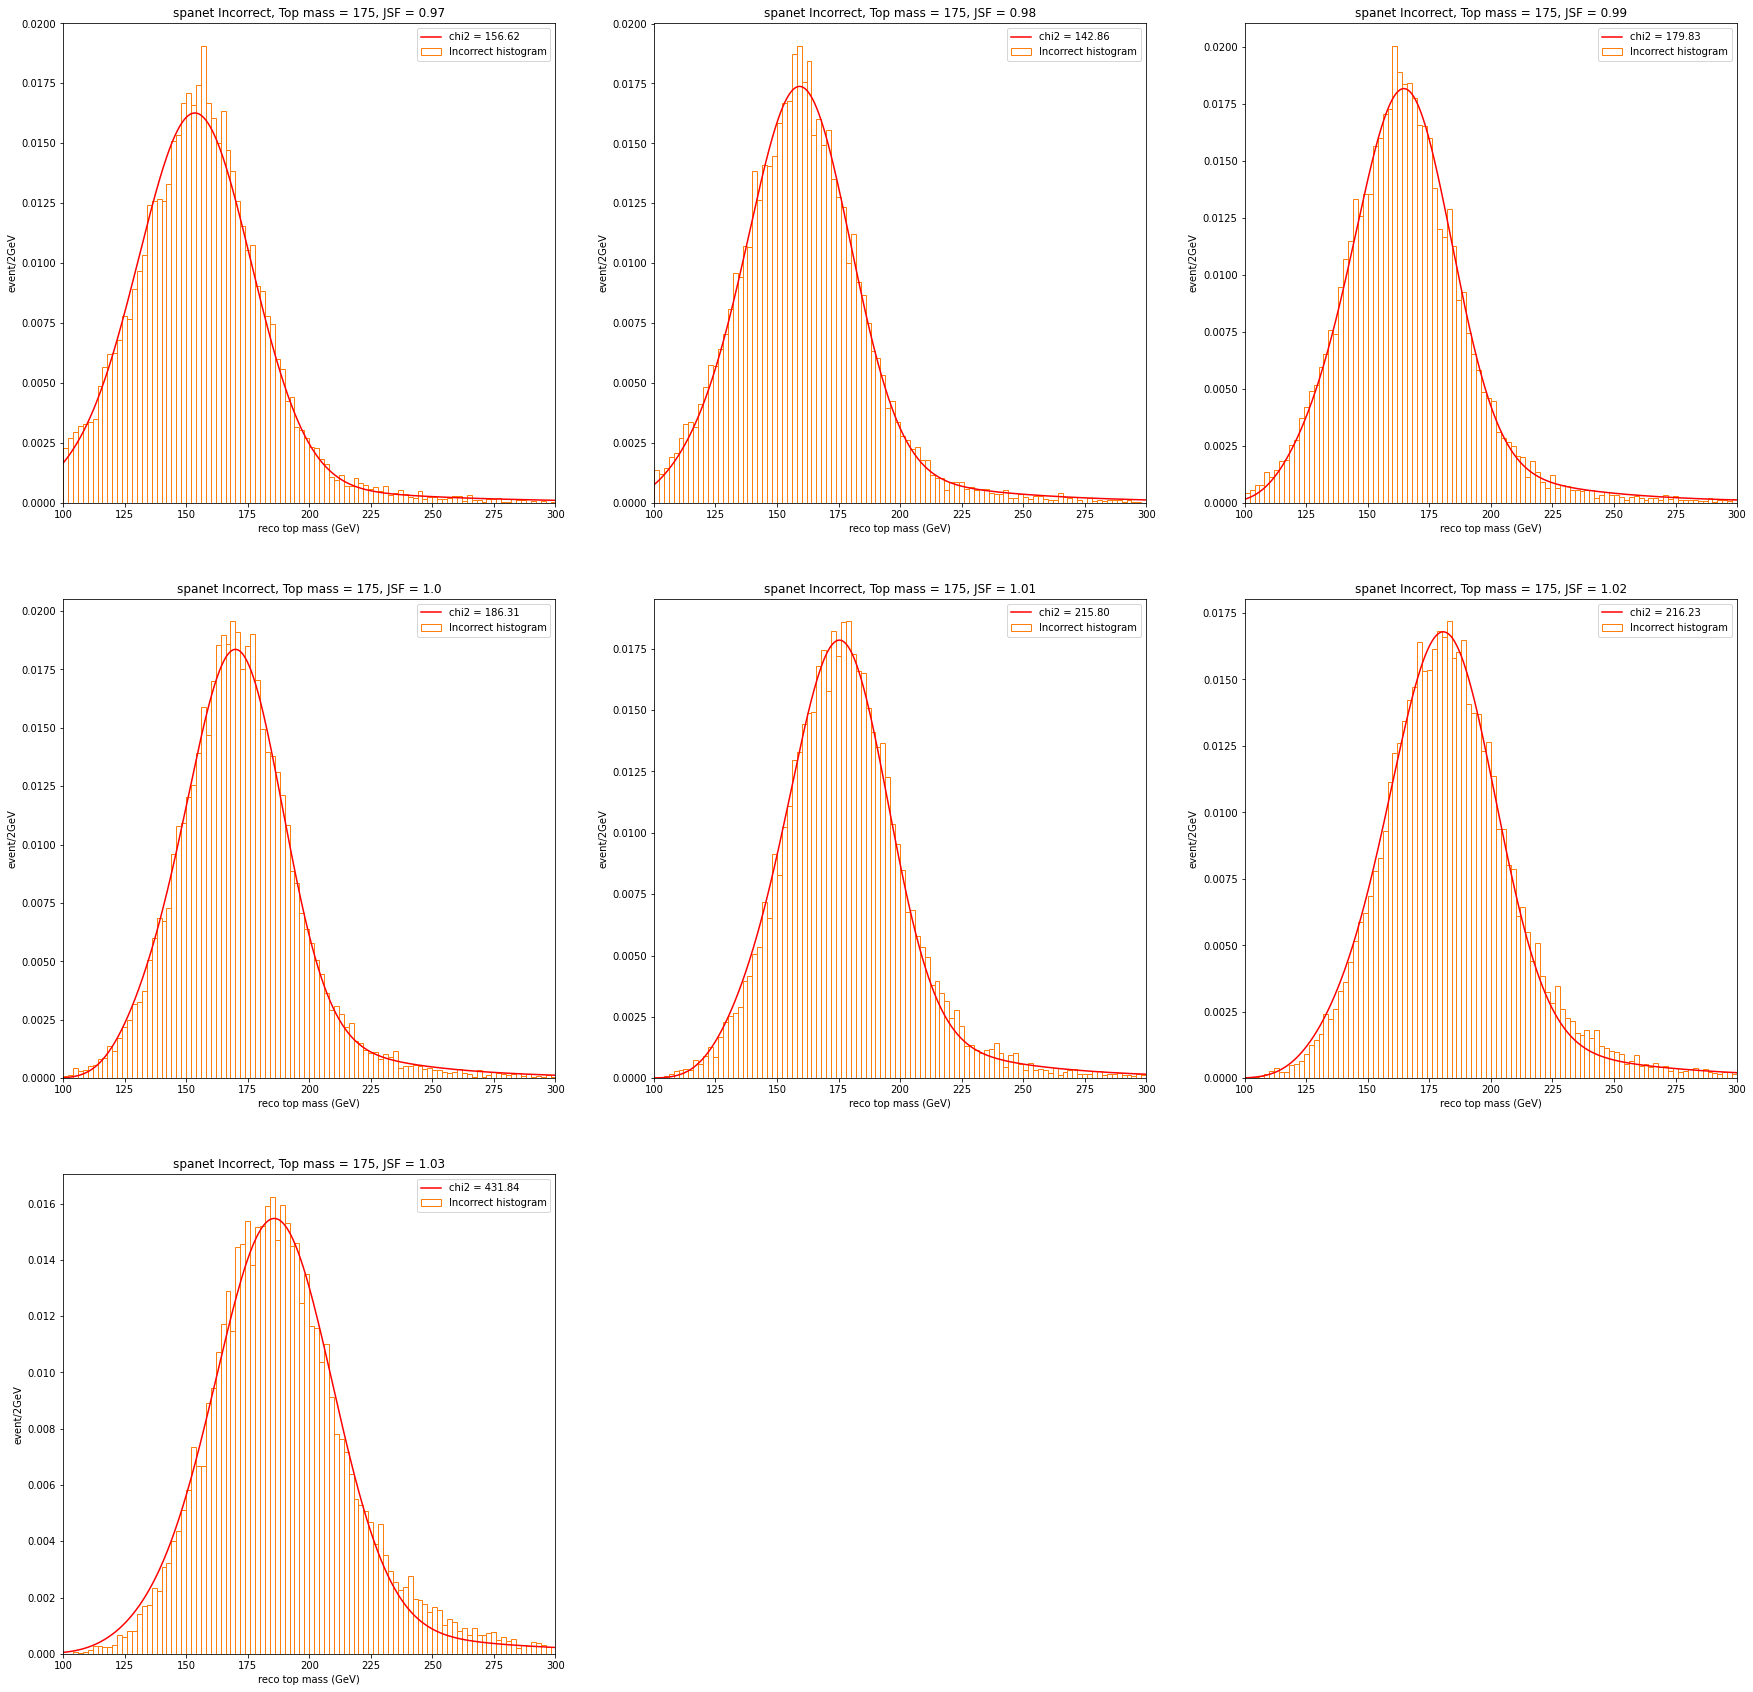

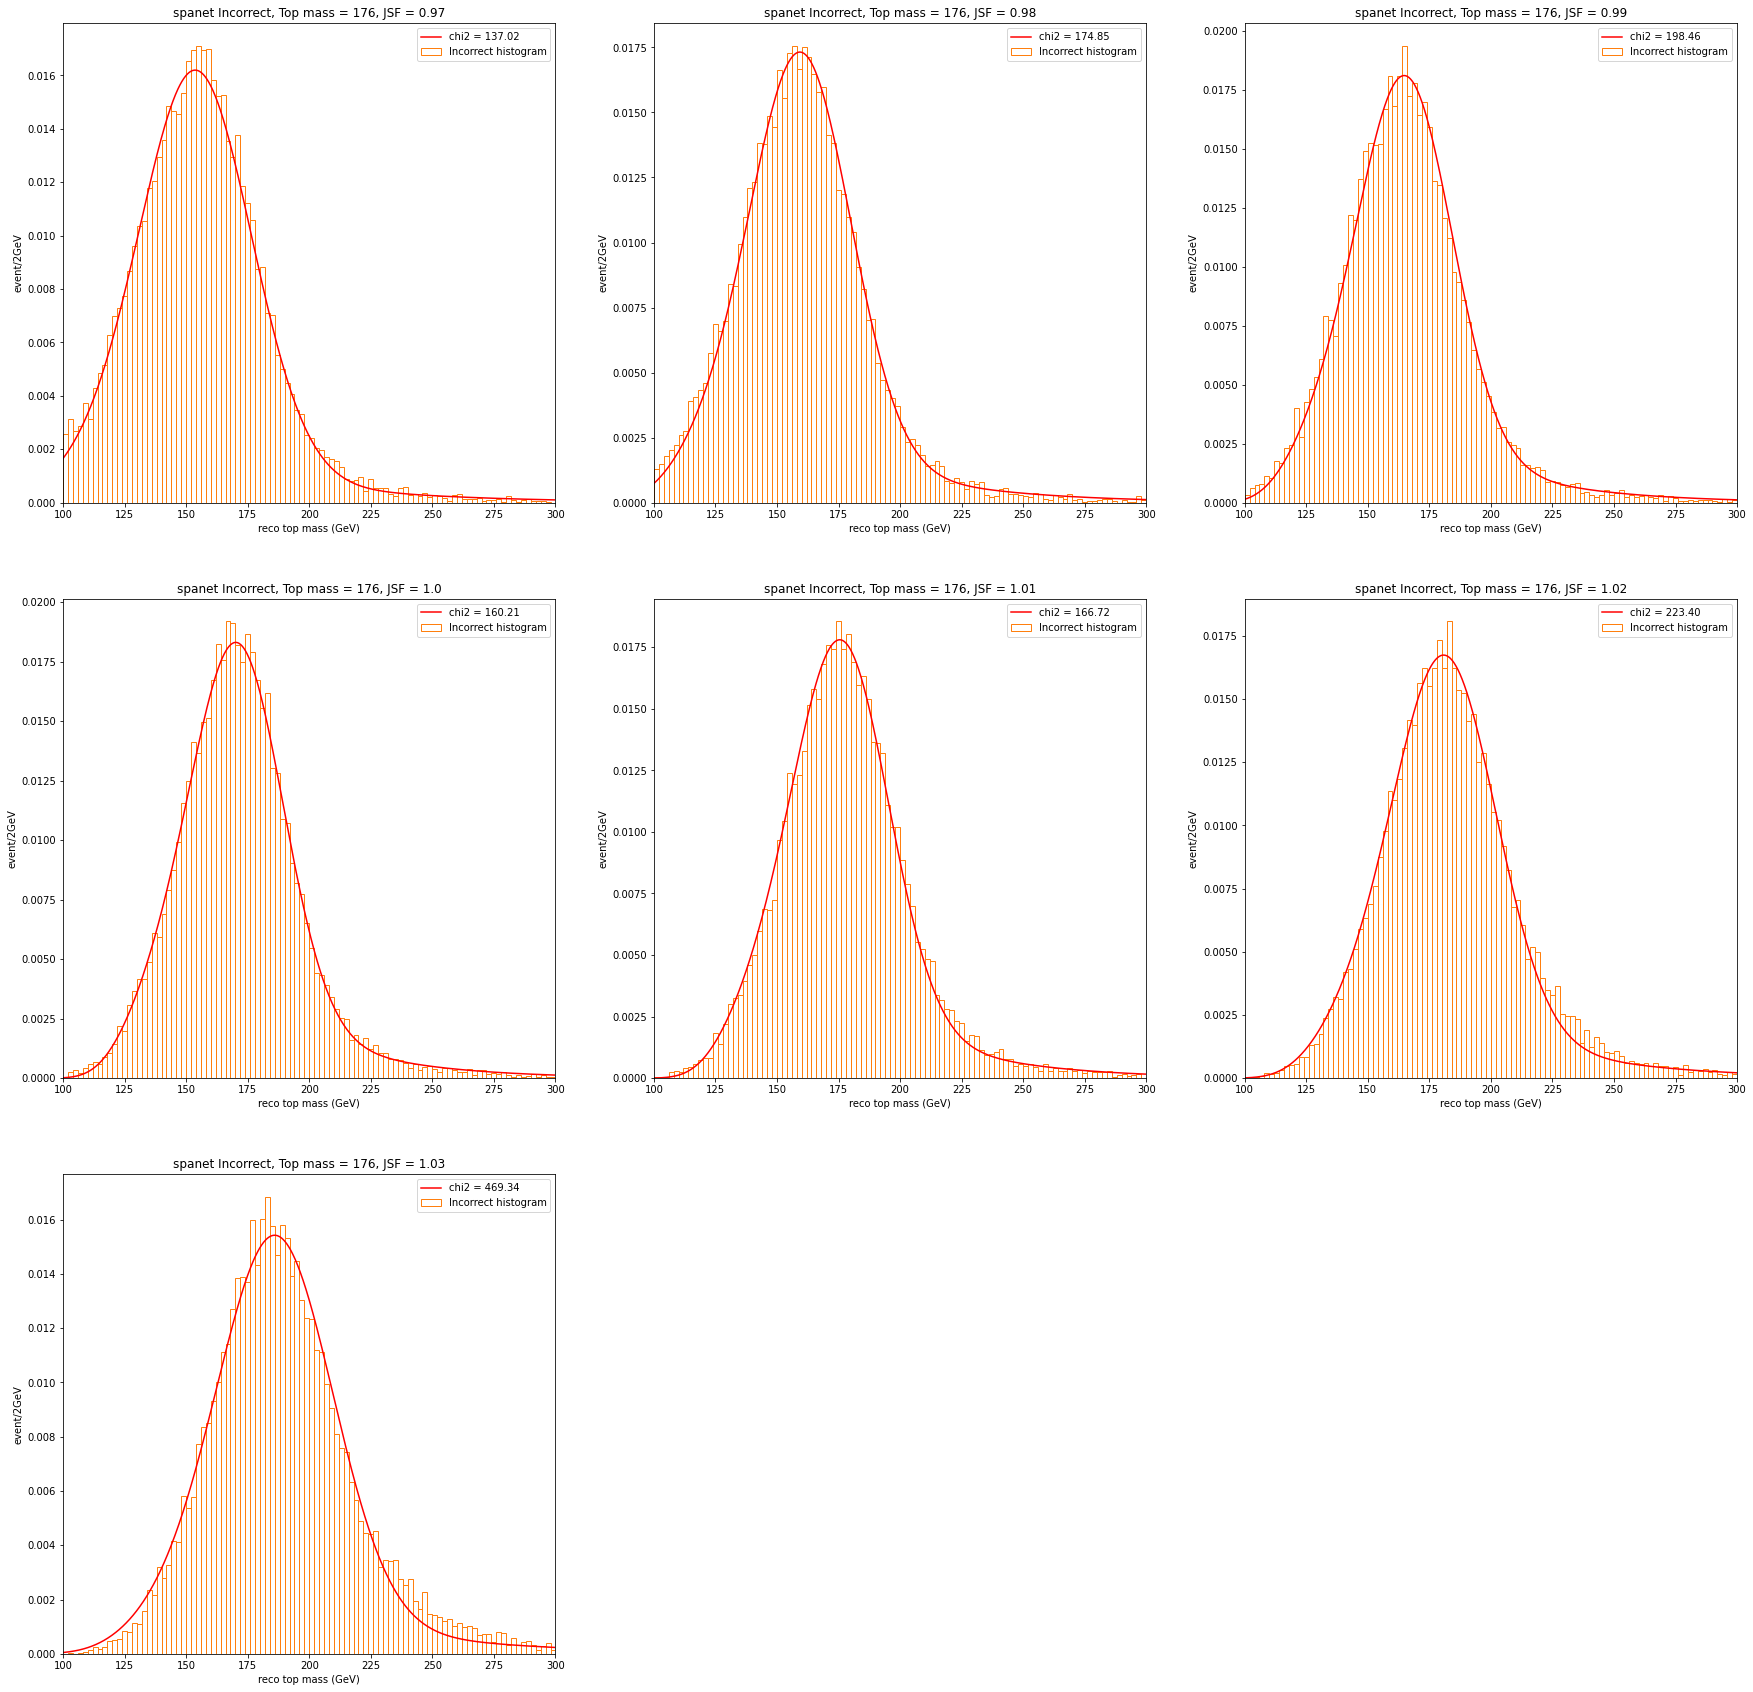

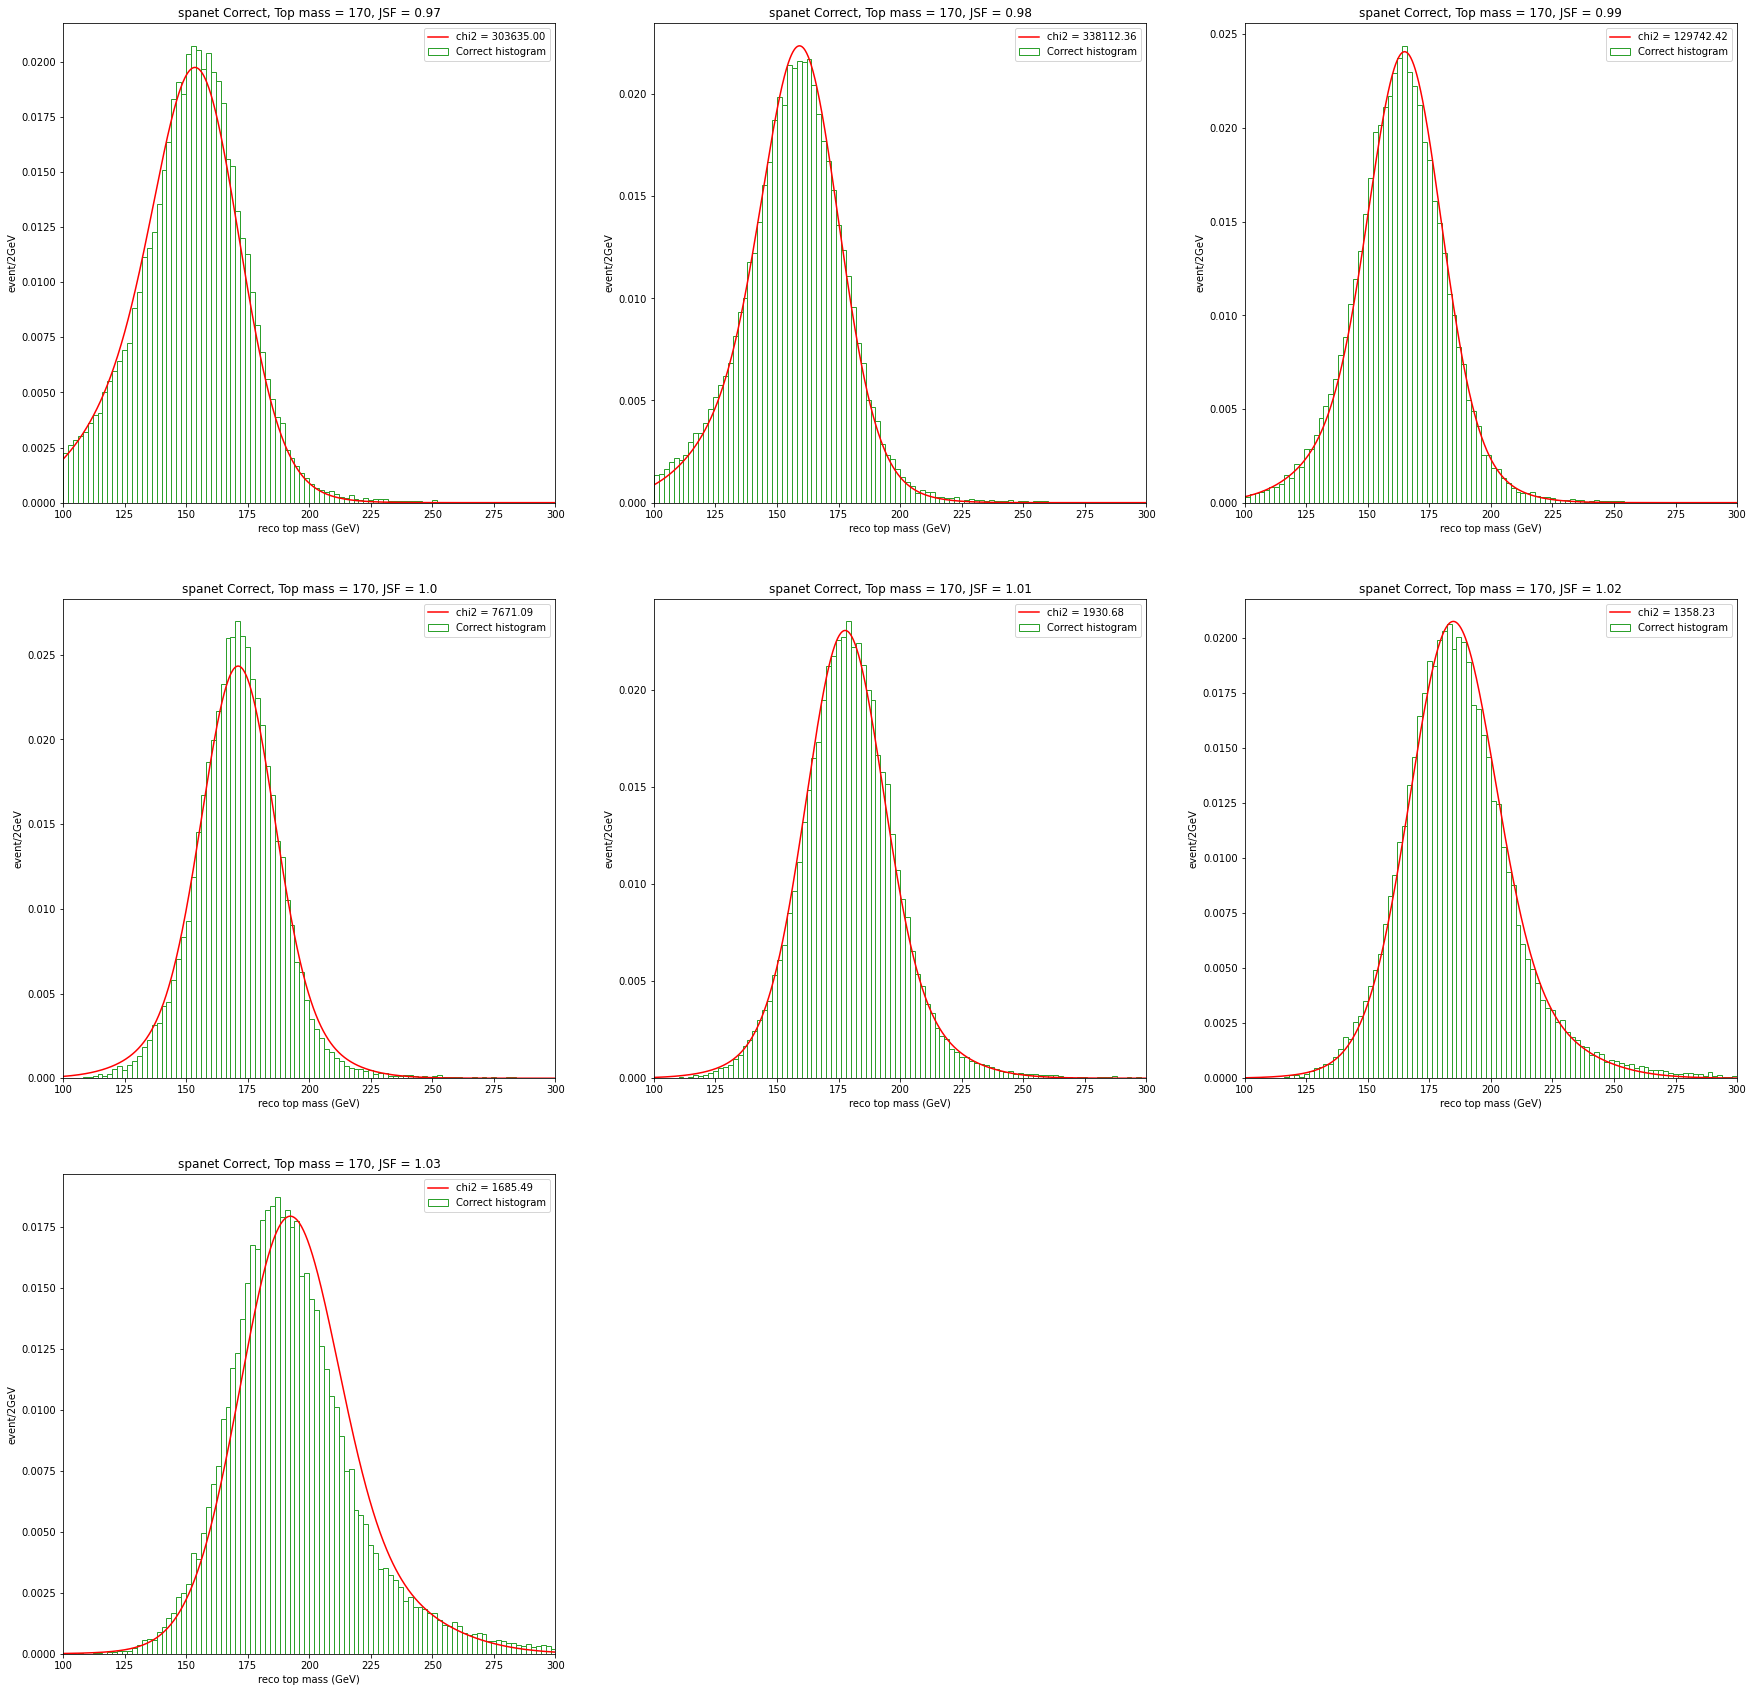

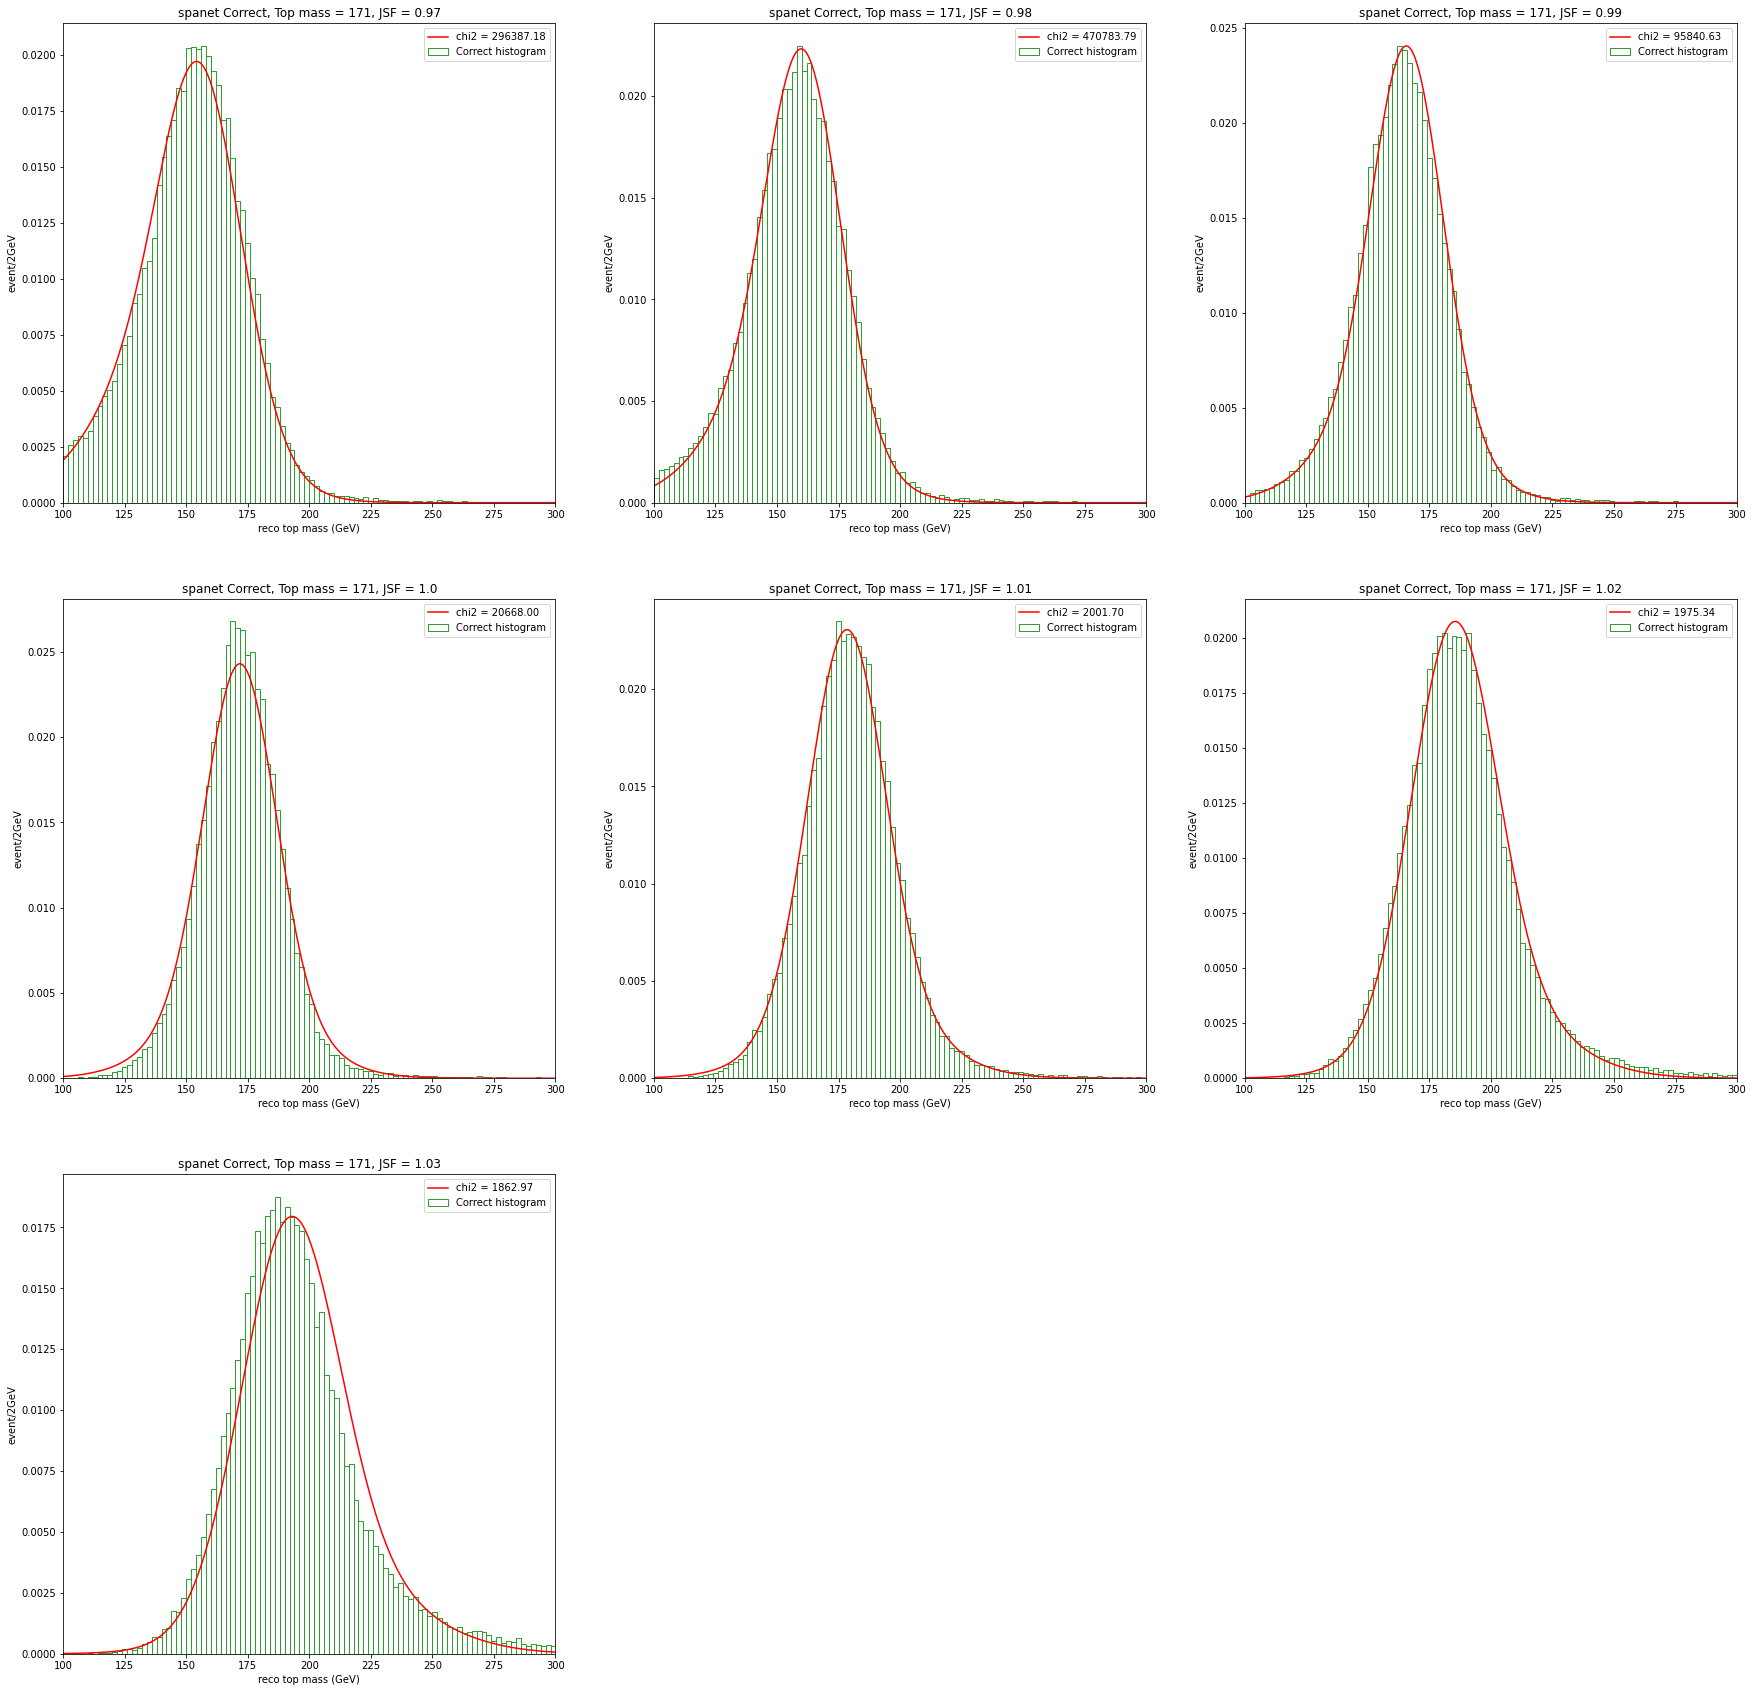

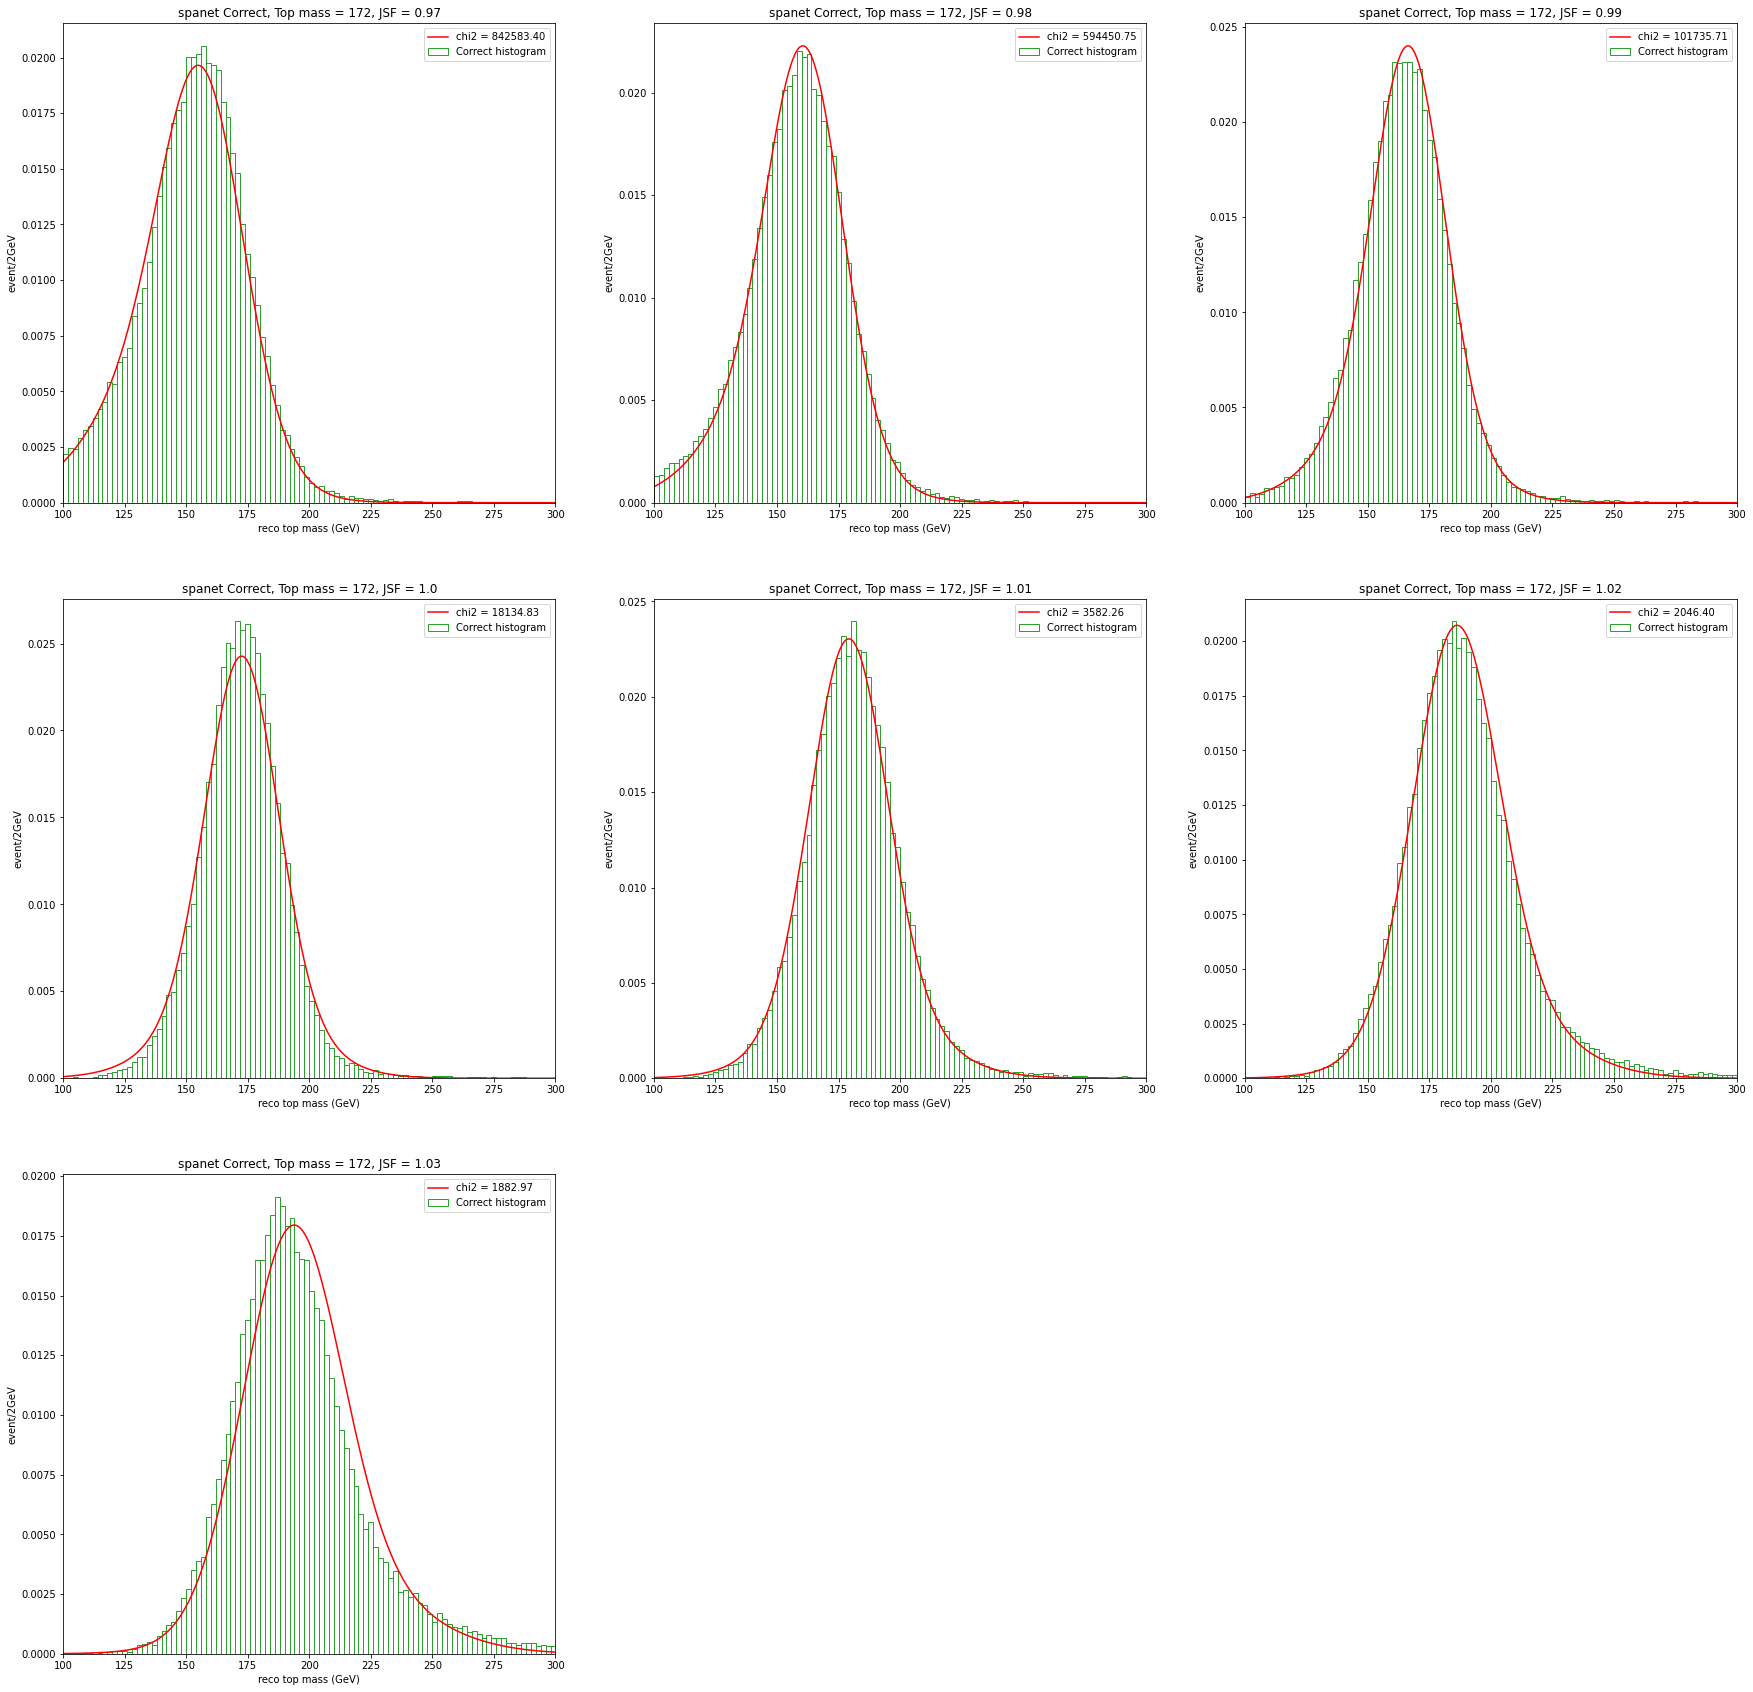

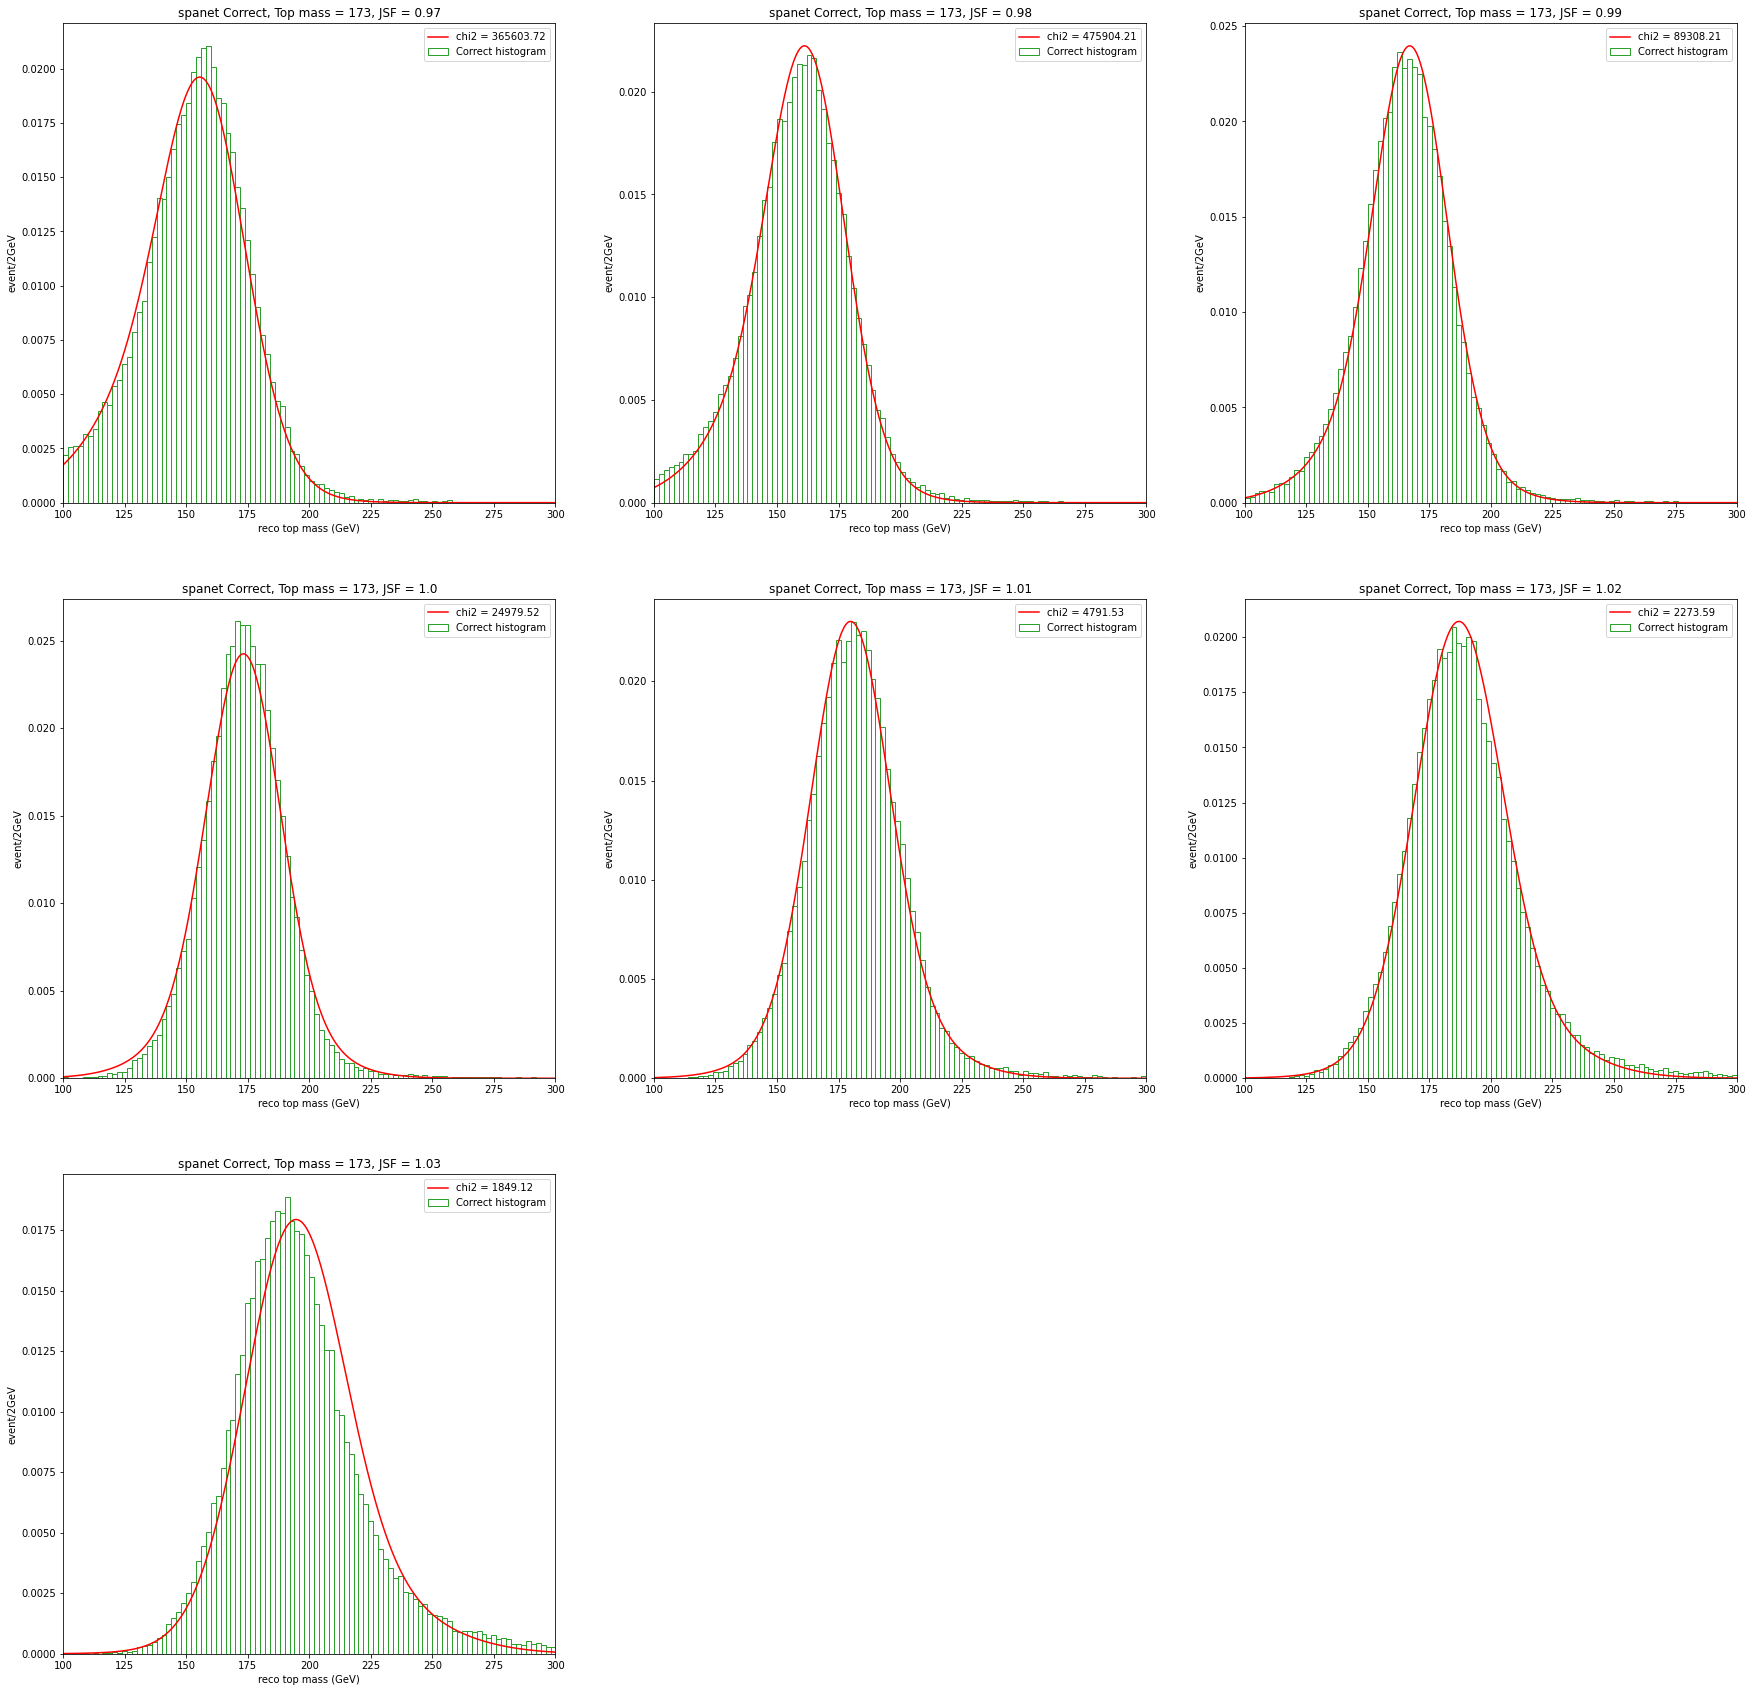

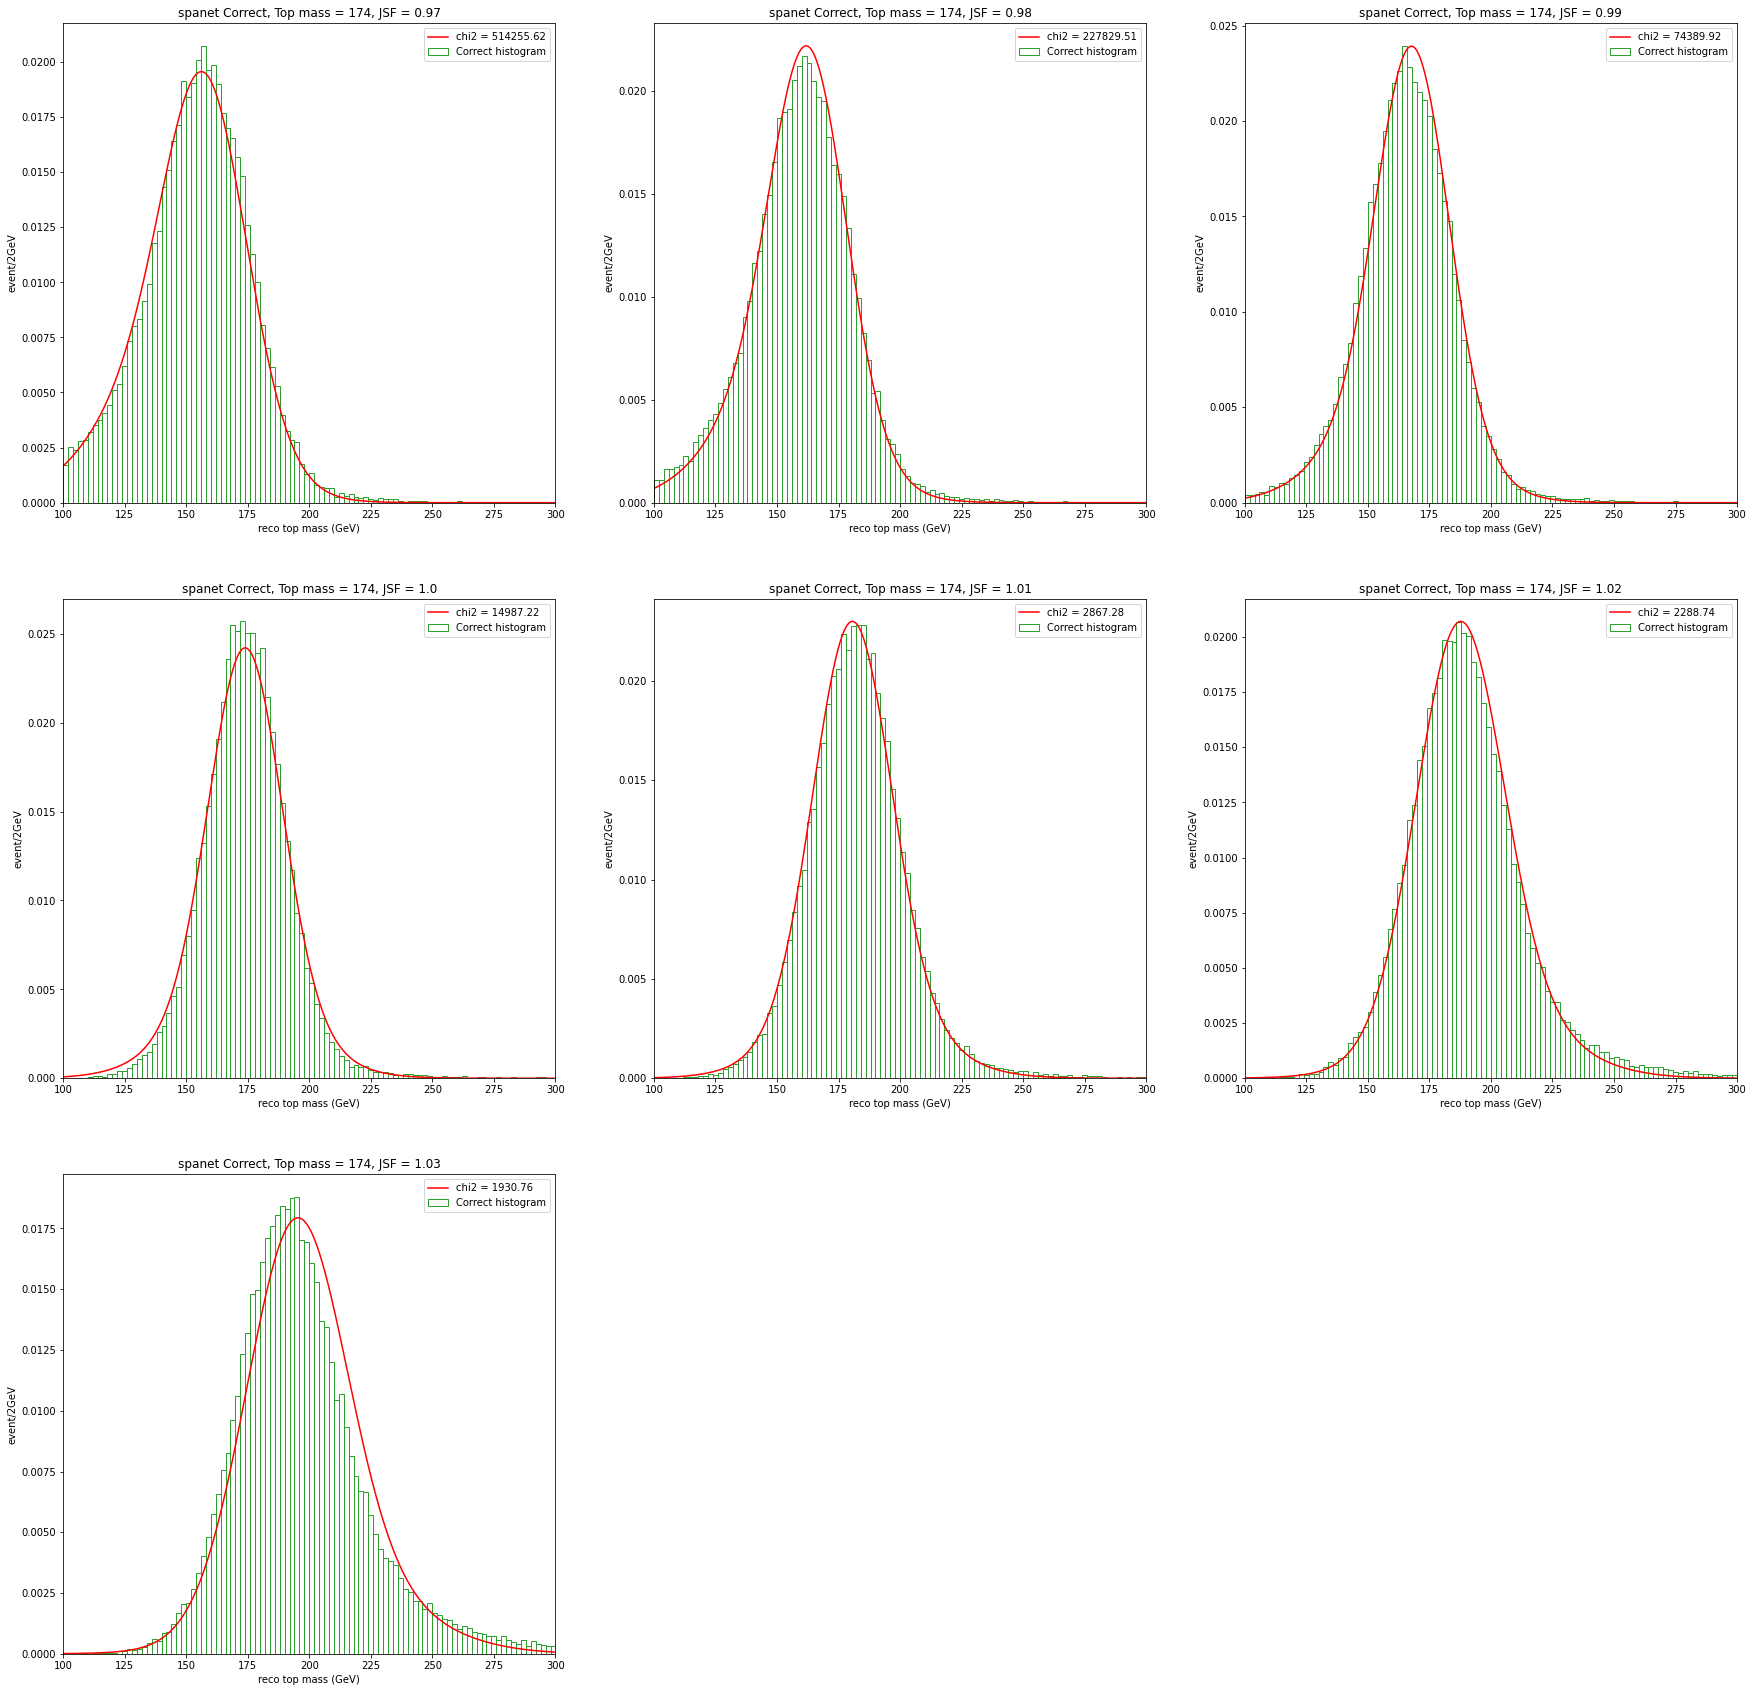

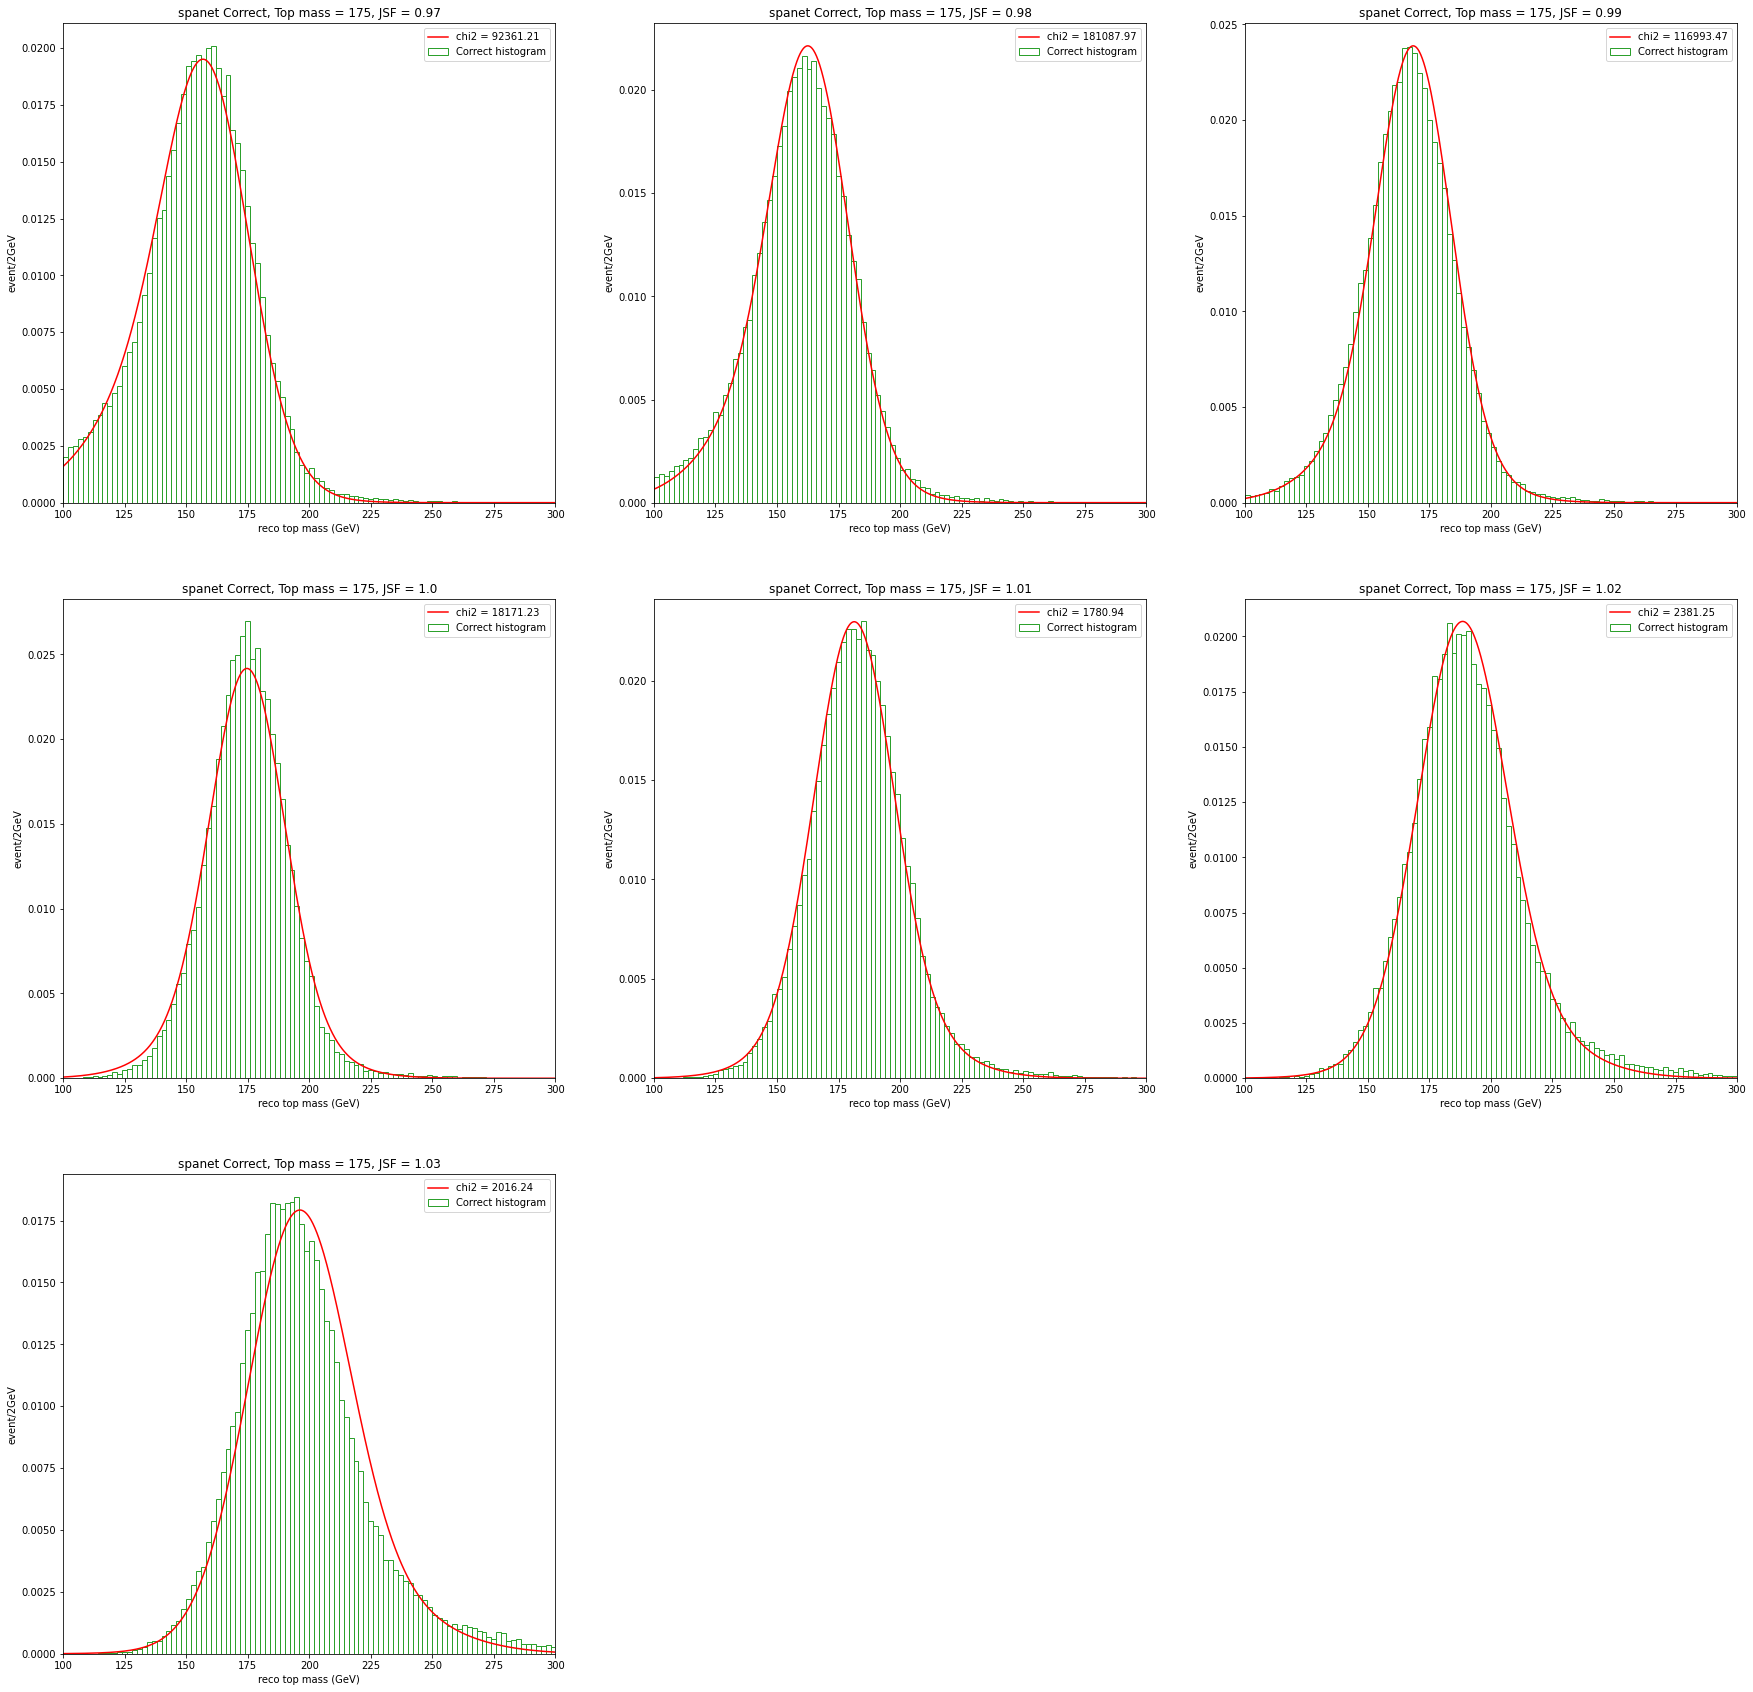

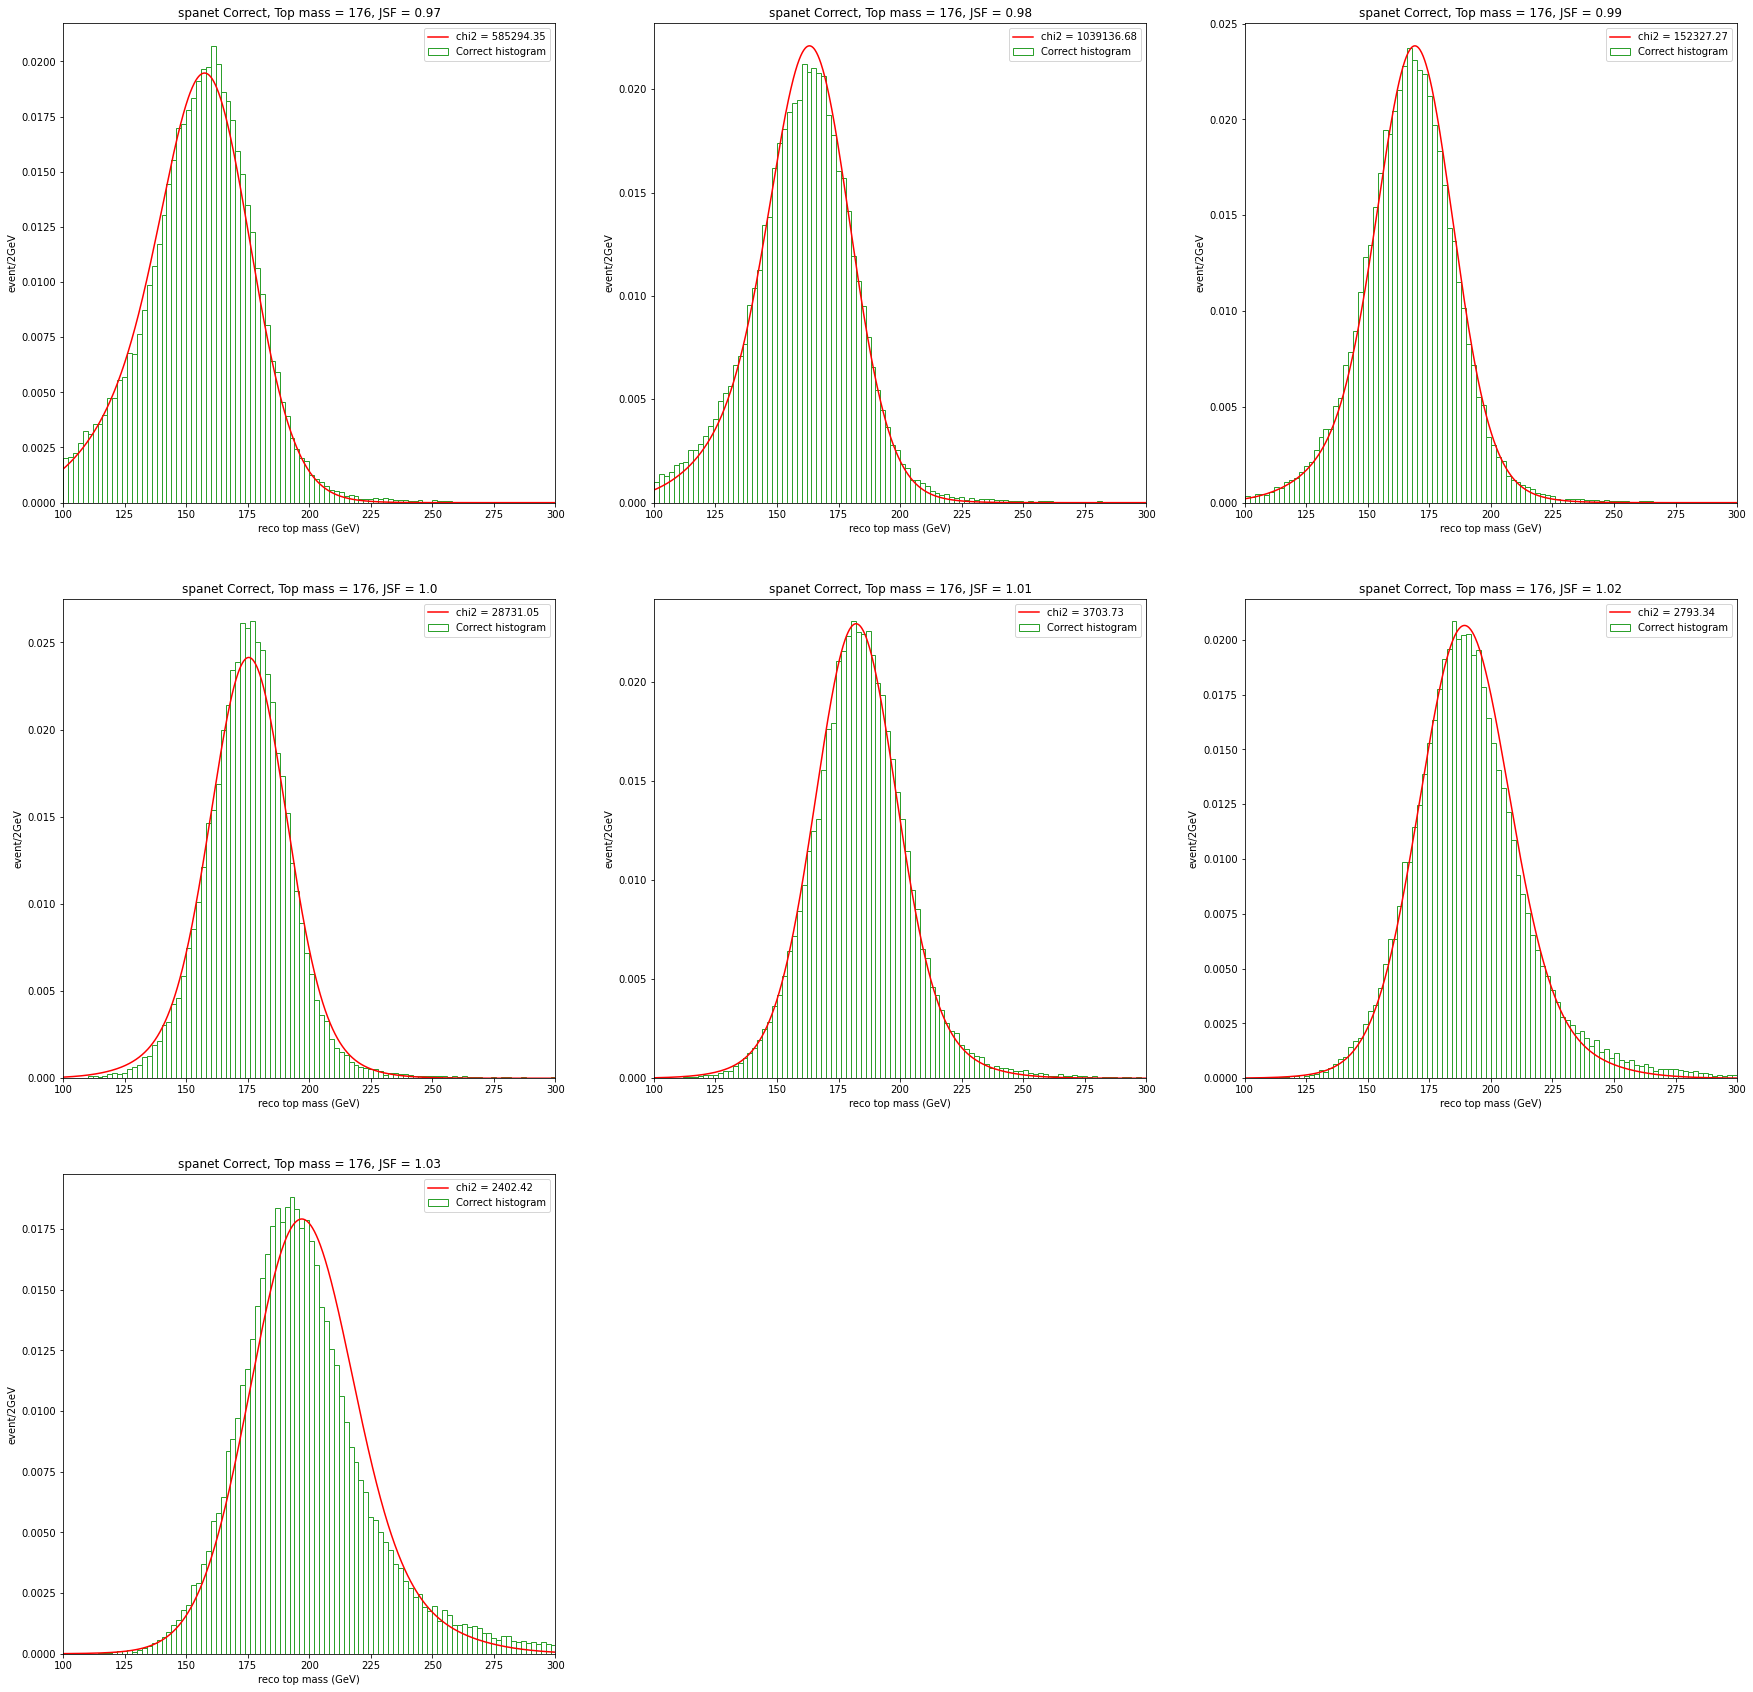

In [39]:
# Compare the pdf to the original histogram
for state_i in [0, 1, 2]:
    for m in mass:
        plt.figure(figsize=(30, 30))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(3, 3, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, loglikeli_klf_dic[(m, JSF)]>-70))]
            hist, bin_edges = np.histogram(fit_target, bins=bins, density=True)
            popt = [linear_parabola((m, JSF), *pdf_spanet_dic[(state_i, j)]) for j in range(5)]

            # 2Gaussian for correct
            if state_i == 2:
                y_dense = two_gau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, two_gau_norm(bins[:-1]+1, *popt))
            
            # Landau + Gaussian for incorrect and unmatch
            else:
                y_dense = langau_norm(bins_dense, *popt)
                chi2 = chi2_pdf(fit_target, langau_norm(bins[:-1]+1, *popt))

            plt.bar(bin_edges[:-1]+1, hist, edgecolor=colors[state_i], width=2, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(bins_dense, y_dense, c='r', label='chi2 = {:.2f}'.format(chi2))
            plt.xlim(100, 300)
            plt.title('spanet {}, Top mass = {}, JSF = {}'.format(state_labels[state_i], m, JSF))
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/2GeV')
            plt.legend()
        plt.show()

In [52]:
def combine_klf_pdf(m, JSF):
    hist = [0]*len(bins[:-1])
    for state_i in [0, 1, 2]:
        popt = [linear_parabola((m, JSF), *pdf_klf_dic[(state_i, i)]) for i in range(5)]
        if state_i == 2: hist += two_gau_norm(bins[:-1]+1, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
        else: hist += langau_norm(bins[:-1]+1, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def combine_spanet_pdf(m, JSF):
    hist = [0]*len(bins[:-1])
    for state_i in [0, 1, 2]:
        popt = [linear_parabola((m, JSF), *pdf_spanet_dic[(state_i, i)]) for i in range(5)]
        if state_i == 2: hist += two_gau_norm(bins[:-1]+1, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
        else: hist += langau_norm(bins[:-1]+1, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

In [53]:
reco_klf = reco_klf_dic[(173, 1)][np.logical_and.reduce((cut_klf_dic[(173, 1)], loglikeli_klf_dic[(173, 1)]>-70))]
chi2_klf_arr = [chi2_pdf(reco_klf, combine_klf_pdf(m, JSF)) for m in top_mass_dense for JSF in JSF_dense]
reco_spanet = reco_spanet_dic[(173, 1)][np.logical_and.reduce((cut_spanet_dic[(173, 1)], loglikeli_klf_dic[(173, 1)]>-70))]
chi2_spanet_arr = [chi2_pdf(reco_spanet, combine_spanet_pdf(m, JSF)) for m in top_mass_dense for JSF in JSF_dense]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
x_m = [m for m in top_mass_dense for JSF in JSF_dense]
x_JSF = [JSF for m in top_mass_dense for JSF in JSF_dense]
plt.scatter(x_m, x_JSF, c=chi2_klf_arr)
plt.colorbar()
plt.title('chi2 value for differnt top mass and JSF')
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')

plt.subplot(1, 2, 2)
m = min(chi2_klf_arr) + 4.61
two_sigma = [i for i, v in enumerate(chi2_klf_arr) if v < m]
plt.scatter([x_m[i] for i in two_sigma], [x_JSF[i] for i in two_sigma], c=[chi2_klf_arr[i] for i in two_sigma])
plt.colorbar()
plt.title('chi2 value for differnt top mass and JSF (two sigma)')
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
x_m = [m for m in top_mass_dense for JSF in JSF_dense]
x_JSF = [JSF for m in top_mass_dense for JSF in JSF_dense]
plt.scatter(x_m, x_JSF, c=chi2_spanet_arr)
plt.colorbar()
plt.title('chi2 value for differnt top mass and JSF')
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')

plt.subplot(1, 2, 2)
m = min(chi2_spanet_arr) + 4.61
two_sigma = [i for i, v in enumerate(chi2_spanet_arr) if v < m]
plt.scatter([x_m[i] for i in two_sigma], [x_JSF[i] for i in two_sigma], c=[chi2_spanet_arr[i] for i in two_sigma])
plt.colorbar()
plt.title('chi2 value for differnt top mass and JSF (two sigma)')
plt.xlabel('top mass (GeV)')
plt.ylabel('JSF')
plt.show()